In [1]:
import time
import yaml
import tensorflow as tf
import tensorflow_gnn as tfgnn
from pathlib import Path
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import Image
print(f'Using TensorFlow v{tf.__version__}')

from graph2tac.loader.data_server import DataServer
from graph2tac.tfgnn.dataset import DataLoaderDataset, TFRecordDataset, BIDIRECTIONAL, UNDIRECTED
from graph2tac.tfgnn.tasks import PredictionTask, TacticPrediction, LocalArgumentPrediction, GlobalArgumentPrediction, DefinitionTask, arguments_filter
from graph2tac.tfgnn.models import SIMPLE_CONVOLUTION_GNN, GCN_CONVOLUTION_GNN, ATTENTION_GNN, DENSE_TACTIC, SIMPLE_RNN, DENSE_DEFINITION
from graph2tac.tfgnn.metrics import SparseCategoricalConfusionMatrix, FullLocalArgumentSparseCategoricalAccuracy
from graph2tac.tfgnn.train import Trainer
from graph2tac.tfgnn.predict import Predict

Using TensorFlow v2.9.1


Check that TF is using the GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# <a id="contents">Contents</a>

- [Contents](#contents)
- [Data loading](#data_loading)
    - [Data inspection](#data_loading_data_inspection)
        - [Proof-states](#data_inspection_proofstates)
        - [Definitions](#data_inspection_definitions)
    - [Data statistics](#data_statistics)
- [Prediction tasks](#prediction_tasks)
    - [The `TacticPrediction` task](#tactic_prediction)
        - [Task inspection](#tactic_prediction_task_inspection)
        - [Data preparation](#tactic_prediction_data_preparation)
        - [Training](#tactic_prediction_training)
        - [Checkpointing](#tactic_prediction_checkpointing)
        - [Evaluation](#tactic_prediction_evaluation)
    - [The `LocalArgumentPrediction` task](#local_argument_prediction)
        - [Task inspection](#local_argument_prediction_task_inspection)
        - [Data preparation](#local_argument_prediction_data_preparation)
        - [Training](#local_argument_prediction_training)
        - [Checkpointing](#local_argument_prediction_checkpointing)
        - [Evaluation](#local_argument_prediction_evaluation)
    - [The `GlobalArgumentPrediction` task](#global_argument_prediction)
        - [Task inspection](#global_argument_prediction_task_inspection)
        - [Data preparation](#global_argument_prediction_data_preparation)
        - [Training](#global_argument_prediction_training)
        - [Checkpointing](#global_argument_prediction_checkpointing)
        - [Evaluation](#global_argument_prediction_evaluation)
- [The `Trainer` class](#trainer)
    - [Training](#trainer_training)
    - [Logs](#trainer_logs)
- [Definition tasks](#definition)
    - [Task inspection](#definition_inspection)
    - [Training](#definition_training)
- [The `Predict` class](#predict)
    - [Base tactic prediction](#predict_tactic)
    - [Local argument prediction](#predict_local_argument)
    - [Global argument prediction](#predict_global_argument)
    - [Batching predictions](#predict_batching)
    - [Evaluating predictions](#predict_evaluation)
- [Definition reconstruction](#definition_reconstruction)

# <a id="data_loading">Data loading</a> [↑](#contents)

Data can be loaded directly from the loader:

In [3]:
dataset = DataLoaderDataset(data_dir=Path('../tests/mini_stdlib/dataset'),
                            symmetrization=BIDIRECTIONAL,
                            add_self_edges=True,
                            split_random_seed=0,
                            max_subgraph_size=1024)

LOADING | indexing and top sorting bin files in ../tests/mini_stdlib/dataset...done.
LOADING | preparing data from 20 files.
LOADING | constructing file reference table...done.
LOADING | indexing all definitions...LOADING | definitions in spine: {len(global_nodes_in_spine)}
LOADING | definitions: 1002 
Indexed 1002 definitions in 0.005704 seconds.
LOADING | indexing all tactical action-outcomes in 20 files...LOADING | Indexed 2266 tactical action-outcomes in 0.015018 seconds.
LOADING | mmaping all capnp files and building data loader hash tables...done.
LOADING | data_online maps  20
20 buffer objects processed in 0.000162 seconds.
LOADING | in def_dependencies: max_subgraph_size=1024 bfs_option=True
LOADING | constructing shallow expansions of all definitions to build the graph of definition dependencies...done in 0.028888 seconds.
LOADING | NOTICE: the graph of definition dependencies should be precomputed and recorded to capnp bin files at the time of generation of the dataset. It i

C_LOADER INFO | processing 20 files
C_LOADER INFO | processing 20 files


Or, for best performance, it can also be loaded from TFRecord files:

In [4]:
dataset = TFRecordDataset(tfrecord_prefix=Path('../../data/mini_stdlib'),
                          symmetrization=BIDIRECTIONAL,
                          add_self_edges=True,
                          split_random_seed=0,
                          max_subgraph_size=1024)

In either case, the arguments are:
- `symmetrization`: indicates whether edges are to be considered having the direction that is provided in the input graphs (`None`), both directions with the same edge class (`'undirected'`) or both directions with different edge classes (`'bidirectional'`)
- `add_self_edges`: indicates whether we should artificially add a self-edge to each node in the graph
- `split_random_seed`: chooses the random seed to use for test/validation splitting.
- `max_subgraph_size`: bounds the number of nodes of the largest graph in the dataset.

For convenience, you can also use a YAML configuration file to specify these arguments:

In [5]:
dataset = DataLoaderDataset.from_yaml_config(data_dir=Path('../../data/mini_stdlib/dataset'),
                                             yaml_filepath=Path('../graph2tac/tfgnn/default_dataset_config.yml'))

LOADING | indexing and top sorting bin files in ../../data/mini_stdlib/dataset...done.
LOADING | preparing data from 20 files.
LOADING | constructing file reference table...done.
LOADING | indexing all definitions...LOADING | definitions in spine: {len(global_nodes_in_spine)}
LOADING | definitions: 1002 
Indexed 1002 definitions in 0.003755 seconds.
LOADING | indexing all tactical action-outcomes in 20 files...

C_LOADER INFO | processing 20 files
C_LOADER INFO | processing 20 files


LOADING | Indexed 2266 tactical action-outcomes in 0.015625 seconds.
LOADING | mmaping all capnp files and building data loader hash tables...done.
LOADING | data_online maps  20
20 buffer objects processed in 0.000180 seconds.
LOADING | in def_dependencies: max_subgraph_size=1024 bfs_option=True
LOADING | constructing shallow expansions of all definitions to build the graph of definition dependencies...done in 0.028253 seconds.
LOADING | NOTICE: the graph of definition dependencies should be precomputed and recorded to capnp bin files at the time of generation of the dataset. It is inefficient to recompute this graph every time dataserver is initialized.
LOADING | building strongly connected components (def clusters) in the meta graph of definition dependencies...done in 0.002500 seconds. Constructed 686 def clusters.
LOADING | DataServer is fully initialized in 0.054044 seconds and is ready to stream.


The `dataset` provides methods to generate `tf.data.Dataset` instances that stream `GraphTensor` objects, which encapsulate all the information we may need (_i.e._ both data _and_ labels):

In [6]:
train_proofstates = dataset.train_proofstates()
valid_proofstates = dataset.valid_proofstates()
definition_dataset = dataset.definitions()

**NOTE:** Before loading a dataset from TFRecord files for the first time you need to use the script at `graph2tac.tfgnn.dataset` to create the appropriate TFRecord files, or use `dataset.dump` _e.g._ from this notebook (this needs to be done once for each choice of `split_random_seed` and `max_subgraph_size`).

## <a id="data_loading_data_inspection">Data inspection</a> [↑](#contents)

Protobuffer schemas for the various `GraphTensor` objects that are used throughout the code can be found in `graph2tac.tfgnn.graph_schema`. Below we inspect the two basic types of `GraphTensor` objects that constitute the inputs to our networks: proof-state graphs and definition cluster graphs.

### <a id="data_inspection_proofstates">Proof-states</a> [↑](#contents)

To inspect proof-state graphs we first create an iterator over the desired dataset:

In [7]:
dataset_iterator = iter(train_proofstates)

And then the `GraphTensor` objects are generated from it as usual

In [8]:
graph_tensor = next(dataset_iterator)
graph_tensor

GraphTensor(
  context=Context(features={'tactic': <tf.Tensor: shape=(1,), dtype=tf.int64>, 'context_node_ids': <tf.RaggedTensor: dtype=tf.int64>, 'local_arguments': <tf.RaggedTensor: dtype=tf.int64>, 'global_arguments': <tf.RaggedTensor: dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])

As seen above, there is one type of nodes (`'node'`) and one type of edges (`'edge'`), and each of these has an integer-valued label (`'node_label'` and `'edge_label'` respectively):

In [9]:
graph_tensor.node_sets['node']

NodeSet(features={'node_label': <tf.Tensor: shape=(52,), dtype=tf.int64>}, sizes=[52])

In [10]:
graph_tensor.edge_sets['edge']

EdgeSet(features={'edge_label': <tf.Tensor: shape=(224,), dtype=tf.int64>}, sizes=[224], adjacency=Adjacency(source=('node', <tf.Tensor: shape=(224,), dtype=tf.int32>), target=('node', <tf.Tensor: shape=(224,), dtype=tf.int32>)))

Labels can be accessed dictionary-style:

In [11]:
graph_tensor.node_sets['node']['node_label']

<tf.Tensor: shape=(52,), dtype=int64, numpy=
array([  0,  16,   2,   2,   2,   2,   2,  17,  18,   6,  16,  16,  13,
        13,  16,  17,  18,  17,  18,  16,   6,  16,  16,  17,  18,  18,
        18,  40,  17,  18,  18,  17,  18,  17,  18, 726,  16, 724,  16,
        16,  17,  18,  17,  18,  17,  18,  18,  18,  16,   9,  17,  18])>

In [12]:
graph_tensor.edge_sets['edge']['edge_label']

<tf.Tensor: shape=(224,), dtype=int64, numpy=
array([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  2,  2,  2,  2,  3, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       27, 32, 32, 32, 32, 32, 32, 32, 33, 33, 34, 34, 34, 34, 34, 35, 44,
       44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
       47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 59, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,

The graph structure _per se_ is determined by additional features of the node and edge sets.

The number of nodes in the graph is:

In [13]:
graph_tensor.node_sets['node'].sizes

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([52], dtype=int32)>

The number of edges in the graph is:

In [14]:
graph_tensor.edge_sets['edge'].sizes

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([224], dtype=int32)>

And the edge sources and targets are:

In [15]:
graph_tensor.edge_sets['edge'].adjacency.source

<tf.Tensor: shape=(224,), dtype=int32, numpy=
array([12,  6,  5,  4,  3,  2, 13, 12, 13,  0,  0,  0,  0,  0,  0, 48, 39,
       38, 36, 10, 11,  1, 21, 14, 19, 22, 50, 44, 42, 40, 33, 31,  7, 23,
       15, 17, 28, 48, 39, 39, 39, 38, 36, 10, 11,  1, 21, 14, 14, 14, 19,
       19, 22, 47, 46, 43, 41, 45, 51, 34, 32, 30, 29,  8, 18, 16, 24, 25,
       26, 47, 46, 43, 41, 45, 51, 34, 32, 30, 29,  8, 18, 16, 24, 25, 26,
       49, 19, 13, 12, 11, 10,  9, 21, 20, 22,  2,  3,  4,  5,  6,  1, 50,
       44, 42, 40, 15, 17,  7, 31, 23, 28, 33, 27, 35, 27, 27,  5, 27,  5,
       35, 27, 27, 37, 51, 45, 46, 47, 43, 41, 16, 18,  8, 32, 24, 25, 26,
       29, 30, 34, 49, 48,  2,  2,  2,  2, 39,  2, 38,  2, 14,  2,  2,  2,
       36,  3, 46, 45, 42, 40, 44, 50, 33, 31, 29, 28,  7, 17, 15, 23, 24,
       25, 13,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,

In [16]:
graph_tensor.edge_sets['edge'].adjacency.target

<tf.Tensor: shape=(224,), dtype=int32, numpy=
array([19, 13, 12, 11, 10,  9, 21, 20, 22,  2,  3,  4,  5,  6,  1, 50, 44,
       42, 40, 15, 17,  7, 31, 23, 28, 33, 27, 35, 27, 27,  5, 27,  5, 35,
       27, 27, 37, 51, 45, 46, 47, 43, 41, 16, 18,  8, 32, 24, 25, 26, 29,
       30, 34, 49, 48,  2,  2,  2,  2, 39,  2, 38,  2, 14,  2,  2,  2, 36,
        3, 46, 45, 42, 40, 44, 50, 33, 31, 29, 28,  7, 17, 15, 23, 24, 25,
       13, 12,  6,  5,  4,  3,  2, 13, 12, 13,  0,  0,  0,  0,  0,  0, 48,
       39, 38, 36, 10, 11,  1, 21, 14, 19, 22, 50, 44, 42, 40, 33, 31,  7,
       23, 15, 17, 28, 48, 39, 39, 39, 38, 36, 10, 11,  1, 21, 14, 14, 14,
       19, 19, 22, 47, 46, 43, 41, 45, 51, 34, 32, 30, 29,  8, 18, 16, 24,
       25, 26, 47, 46, 43, 41, 45, 51, 34, 32, 30, 29,  8, 18, 16, 24, 25,
       26, 49,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,

Additionally, the graph context holds additional data (_i.e._ the ids of the nodes in the local context) and labels (_i.e._ the base tactic and arguments):

In [17]:
graph_tensor.context['context_node_ids']

<tf.RaggedTensor [[2, 4, 6, 5, 3]]>

In [18]:
graph_tensor.context['tactic']

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([36])>

In [19]:
graph_tensor.context['local_arguments']

<tf.RaggedTensor [[2]]>

In [20]:
graph_tensor.context['global_arguments']

<tf.RaggedTensor [[-1]]>

The following function can be used to visualize proof-state graphs

In [21]:
def draw_proofstate(proofstate_graph, graph_constants):
    (tactic_index,) = proofstate_graph.context['tactic']
    tactic = graph_constants.tactic_index_to_string[tactic_index]
    
    node_ids = tf.range(proofstate_graph.node_sets['node'].sizes).numpy()
    node_labels = proofstate_graph.node_sets['node']['node_label'].numpy()
    
    sources = proofstate_graph.edge_sets['edge'].adjacency.source.numpy()
    targets = proofstate_graph.edge_sets['edge'].adjacency.target.numpy()
    edge_labels = proofstate_graph.edge_sets['edge']['edge_label'].numpy()
    
    pgvGraph = pgv.AGraph()
    pgvGraph.graph_attr['label'] = f'{tactic}'
    
    for node_id, node_label in zip(node_ids, node_labels):
        pgvGraph.add_node(node_id, label=dataset.graph_constants().label_to_names[node_label])
    
    for edge, edge_label in zip(zip(sources, targets), edge_labels):
        pgvGraph.add_edge(edge, label=edge_label)
    
    return Image(pgvGraph.draw(format='png', prog='dot'))

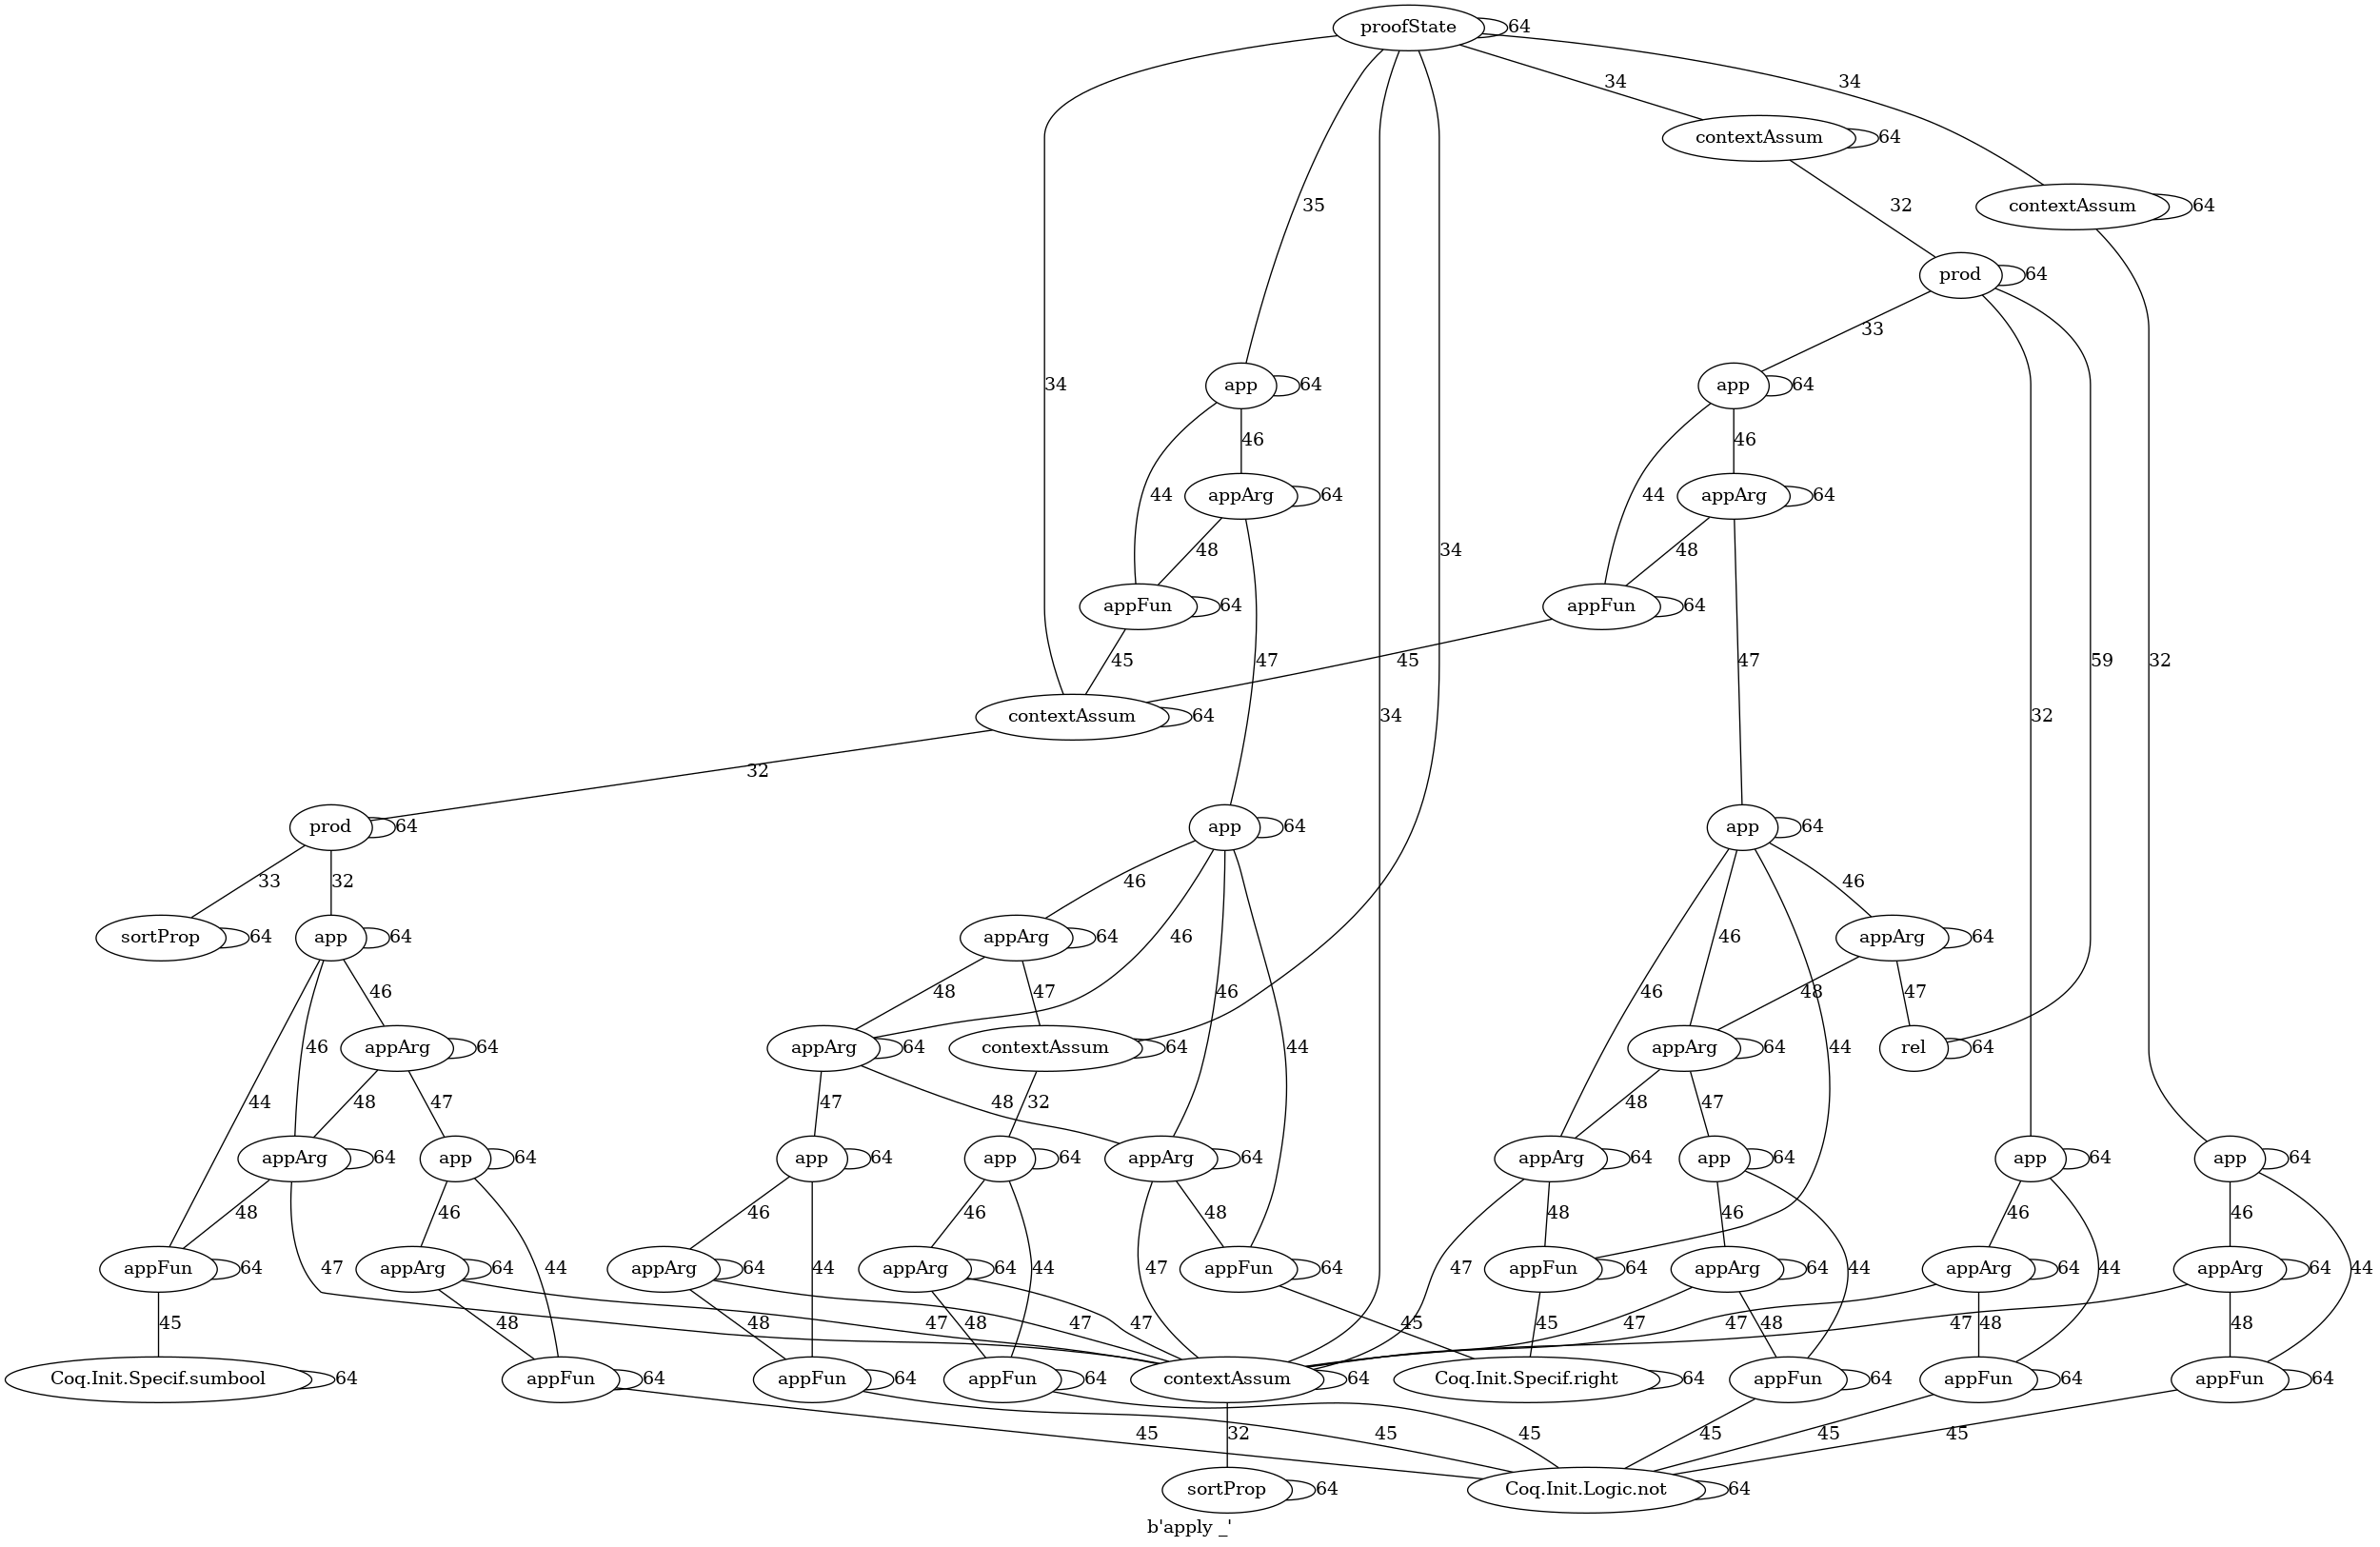

In [22]:
draw_proofstate(graph_tensor, dataset.graph_constants())

### <a id="data_inspection_definitions">Definitions</a> [↑](#contents)

Definition cluster graphs can be inspected in a similar fashion:

In [23]:
dataset_iterator = iter(definition_dataset)

2022-06-28 05:24:20.587357: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [24]:
graph_tensor = next(dataset_iterator)
graph_tensor

LOADING | requested 686


100%|██████████████████████████████████████████████████████████████████████████████| 686/686 [00:00<00:00, 10994.12it/s]


GraphTensor(
  context=Context(features={'num_definitions': <tf.Tensor: shape=(1,), dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])

They are essentially similar to the proof-state graphs, except the context now contains an integer value `'num_definitions'`, specifying the number of node labels defined by this cluster:

In [25]:
graph_tensor.context['num_definitions']

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>

By convention, the node labels being defined are the first `num_definitions` node labels in the order in which the nodes are listed, and can be extracted like so:

In [26]:
tf.gather(graph_tensor.node_sets['node']['node_label'], tf.range(graph_tensor.context['num_definitions']))

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([47])>

## <a id="data_statistics">Data statistics</a> [↑](#contents)

We can compute basic statistics about the datasets like so:

In [27]:
dataset.stats()

computing dataset statistics (this may take a while)...
LOADING | requested 686


{'train_proofstates': {'num_graphs': 1983,
  'num_nodes': 244784,
  'min_num_nodes': 4,
  'max_num_nodes': 842,
  'num_edges': 1191102,
  'min_num_edges': 14,
  'max_num_edges': 4072,
  'mean_num_nodes': 123.44125063035804,
  'mean_num_edges': 600.6565809379728,
  'num_arguments': 1256,
  'num_local_arguments': 581,
  'num_global_arguments': 1195,
  'num_local_proofstates': 1315,
  'num_global_proofstates': 1922},
 'valid_proofstates': {'num_graphs': 155,
  'num_nodes': 13907,
  'min_num_nodes': 9,
  'max_num_nodes': 842,
  'num_edges': 65059,
  'min_num_edges': 33,
  'max_num_edges': 4072,
  'mean_num_nodes': 89.72258064516129,
  'mean_num_edges': 419.73548387096776,
  'num_arguments': 64,
  'num_local_arguments': 48,
  'num_global_arguments': 61,
  'num_local_proofstates': 139,
  'num_global_proofstates': 152},
 'definitions': {'num_graphs': 686,
  'num_nodes': 133357,
  'min_num_nodes': 2,
  'max_num_nodes': 1024,
  'num_edges': 571507,
  'min_num_edges': 4,
  'max_num_edges': 5106,

These represent:
- `num_graphs`: the total number of graphs in the dataset
- `num_nodes`: the total number of nodes in the dataset's graphs
- `min_num_nodes`: the minimum number of nodes in any graph in the dataset
- `max_num_nodes`: the maximum number of nodes in any graph in the dataset
- `mean_num_nodes`: the average number of nodes in all graphs in the dataset
- `num_edges`: the total number of edges in the dataset's graphs
- `min_num_edges`: the minimum number of edges in any graph in the dataset
- `max_num_edges`: the maximum number of edges in any graph in the dataset
- `mean_num_nodes`: the average number of edges in all graphs in the dataset
- `num_arguments`: the total number of arguments in all the (proofstate) graphs in the dataset
- `num_local_arguments`: the number of local arguments which are not `None` in all of the (proofstate) graphs in the dataset
- `num_global_arguments`: the number of arguments which are not `None` in all of the (proofstate) graphs in the dataset (local or global)
- `num_local_proofstates`: the number of proofstate graphs in the dataset which do not contain any `None` or global arguments
- `num_global_proofstates`: the number of proofstate graphs in the dataset which do not contain any `None` arguments
- `num_definitions`: the number of node labels defined by all definition graphs

# <a id='prediction_tasks'>Prediction tasks</a> [↑](#contents)

The fundamental objects we will deal with are derived from the `PredictionTask` class, which encapsulates most of the information we need for training and inference.

There are currently three subclasses of `PredictionTask`:
- [`TacticPrediction` for base tactic prediction](#tactic_prediction)
- [`LocalArgumentPrediction` for the prediction of both the base tactic and the local arguments](#local_argument_prediction)
- [`GlobalArgumentPrediction` for the prediction of both the base tactic and the global arguments](#global_argument_prediction)

## <a id="tactic_prediction">The `TacticPrediction` task</a> [↑](#contents)

As a first example, let's look into the base tactic prediction task:

In [28]:
tactic_task = TacticPrediction(graph_constants=dataset.graph_constants(),
                               hidden_size=128,
                               tactic_embedding_size=128,
                               gnn_type=SIMPLE_CONVOLUTION_GNN,
                               gnn_config={
                                   'hops': 8,
                                   'dense_activation': 'relu',
                                   'residual_activation': 'relu',
                                   'dropout_rate': 0.1,
                                   'layer_norm': True,
                                   'reduce_type': 'max',
                                   'final_reduce_type': 'attention'
                               },
                               tactic_head_type=DENSE_TACTIC,
                               tactic_head_config={
                                   'hidden_layers':[{'units': 256, 'activation': 'relu'}]
                               }
                              )

Some of the parameters above define the actual model to use:
- `gnn_type` defines the GNN component of the model, with hyperparameters passed in `gnn_config`
- `tactic_head_type` defines the tactic prediction head, with hyperparameters passed in `tactic_head_config`

See `graph2tac.tfgnn.models` for all available options you can use for these arguments, and their corresponding hyperparameters.

The other parameters are:
- `graph_constants`: provides basic information about the `GraphTensor` objects that constitute the input (this comes from the dataset, see previous section)
- `hidden_size`: the size of the hidden states, which is the same for the various model components
- `tactic_embedding_size`: the size of the hidden state representing tactics (which is also used when predicting arguments)

For convenience, tasks can also be created from YAML configuration files:

In [29]:
tactic_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                              yaml_filepath=Path('../graph2tac/tfgnn/default_tactic_prediction.yml'))

### <a id="tactic_prediction_task_inspection">Task inspection</a> [↑](#contents)

When a task is instantiated, a Keras model named `prediction_model` is created for later use with the Keras `fit` training framework:

In [30]:
tactic_task.prediction_model

In the case of the `TacticPrediction` task, this model takes a `GraphTensor` as input:

In [31]:
tactic_task.prediction_model.inputs

[<KerasTensor: type_spec=GraphTensorSpec({'context': ContextSpec({'features': {'global_arguments': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32), 'context_node_ids': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32), 'local_arguments': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32), 'tactic': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), 'node_sets': {'node': NodeSetSpec({'features': {'node_label': RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None)}, 'edge_sets': {'edge': EdgeSetSpec({'features': {'edge_label': RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), 'adjacency': AdjacencySpec({'#index.0': Ragged

and produces a vector of tactic logits as output:

In [32]:
tactic_task.prediction_model.outputs

[<KerasTensor: shape=(None, 49) dtype=float32 (created by layer 'tactic_logits')>]

Notice the number of logits corresponds to the total number of base tactics

In [33]:
dataset.graph_constants().tactic_num

49

We can inspect the model as usual:

In [34]:
tactic_task.prediction_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 proofstate_graph (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 input.merge_batch_to_component  ()                  0           ['proofstate_graph[0][0]']       
 s_1 (InstanceMethod)                                                                             
                                                                                                  
 input.edge_sets_1 (InstancePro  {'edge': ()}        0           ['input.merge_batch_to_components
 perty)                                                          _1[0][0]']                       
                                                                                            

Its basic components are a GNN and a base tactic prediction head

In [35]:
tactic_task.gnn

In [36]:
tactic_task.tactic_head

### <a id="tactic_prediction_data_preparation">Data preparation</a> [↑](#contents)

`PredictionTask` objects have a `create_input_output` method that can be used to prepare the datasets we obtained in the previous section for training with the Keras `fit` training framework (producing input-output pairs for supervised training)

In [37]:
tactic_train_dataset = train_proofstates.map(tactic_task.create_input_output)
tactic_valid_dataset = valid_proofstates.map(tactic_task.create_input_output)

Exploring these datasets we see that there is a single input, corresponding to the `GraphTensor` object, and also a single output, corresponding to the base tactic we are supposed to predict:

In [38]:
inputs, outputs = next(iter(tactic_train_dataset))

2022-06-28 05:24:36.517779: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [39]:
inputs

GraphTensor(
  context=Context(features={'tactic': <tf.Tensor: shape=(1,), dtype=tf.int64>, 'context_node_ids': <tf.RaggedTensor: dtype=tf.int64>, 'local_arguments': <tf.RaggedTensor: dtype=tf.int64>, 'global_arguments': <tf.RaggedTensor: dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])

In [40]:
outputs

{'tactic_logits': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([34])>}

Notice that above, the `'tactic_logits'` key means that this output should be matched to the (sparse categorical crossentropy) loss that goes with the tactic logits output of our model, see below.

### <a id="tactic_prediction_training">Training</a> [↑](#contents)

`PredictionTask` objects additionally provide the losses, loss weights, metrics and callbacks for use with the Keras `fit` training framework

In [41]:
tactic_task.loss()

{'tactic_logits': <keras.losses.SparseCategoricalCrossentropy at 0x7efdac1bb580>}

In [42]:
tactic_task.loss_weights()

{'tactic_logits': 1.0}

In [43]:
tactic_task.metrics()

{'tactic_logits': [<keras.metrics.metrics.SparseCategoricalAccuracy at 0x7efdac1b96f0>]}

In [44]:
tactic_task.callbacks()

[]

To train the model, we first need to compile it

In [45]:
tactic_task.prediction_model.compile(optimizer='adam',
                                     loss=tactic_task.loss(),
                                     loss_weights=tactic_task.loss_weights(),
                                     metrics=tactic_task.metrics())

Then, we need to batch the datasets

In [46]:
batch_size = 64
batched_tactic_train_dataset = tactic_train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
batched_tactic_valid_dataset = tactic_valid_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

And finally we call the `fit` method

In [47]:
tactic_task.prediction_model.fit(batched_tactic_train_dataset,
                                 epochs=10,
                                 validation_data=batched_tactic_valid_dataset,
                                 callbacks=tactic_task.callbacks())

Epoch 1/10


/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/simple_convolution_gnn/graph_update_15/node_set_update_7/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/simple_convolution_gnn/graph_update_15/node_set_update_7/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/simple_convolution_gnn/graph_update_15/node_set_update_7/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/simple_convolution_gnn/graph_update

/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/simple_convolution_gnn/graph_update_9/node_set_update_1/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/simple_convolution_gnn/graph_update_9/node_set_update_1/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/simple_convolution_gnn/graph_update_9/node_set_update_1/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/simple_convolution_gnn/graph_update_9/

31/31 [==============================] - 11s 127ms/step - loss: 2.1831 - accuracy: 0.4518 - val_loss: 2.8811 - val_accuracy: 0.3032
Epoch 2/10
31/31 [==============================] - 2s 63ms/step - loss: 1.6432 - accuracy: 0.5915 - val_loss: 2.6253 - val_accuracy: 0.3290
Epoch 3/10
31/31 [==============================] - 2s 63ms/step - loss: 1.4981 - accuracy: 0.6026 - val_loss: 2.3160 - val_accuracy: 0.3548
Epoch 4/10
31/31 [==============================] - 2s 63ms/step - loss: 1.3531 - accuracy: 0.6248 - val_loss: 2.2334 - val_accuracy: 0.3355
Epoch 5/10
31/31 [==============================] - 2s 63ms/step - loss: 1.2699 - accuracy: 0.6309 - val_loss: 2.1849 - val_accuracy: 0.3677
Epoch 6/10
31/31 [==============================] - 2s 63ms/step - loss: 1.2040 - accuracy: 0.6480 - val_loss: 2.1531 - val_accuracy: 0.3613
Epoch 7/10
31/31 [==============================] - 2s 63ms/step - loss: 1.1477 - accuracy: 0.6495 - val_loss: 2.1340 - val_accuracy: 0.3484
Epoch 8/10
31/31 [====

### <a id="tactic_prediction_checkpointing">Checkpointing</a> [↑](#contents)

`PredictionTask` objects have a `checkpoint` attribute corresponding to a `tf.train.Checkpoint` one can use to read and write checkpoints.

Use the `write` method to dump model weights to disk

In [48]:
tactic_task.checkpoint.write('../../logs/tactic_prediction_simple_checkpoint')

'../../logs/tactic_prediction_simple_checkpoint'

We can now create a new model, which will be originally untrained

In [49]:
tactic_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                              yaml_filepath=Path('../graph2tac/tfgnn/default_tactic_prediction.yml'))

The `read` method is then used to load weights from disk, returning a `CheckpointLoadStatus ` object

In [50]:
load_status = tactic_task.checkpoint.read('../../logs/tactic_prediction_simple_checkpoint')
load_status

which we can then use to check that the loading worked (and perform the operation immediately, instead of deferring it until it's absolutely necessary):

In [51]:
load_status.expect_partial().run_restore_ops()

**NOTE:** Here and elsewhere, for checkpoint loading to work the `PredictionTask` must have the same underlying model as the checkpoint that we want to use: the checkpoint does not include the model's architecture, only the model's weights, so any changes in architecture would break the whole process (although partial loading might occur). Layer naming should therefore always be consistent.

As will be seen later, [the `Trainer` class](#trainer) can be used to streamline training, optionally saving checkpoints along the way. These can be reloaded as follows:

In [52]:
tactic_task.from_trainer_checkpoint('../../logs/tactic_test/ckpt/ckpt-25')

### <a id="tactic_prediction_evaluation">Evaluation</a> [↑](#contents)

We can further evaluate the model using other metrics which are not included by default in `task.metrics()`. In order to do this, we first define the Keras metric we are interested in:

In [53]:
top5_accuracy = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_accuracy')

Then we recompile the model with this metric:

In [54]:
tactic_task.prediction_model.compile(metrics=top5_accuracy)

and finally run the Keras `evaluate` method

In [55]:
tactic_task.prediction_model.evaluate(tactic_valid_dataset, return_dict=True)

156/156 [==============================] - 2s 5ms/step - loss: 0.0000e+00 - top5_accuracy: 0.8194


{'loss': 0.0, 'top5_accuracy': 0.8193548321723938}

New metrics can be sub-classed from `tf.keras.metrics.Metric` and used in the same way, see for example the definition of `SparseCategoricalConfusionMatrix` in `graph2tac.tfgnn.metrics`

In [56]:
confusion_matrix = SparseCategoricalConfusionMatrix(num_categories=dataset.graph_constants().tactic_num)

In [57]:
tactic_task.prediction_model.compile(metrics=confusion_matrix)

In [58]:
tactic_task.prediction_model.evaluate(batched_tactic_valid_dataset)

3/3 [==============================] - 1s 23ms/step - loss: 0.0000e+00 - confusion_matrix: 0.0096


[0.0,
 array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.5714286, 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.5      , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32)]

Here we plot the non-trivial predictions

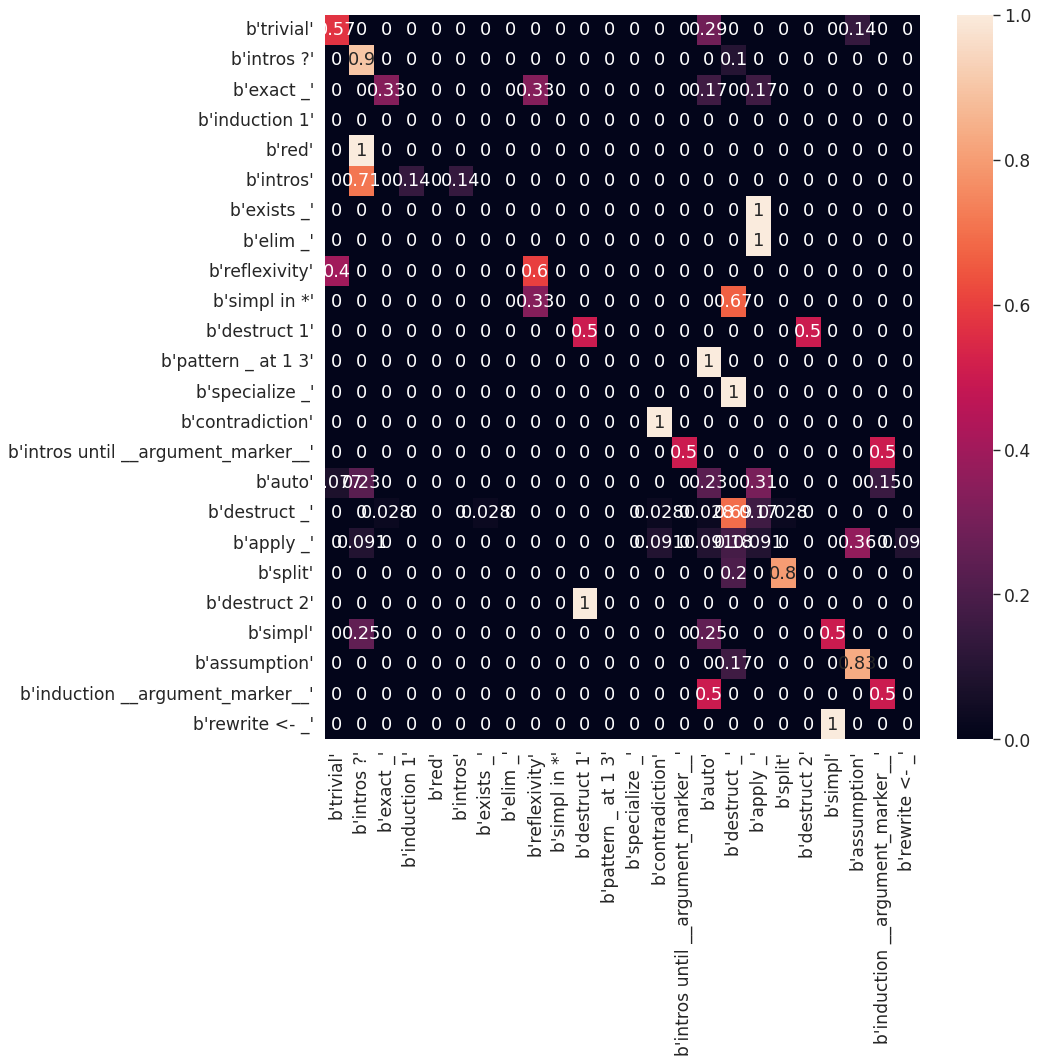

In [59]:
tactic_names = dataset.graph_constants().tactic_index_to_string
confusion_matrix_df = pd.DataFrame(confusion_matrix.result(), tactic_names, tactic_names)
non_empty = ~((confusion_matrix_df==0).all(axis=0) & (confusion_matrix_df==0).all(axis=1))
confusion_matrix_df = confusion_matrix_df.loc[non_empty,non_empty]

plt.figure(figsize=(12,12), dpi=80)
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_df, annot_kws={"size": 16}, annot=True)
plt.show()

## <a id="local_argument_prediction">The `LocalArgumentPrediction` task</a> [↑](#contents)

The `LocalArgumentPrediction` task works in a very similar fashion to the `TacticPrediction` task, except upon construction we need to provide a function to create the argument head (producing hidden states for each argument position):

In [60]:
local_argument_task = LocalArgumentPrediction(graph_constants=dataset.graph_constants(),
                                              hidden_size=128,
                                              tactic_embedding_size=128,
                                              gnn_type=ATTENTION_GNN,
                                              gnn_config={
                                                  'hops': 8,
                                                  'final_reduce_type': 'attention',
                                                  'attention_config': {}
                                              },
                                              tactic_head_type=DENSE_TACTIC,
                                              tactic_head_config={
                                                  'hidden_layers': [{'units': 256, 'activation': 'relu'}]
                                              },
                                              arguments_head_type=SIMPLE_RNN,
                                              arguments_head_config={
                                                  'activation': 'relu',
                                                  'recurrent_depth': 2,
                                                  'recurrent_activation': 'tanh'
                                              },
                                              arguments_loss_coefficient=1.0
                                             )

The new arguments above are:
- `arguments_head_type`, specifying the type of arguments head to use (with hyperparameters provided by `arguments_head_config`)
- `arguments_loss_coefficient`, specifying the coefficient in front of the (sparse categorical crossentropy) loss term for the arguments, where the normalization is given by a unit coefficient in front of the corresponding term for the base tactic

Again, for convenience we can also use the `from_yaml_config` method to instantiate the task from a YAML configuration file:

In [61]:
local_argument_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                                      yaml_filepath=Path('../graph2tac/tfgnn/default_local_argument_prediction.yml'))

### <a id="local_argument_prediction_task_inspection">Task inspection</a> [↑](#contents)

The `prediction_model` now also includes the arguments head which produces logits for each node in the local context:

In [62]:
local_argument_task.prediction_model.summary()

Model: "local_argument_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 proofstate_graph (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 input.merge_batch_to_component  ()                  0           ['proofstate_graph[0][0]']       
 s_4 (InstanceMethod)                                                                             
                                                                                                  
 input.edge_sets_4 (InstancePro  {'edge': ()}        0           ['input.merge_batch_to_components
 perty)                                                          _4[0][0]']                       
                                                                             

The task's `prediction_model` again has a single input (the proof-state graph), but now includes two outputs (the tactic logits and the logits for each local context node to be chosen for each argument position):

In [63]:
local_argument_task.prediction_model.inputs

[<KerasTensor: type_spec=GraphTensorSpec({'context': ContextSpec({'features': {'global_arguments': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32), 'context_node_ids': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32), 'local_arguments': RaggedTensorSpec(TensorShape([None, 1, None]), tf.int64, 2, tf.int32), 'tactic': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), 'node_sets': {'node': NodeSetSpec({'features': {'node_label': RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None)}, 'edge_sets': {'edge': EdgeSetSpec({'features': {'edge_label': RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), 'adjacency': AdjacencySpec({'#index.0': Ragged

In [64]:
local_argument_task.prediction_model.outputs

[<KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'arguments_logits')>,
 <KerasTensor: shape=(None, 49) dtype=float32 (created by layer 'tactic_logits')>]

The new output above is `arguments_logits`, with shape corresponding to `(batch_size, num_arguments, local_context_size)`.

**NOTE:** The model is _weakly autoregressive_, in the sense that the arguments are computed assuming the correct base tactic has been chosen (the `prediction_model` takes care of implementing this behind-the-scenes). Therefore, for inference purposes we need to implement a decoder, see the section on the [`Predict` class](#predict) for more details.

Again, one can access the individual componens if necessary; the new one is

In [65]:
local_argument_task.arguments_head

### <a id="local_argument_prediction_data_preparation">Data preparation</a> [↑](#contents)

As before, we prepare the training and validation data using the `create_input_output` method:

In [66]:
local_argument_train_dataset = train_proofstates.map(local_argument_task.create_input_output)
local_argument_valid_dataset = valid_proofstates.map(local_argument_task.create_input_output)

To inspect some elements, create an iterator and extract from it the input-output pairs:

In [67]:
local_argument_train_dataset_iterator = iter(local_argument_train_dataset)

In [68]:
inputs, outputs = next(local_argument_train_dataset_iterator)

In [69]:
inputs

GraphTensor(
  context=Context(features={'tactic': <tf.Tensor: shape=(1,), dtype=tf.int64>, 'context_node_ids': <tf.RaggedTensor: dtype=tf.int64>, 'local_arguments': <tf.RaggedTensor: dtype=tf.int64>, 'global_arguments': <tf.RaggedTensor: dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])

In [70]:
outputs

{'tactic_logits': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>,
 'arguments_logits': <tf.RaggedTensor [[-1]]>}

The new output named `'arguments_logits'` provides the ids of the nodes that should be chosen as arguments, in the order they should appear. These ids go from 0 to the number of nodes in the local context, and running the above a few times you may see values of `-1`, which encode `None` or global arguments. Predictions for these are discarded, so that they do **not** contribute to the loss or accuracy of the model.

### <a id="local_argument_prediction_training">Training</a> [↑](#contents)

Like the `TacticPrediction` tasks, `LocalArgumentPrediction` tasks provide everything you need to compile the model

In [71]:
local_argument_task.prediction_model.compile(optimizer='adam',
                                             loss=local_argument_task.loss(),
                                             loss_weights=local_argument_task.loss_weights(),
                                             metrics=local_argument_task.metrics())

We can then batch the datasets we prepared:

In [72]:
batch_size = 64
batched_local_argument_train_dataset = local_argument_train_dataset.batch(batch_size)
batched_local_argument_valid_dataset = local_argument_valid_dataset.batch(batch_size)

And finally train the model as usual

In [73]:
local_argument_task.prediction_model.fit(batched_local_argument_train_dataset,
                                         epochs=25,
                                         validation_data=batched_local_argument_valid_dataset,
                                         callbacks=local_argument_task.callbacks())

Epoch 1/25


/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/local_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/local_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_values:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/local_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/local_argument_model_1/rnn_arguments_head/cond/Identity_1:0", shape=(None,), dtype=int64), values=Te

/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/local_argument_model_1/simple_convolution_gnn/graph_update_26/node_set_update_2/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/local_argument_model_1/simple_convolution_gnn/graph_update_26/node_set_update_2/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/local_argument_model_1/simple_convolution_gnn/graph_update_26/node_set_update_2/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tap

31/31 [==============================] - 15s 174ms/step - loss: 2.6068 - arguments_logits_loss: 1.4879 - tactic_logits_loss: 2.4580 - arguments_logits_accuracy: 0.5129 - tactic_logits_accuracy: 0.3374 - arguments_seq_accuracy: 0.7954 - strict_accuracy: 0.0862 - val_loss: 3.2387 - val_arguments_logits_loss: 1.7429 - val_tactic_logits_loss: 3.0645 - val_arguments_logits_accuracy: 0.5833 - val_tactic_logits_accuracy: 0.1290 - val_arguments_seq_accuracy: 0.8561 - val_strict_accuracy: 0.1290
Epoch 2/25
31/31 [==============================] - 2s 79ms/step - loss: 1.9775 - arguments_logits_loss: 1.1447 - tactic_logits_loss: 1.8630 - arguments_logits_accuracy: 0.4923 - tactic_logits_accuracy: 0.4992 - arguments_seq_accuracy: 0.7886 - strict_accuracy: 0.1851 - val_loss: 3.1240 - val_arguments_logits_loss: 1.7467 - val_tactic_logits_loss: 2.9493 - val_arguments_logits_accuracy: 0.5000 - val_tactic_logits_accuracy: 0.2452 - val_arguments_seq_accuracy: 0.8273 - val_strict_accuracy: 0.2065
Epoch 3

31/31 [==============================] - 2s 78ms/step - loss: 0.8628 - arguments_logits_loss: 0.6954 - tactic_logits_loss: 0.7932 - arguments_logits_accuracy: 0.6575 - tactic_logits_accuracy: 0.7398 - arguments_seq_accuracy: 0.8578 - strict_accuracy: 0.3848 - val_loss: 1.9592 - val_arguments_logits_loss: 0.8357 - val_tactic_logits_loss: 1.8757 - val_arguments_logits_accuracy: 0.6042 - val_tactic_logits_accuracy: 0.4581 - val_arguments_seq_accuracy: 0.8633 - val_strict_accuracy: 0.3871
Epoch 18/25
31/31 [==============================] - 2s 78ms/step - loss: 0.8268 - arguments_logits_loss: 0.6659 - tactic_logits_loss: 0.7602 - arguments_logits_accuracy: 0.6816 - tactic_logits_accuracy: 0.7408 - arguments_seq_accuracy: 0.8669 - strict_accuracy: 0.3888 - val_loss: 1.9317 - val_arguments_logits_loss: 0.7587 - val_tactic_logits_loss: 1.8558 - val_arguments_logits_accuracy: 0.6667 - val_tactic_logits_accuracy: 0.4774 - val_arguments_seq_accuracy: 0.8849 - val_strict_accuracy: 0.4194
Epoch 19

### <a id="local_argument_prediction_checkpointing">Checkpointing</a> [↑](#contents)

Checkpoints work identically to the `TacticPrediction` task, _e.g._ use `checkpoint.write` to dump a checkpoint to disk

In [74]:
local_argument_task.checkpoint.write('../../logs/local_argument_prediction_simple_checkpoint')

'../../logs/local_argument_prediction_simple_checkpoint'

Then after creating a new model, you can use `checkpoint.read` to load back its weights from disk

In [75]:
local_argument_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                                yaml_filepath=Path('../graph2tac/tfgnn/default_local_argument_prediction.yml'))

In [76]:
load_status = local_argument_task.checkpoint.read('../../logs/local_argument_prediction_simple_checkpoint')
load_status.expect_partial().run_restore_ops()

For training checkpoints there is again the `from_trainer_checkpoint` method

In [77]:
local_argument_task.from_trainer_checkpoint('../../logs/local_argument_test/ckpt/ckpt-25')

### <a id="local_argument_prediction_evaluation">Evaluation</a> [↑](#contents)

For evaluation purposes, when dealing with local argument predictions it is often convenient to extract the valid arguments, as well as their corresponding logits. The `graph2tac.tfgnn.tasks` module defines an `arguments_filter` method to do exactly this

In [78]:
inputs, outputs = next(iter(batched_local_argument_train_dataset))

In [79]:
model_outputs = local_argument_task.prediction_model(inputs)

In [80]:
arguments_filter(y_true=outputs[local_argument_task.ARGUMENTS_LOGITS], 
                 y_pred=model_outputs[local_argument_task.ARGUMENTS_LOGITS])

(<tf.Tensor: shape=(18,), dtype=int64, numpy=array([2, 0, 5, 3, 3, 0, 7, 0, 2, 0, 0, 4, 2, 1, 2, 0, 2, 2])>,
 <tf.Tensor: shape=(18, 12), dtype=float32, numpy=
 array([[ -7.270672 ,  -2.7570064,   2.3583975,  -7.070706 ,  -6.6752987,
          -6.4738646,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf],
        [ -1.2590601,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf],
        [-12.592446 , -12.614426 , -12.614134 ,  -7.9398775,  -7.9392605,
          -2.867592 ,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf],
        [-12.82477  , -14.207932 ,  -5.12072  ,  -5.121242 ,  -5.1189976,
          -5.118478 , -12.837463 , -13.110373 , -12.856602 , -13.12541  ,
         -12.85741  , -13.121354 ],
        [ -1.2590295,  -1.2590283,  -1.2590283,  -1.2590276,        -inf,
                -inf,        -

The returned tuple contains the node ids for the local arguments (as they appear in the local context, first element); and the logits for each local context node to correspond to each local argument (filled with `-inf` to fit a rectangular tensor, second element).

We can use this method to define simple wrappers around other metrics

In [81]:
class ArgumentSparseTopKCategoricalAccuracy(tf.keras.metrics.SparseTopKCategoricalAccuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        arguments_true, arguments_pred = arguments_filter(y_true, y_pred)
        super().update_state(arguments_true, tf.math.softmax(arguments_pred, axis=-1), sample_weight)

These can then be used as before to evaluate the model

In [82]:
top5_accuracy = ArgumentSparseTopKCategoricalAccuracy(k=5, name='top5_accuracy')

In [83]:
local_argument_task.prediction_model.compile(metrics={local_argument_task.ARGUMENTS_LOGITS: top5_accuracy})

In [84]:
local_argument_task.prediction_model.evaluate(batched_local_argument_valid_dataset,
                                              callbacks=local_argument_task.callbacks(),
                                              return_dict=True)

3/3 [==============================] - 2s 28ms/step - loss: 0.0000e+00 - arguments_logits_top5_accuracy: 0.9792 - arguments_seq_accuracy: 0.8705 - strict_accuracy: 0.4645


{'loss': 0.0,
 'arguments_logits_top5_accuracy': 0.9791666865348816,
 'arguments_seq_accuracy': 0.8705036044120789,
 'strict_accuracy': 0.46451613306999207}

An example of a more involved metric is the `FullLocalArgumentSparseCategoricalAccuracy` found in `graph2tac.tfgnn.metrics`

This metric measures the accuracy for predicting the full sequence of arguments, of course discarding target sequences containing invalid arguments which the network could never predict. We have the possibility to choose one of three different weighting schemes:
- `'non-empty'` only considers non-empty sequences of arguments
- `'length'` weighs each sequence using its length (so empty sequences do not contribute, and longer sequences contribute more than short ones)
- `None` weights all sequences uniformly, including the empty ones

In [85]:
nonempty_accuracy = FullLocalArgumentSparseCategoricalAccuracy(weighting_scheme='non-empty', name='nonempty_accuracy')
length_accuracy = FullLocalArgumentSparseCategoricalAccuracy(weighting_scheme='length', name='length_weighted_accuracy')
absolute_accuracy = FullLocalArgumentSparseCategoricalAccuracy(weighting_scheme=None, name='absolute_accuracy')
all_accuracies = [nonempty_accuracy, length_accuracy, absolute_accuracy]

In [86]:
local_argument_task.prediction_model.compile(metrics={local_argument_task.ARGUMENTS_LOGITS: all_accuracies})

In [87]:
local_argument_task.prediction_model.evaluate(batched_local_argument_valid_dataset, 
                                              callbacks=local_argument_task.callbacks(),
                                              return_dict=True)

3/3 [==============================] - 3s 30ms/step - loss: 0.0000e+00 - arguments_logits_nonempty_accuracy: 0.6250 - arguments_logits_length_weighted_accuracy: 0.6250 - arguments_logits_absolute_accuracy: 0.8705 - arguments_seq_accuracy: 0.8705 - strict_accuracy: 0.4645


{'loss': 0.0,
 'arguments_logits_nonempty_accuracy': 0.625,
 'arguments_logits_length_weighted_accuracy': 0.625,
 'arguments_logits_absolute_accuracy': 0.8705036044120789,
 'arguments_seq_accuracy': 0.8705036044120789,
 'strict_accuracy': 0.46451613306999207}

As expected, we see that the absolute accuracy is highest, because many argument sequences are actually empty so trivially correct. Moreover, the non-empty accuracy is greater than the length-weighted accuracy, since long sequences weigh more in the latter and are presumably harder to get right.

Of course, metrics on the tactic logits work as before

In [88]:
confusion_matrix = SparseCategoricalConfusionMatrix(num_categories=dataset.graph_constants().tactic_num)

In [89]:
local_argument_task.prediction_model.compile(metrics={local_argument_task.TACTIC_LOGITS: confusion_matrix})

In [90]:
local_argument_task.prediction_model.evaluate(batched_local_argument_valid_dataset,
                                              callbacks=local_argument_task.callbacks(),
                                              return_dict=True)

3/3 [==============================] - 2s 28ms/step - loss: 0.0000e+00 - tactic_logits_confusion_matrix: 0.0096 - arguments_seq_accuracy: 0.8705 - strict_accuracy: 0.4645


{'loss': 0.0,
 'tactic_logits_confusion_matrix': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.71428573, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.5       , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 'arguments_seq_accuracy': 0.8705036044120789,
 'strict_accuracy': 0.46451613306999207}

Here we plot the non-empty predictions

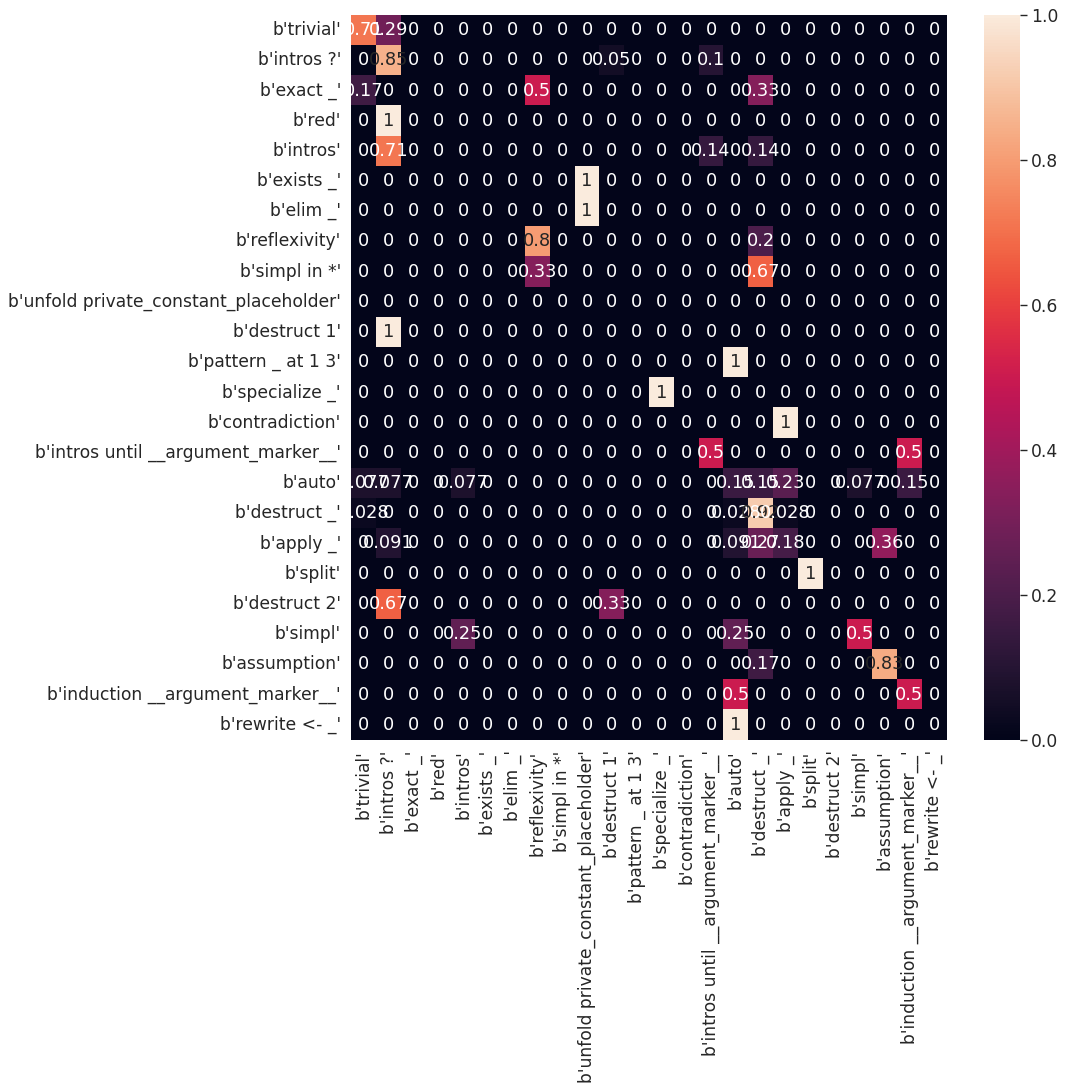

In [91]:
tactic_names = dataset.graph_constants().tactic_index_to_string
confusion_matrix_df = pd.DataFrame(confusion_matrix.result(), tactic_names, tactic_names)
non_empty = ~((confusion_matrix_df==0).all(axis=0) & (confusion_matrix_df==0).all(axis=1))
confusion_matrix_df = confusion_matrix_df.loc[non_empty,non_empty]

plt.figure(figsize=(12,12), dpi=80)
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_df, annot_kws={"size": 16}, annot=True)
plt.show()

**NOTE:** Keras' `fit` and `evaluate` methods operate with metrics working with a single output, so that to define metrics involving multiple outputs one has to override the model's `compute_metrics` method. When doing this, it may be necessary to include additional callbacks to make sure these metrics are reset before each epoch / test run, since they were not passed as arguments to `compile` and therefore the resetting won't be automatic. This is the reason why in the calls to `evaluate` before we allways include the `task.callbacks()`, which in this case handle the correct computation of the strict accuracy.

## <a id="global_argument_prediction">The `GlobalArgumentPrediction` task</a> [↑](#contents)

The `GlobalArgumentPrediction` class works essentially like the `LocalArgumentPrediction` of the previous section. We can again create it providing the same arguments to the constructor:

In [92]:
global_argument_task = GlobalArgumentPrediction(graph_constants=dataset.graph_constants(),
                                                hidden_size=128,
                                                tactic_embedding_size=128,
                                                gnn_type=ATTENTION_GNN,
                                                gnn_config={
                                                    'hops': 8,
                                                    'final_reduce_type': 'attention',
                                                    'attention_config': {}
                                                },
                                                tactic_head_type=DENSE_TACTIC,
                                                tactic_head_config={
                                                    'hidden_layers': [{'units': 256, 'activation': 'relu'}]
                                                },
                                                arguments_head_type=SIMPLE_RNN,
                                                arguments_head_config={
                                                    'activation': 'relu',
                                                    'recurrent_depth': 2,
                                                    'recurrent_activation': 'tanh'
                                                },
                                                arguments_loss_coefficient=1.0
                                               )

Or using YAML configuration files

In [93]:
global_argument_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                                       yaml_filepath=Path('../graph2tac/tfgnn/default_global_argument_prediction.yml'))

**NOTE:** The `arguments_loss_coefficient` controls the coefficient in front of the loss term for both global and local arguments, although in principle we could differentiate these.

### <a id="global_argument_prediction_task_inspection">Task inspection</a> [↑](#contents)

The task's `prediction_model` is essentially the same as the one we used for local argument predictions:

In [94]:
global_argument_task.prediction_model.summary()

Model: "global_argument_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 proofstate_graph (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 input.merge_batch_to_component  ()                  0           ['proofstate_graph[0][0]']       
 s_7 (InstanceMethod)                                                                             
                                                                                                  
 input.edge_sets_7 (InstancePro  {'edge': ()}        0           ['input.merge_batch_to_components
 perty)                                                          _7[0][0]']                       
                                                                            

                                 (None, None),                                                    
                                 'tactic': (None,)}                                               
                                                                                                  
 embedding_7 (Embedding)        (None, 128)          6272        ['input._get_features_ref_35[0][3
                                                                 ]']                              
                                                                                                  
 tf.compat.v1.gather_5 (TFOpLam  (None,)             0           ['input._get_features_ref_35[0][3
 bda)                                                            ]']                              
                                                                                                  
 tf.compat.v1.gather_6 (TFOpLam  (None, None, 128)   0           ['input._get_features_ref_37[0][0
 bda)     

                                                                                                  
Total params: 952,452
Trainable params: 952,448
Non-trainable params: 4
__________________________________________________________________________________________________


There are no new components in the model, yet now we have three outputs instead of two (the new one corresponding to `global_arguments_logits`):

In [95]:
global_argument_task.prediction_model.outputs

[<KerasTensor: shape=(None, None, 1002) dtype=float32 (created by layer 'global_arguments_logits')>,
 <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'local_arguments_logits')>,
 <KerasTensor: shape=(None, 49) dtype=float32 (created by layer 'tactic_logits')>]

Notice the shape of the new `global_arguments_logits` output corresponds to `(batch_size, num_arguments, global_context_size)`.

### <a id="global_argument_prediction_data_preparation">Data preparation</a> [↑](#contents)

The workflow remains the same, _i.e._ first we prepare the data:

In [96]:
global_argument_train_dataset = train_proofstates.map(global_argument_task.create_input_output)
global_argument_valid_dataset = valid_proofstates.map(global_argument_task.create_input_output)

Then we can inspect it as usual:

In [97]:
global_argument_train_dataset_iterator = iter(global_argument_train_dataset)

In [98]:
inputs, outputs = next(global_argument_train_dataset_iterator)

In [99]:
inputs

GraphTensor(
  context=Context(features={'tactic': <tf.Tensor: shape=(1,), dtype=tf.int64>, 'context_node_ids': <tf.RaggedTensor: dtype=tf.int64>, 'local_arguments': <tf.RaggedTensor: dtype=tf.int64>, 'global_arguments': <tf.RaggedTensor: dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])

In [100]:
outputs

{'tactic_logits': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>,
 'local_arguments_logits': <tf.RaggedTensor [[-1]]>,
 'global_arguments_logits': <tf.RaggedTensor [[77]]>}

As seen above, for each argument position either `local_arguments_logits` or `global_arguments_logits` is different from `-1`, but not both. Wherever `local_arguments_logits` is not `-1` the corresponding id is as before a number from `0` to the number of nodes in the local context. Instead, whenever `global_arguments_logits` is not `-1` the corresponding id is a number from `0` to the total number of global definitions availble, which is the length of `graph_constants.global_context` and can also be computed as `graph_constants.node_type_num - graph_constants.base_node_type_num`.

**NOTE:** It is possible that both `local_arguments_logits` and `global_arguments_logits` are `-1`, which corresponds to a `None` argument (although these appear much less frequently than in the local argument prediction task).

### <a id="global_argument_prediction_training">Training</a> [↑](#contents)

The `GlobalArgumentPrediction` task provides everything we need to train the `prediction_model`. We first need to compile it

In [101]:
global_argument_task.prediction_model.compile(optimizer='adam',
                                              loss=global_argument_task.loss(),
                                              loss_weights=global_argument_task.loss_weights(),
                                              metrics=global_argument_task.metrics())

Then we prepare the data as we did before for the `LocalArgumentPrediction` task:

In [102]:
batch_size = 64
batched_global_argument_train_dataset = global_argument_train_dataset.batch(batch_size)
batched_global_argument_valid_dataset = global_argument_valid_dataset.batch(batch_size)

Finally we use Keras' `fit` method to train the `prediction_model`:

In [103]:
global_argument_task.prediction_model.fit(batched_global_argument_train_dataset,
                                          epochs=25,
                                          validation_data=batched_global_argument_valid_dataset,
                                          callbacks=global_argument_task.callbacks())

Epoch 1/25


/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_values:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_1/rnn_arguments_head/cond/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_1/rnn_arguments_head/cond/Identity_1:0", shape=(None,), dtype=int64), value

/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_1/simple_convolution_gnn/graph_update_42/node_set_update_2/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_1/simple_convolution_gnn/graph_update_42/node_set_update_2/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_1/simple_convolution_gnn/graph_update_42/node_set_update_2/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_

     31/Unknown - 12s 76ms/step - loss: 3.0546 - global_arguments_logits_loss: 5.3122 - local_arguments_logits_loss: 1.5757 - tactic_logits_loss: 2.3658 - global_arguments_logits_accuracy: 0.6564 - local_arguments_logits_accuracy: 0.5232 - tactic_logits_accuracy: 0.3454 - arguments_seq_accuracy: 0.6108 - strict_accuracy: 0.2098WARNING:tensorflow:5 out of the last 85 calls to <function Model.make_test_function.<locals>.test_function at 0x7efd0412eb90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/functi

31/31 [==============================] - 2s 80ms/step - loss: 1.1757 - global_arguments_logits_loss: 0.6602 - local_arguments_logits_loss: 0.6907 - tactic_logits_loss: 1.0406 - global_arguments_logits_accuracy: 0.8436 - local_arguments_logits_accuracy: 0.6695 - tactic_logits_accuracy: 0.6712 - arguments_seq_accuracy: 0.6618 - strict_accuracy: 0.4549 - val_loss: 3.0012 - val_global_arguments_logits_loss: 9.4516 - val_local_arguments_logits_loss: 0.8319 - val_tactic_logits_loss: 1.9728 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.7292 - val_tactic_logits_accuracy: 0.4581 - val_arguments_seq_accuracy: 0.5987 - val_strict_accuracy: 0.2968
Epoch 12/25
31/31 [==============================] - 2s 80ms/step - loss: 1.1320 - global_arguments_logits_loss: 0.6452 - local_arguments_logits_loss: 0.7707 - tactic_logits_loss: 0.9904 - global_arguments_logits_accuracy: 0.8485 - local_arguments_logits_accuracy: 0.6609 - tactic_logits_accuracy: 0.6884 - arg

Epoch 23/25
31/31 [==============================] - 2s 80ms/step - loss: 0.7196 - global_arguments_logits_loss: 0.4513 - local_arguments_logits_loss: 0.5717 - tactic_logits_loss: 0.6173 - global_arguments_logits_accuracy: 0.8713 - local_arguments_logits_accuracy: 0.7160 - tactic_logits_accuracy: 0.7776 - arguments_seq_accuracy: 0.6665 - strict_accuracy: 0.5149 - val_loss: 2.8676 - val_global_arguments_logits_loss: 10.1151 - val_local_arguments_logits_loss: 0.5624 - val_tactic_logits_loss: 1.7999 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.6667 - val_tactic_logits_accuracy: 0.5613 - val_arguments_seq_accuracy: 0.5987 - val_strict_accuracy: 0.3484
Epoch 24/25
31/31 [==============================] - 3s 81ms/step - loss: 0.7205 - global_arguments_logits_loss: 0.4385 - local_arguments_logits_loss: 0.5811 - tactic_logits_loss: 0.6186 - global_arguments_logits_accuracy: 0.8811 - local_arguments_logits_accuracy: 0.7194 - tactic_logits_accuracy:

### <a id="global_argument_prediction_checkpointing">Checkpointing</a> [↑](#contents)

Checkpoints work identically to the other prediction tasks discussed in the previous sections, _e.g._ use `checkpoint.write` to dump a checkpoint to disk

In [104]:
global_argument_task.checkpoint.write('../../logs/global_argument_prediction_simple_checkpoint')

'../../logs/global_argument_prediction_simple_checkpoint'

Then when creating a new model, you can use `checkpoint.read` to load back its weights from disk

In [105]:
global_argument_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                                       yaml_filepath=Path('../graph2tac/tfgnn/default_global_argument_prediction.yml'))

In [106]:
load_status = global_argument_task.checkpoint.read('../../logs/global_argument_prediction_simple_checkpoint')
load_status.expect_partial().run_restore_ops()

As usual, to load training checkpoints you should use the `from_trainer_checkpoint` method

In [107]:
global_argument_task.from_trainer_checkpoint('../../logs/global_argument_test/ckpt/ckpt-25')

### <a id="global_argument_prediction_evaluation">Evaluation</a> [↑](#contents)

For evaluation purposes, the `arguments_filter` method described in the [Evaluation section for the `LocalArgumentPrediction`](#local_argument_prediction_evaluation) task still works for both local and global arguments (we show it here only for the latter):

In [108]:
inputs, outputs = next(iter(batched_global_argument_train_dataset))

In [109]:
model_outputs = global_argument_task.prediction_model(inputs)

In [110]:
arguments_filter(y_true=outputs[global_argument_task.GLOBAL_ARGUMENTS_LOGITS], 
                 y_pred=model_outputs[global_argument_task.GLOBAL_ARGUMENTS_LOGITS])

(<tf.Tensor: shape=(20,), dtype=int64, numpy=
 array([ 77,  77, 685, 104,  77, 446,  77,  77,  77,  77,  77, 112,  77,
        259,  77,  77,  77,  77,  77,  77])>,
 <tf.Tensor: shape=(20, 1002), dtype=float32, numpy=
 array([[-18.565199 , -18.276209 , -18.331814 , ..., -18.06673  ,
         -18.353756 , -18.365791 ],
        [-18.59938  , -18.31047  , -18.365326 , ..., -18.100147 ,
         -18.38787  , -18.399185 ],
        [-10.00814  , -10.121393 , -10.0901165, ..., -10.262127 ,
         -10.129063 , -10.197579 ],
        ...,
        [-18.599379 , -18.31047  , -18.36533  , ..., -18.10015  ,
         -18.387869 , -18.399189 ],
        [-19.244621 , -18.950218 , -19.011269 , ..., -18.711575 ,
         -19.040585 , -19.044191 ],
        [-19.259987 , -18.963379 , -19.024696 , ..., -18.727446 ,
         -19.053173 , -19.05915  ]], dtype=float32)>)

In fact, the simple wrapper around this method that we defined before, `ArgumentSparseTopKCategoricalAccuracy`, works without any further changes for both types of arguments:

In [111]:
top3_local_arguments_accuracy = ArgumentSparseTopKCategoricalAccuracy(k=3, name='top3_local_arguments_accuracy')
top200_global_arguments_accuracy = ArgumentSparseTopKCategoricalAccuracy(k=200, name='top200_global_arguments_accuracy')

In [112]:
global_argument_task.prediction_model.compile(metrics={
    global_argument_task.LOCAL_ARGUMENTS_LOGITS: top3_local_arguments_accuracy,
    global_argument_task.GLOBAL_ARGUMENTS_LOGITS: top200_global_arguments_accuracy,
})

In [113]:
global_argument_task.prediction_model.evaluate(batched_global_argument_valid_dataset,
                                               callbacks=global_argument_task.callbacks(),
                                               return_dict=True)

3/3 [==============================] - 2s 30ms/step - loss: 0.0000e+00 - global_arguments_logits_top200_global_arguments_accuracy: 0.1538 - local_arguments_logits_top3_local_arguments_accuracy: 0.9375 - arguments_seq_accuracy: 0.5987 - strict_accuracy: 0.3806


{'loss': 0.0,
 'global_arguments_logits_top200_global_arguments_accuracy': 0.1538461595773697,
 'local_arguments_logits_top3_local_arguments_accuracy': 0.9375,
 'arguments_seq_accuracy': 0.5986841917037964,
 'strict_accuracy': 0.38064515590667725}

**NOTE:** As seen above, the top-200 global argument accuracy is **very** low, this should be investigated further!

# <a id="trainer">The `Trainer` class</a> [↑](#contents)

`graph2tac.tfgnn.train` defines a `Trainer` class we can use to streamline the training process. Given a prediction task:

In [114]:
global_argument_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                                       yaml_filepath=Path('../graph2tac/tfgnn/default_global_argument_prediction.yml'))

We can instantiate a `Trainer` as follows:

In [115]:
trainer = Trainer(dataset=dataset,
                  batch_size=64,
                  prediction_task=global_argument_task,
                  optimizer_type='adam',
                  l2_regularization_coefficient=1e-5,
                  log_dir=Path('../../logs/trainer_test'))

The arguments shown above are:
- `dataset`: the dataset to use
- `batch_size`: the batch size to use during training and evaluation
- `prediction_task`: the `PredictionTask` object we want to train
- `optimizer_type`: the name of the optimizer to use (optionally a dictionary of arguments can be provided in `optimizer_config`)
- `l2_regularization_coefficient`: the $L_2$ regularization coefficient for all of the model's trainable weights
- `log_dir`: the path to a directory where logs and checkpoints will be stored

For convenience, we can also instantiate a trainer from YAML configuration files:

In [116]:
trainer = Trainer.from_yaml_config(dataset=dataset,
                                   trainer_config=Path('../graph2tac/tfgnn/default_trainer_config.yml'),
                                   prediction_task_config=Path('../graph2tac/tfgnn/default_global_argument_prediction.yml'),
                                   log_dir=Path('../../logs/trainer_test'))

## <a id="trainer_training">Training</a> [↑](#contents)

We can now run the trainer for some number of epochs

In [117]:
trainer.run(total_epochs=5)

Epoch 1/5


/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_4/rnn_arguments_head/cond/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_4/rnn_arguments_head/cond/gradients/grad_ys_0_values:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_4/rnn_arguments_head/cond/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_4/rnn_arguments_head/cond/Identity_1:0", shape=(None,), dtype=int64), value

/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_4/simple_convolution_gnn/graph_update_66/node_set_update_2/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_4/simple_convolution_gnn/graph_update_66/node_set_update_2/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_4/simple_convolution_gnn/graph_update_66/node_set_update_2/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_

31/31 [==============================] - 18s 192ms/step - loss: 3.1363 - global_arguments_logits_loss: 5.1268 - local_arguments_logits_loss: 1.7946 - tactic_logits_loss: 2.4028 - global_arguments_logits_accuracy: 0.7431 - local_arguments_logits_accuracy: 0.4836 - tactic_logits_accuracy: 0.3392 - arguments_seq_accuracy: 0.6370 - strict_accuracy: 0.1961 - val_loss: 3.9539 - val_global_arguments_logits_loss: 7.3415 - val_local_arguments_logits_loss: 1.2450 - val_tactic_logits_loss: 3.0536 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.6290 - val_tactic_logits_accuracy: 0.1250 - val_arguments_seq_accuracy: 0.5926 - val_strict_accuracy: 0.1250
Epoch 2/5
31/31 [==============================] - 3s 89ms/step - loss: 2.0837 - global_arguments_logits_loss: 1.1491 - local_arguments_logits_loss: 1.4333 - tactic_logits_loss: 1.7838 - global_arguments_logits_accuracy: 0.8436 - local_arguments_logits_accuracy: 0.5284 - tactic_logits_accuracy: 0.5459 - arg

If we later decide we want to run for a few more epochs, the trainer will continue where it left off:

In [118]:
trainer.run(total_epochs=10)

Restored checkpoint ../../logs/trainer_test/ckpt/ckpt-5!
Epoch 6/10
31/31 [==============================] - 19s 192ms/step - loss: 1.5182 - global_arguments_logits_loss: 0.7761 - local_arguments_logits_loss: 0.8769 - tactic_logits_loss: 1.3109 - global_arguments_logits_accuracy: 0.8436 - local_arguments_logits_accuracy: 0.6351 - tactic_logits_accuracy: 0.6275 - arguments_seq_accuracy: 0.6620 - strict_accuracy: 0.4264 - val_loss: 2.9971 - val_global_arguments_logits_loss: 7.8300 - val_local_arguments_logits_loss: 1.1850 - val_tactic_logits_loss: 2.0536 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.6207 - val_tactic_logits_accuracy: 0.4062 - val_arguments_seq_accuracy: 0.6190 - val_strict_accuracy: 0.2188
Epoch 7/10
31/31 [==============================] - 3s 89ms/step - loss: 1.4357 - global_arguments_logits_loss: 0.7443 - local_arguments_logits_loss: 0.8593 - tactic_logits_loss: 1.2333 - global_arguments_logits_accuracy: 0.8439 - local_arg

Even if we create a new trainer with a fresh prediction task, when passing the `log_dir` argument the latest checkpoint will be restored before we start training, so that we can continue from where we left off

In [119]:
trainer = Trainer.from_yaml_config(dataset=dataset,
                                   trainer_config=Path('../graph2tac/tfgnn/default_trainer_config.yml'),
                                   prediction_task_config=Path('../graph2tac/tfgnn/default_global_argument_prediction.yml'),
                                   log_dir=Path('../../logs/trainer_test'))

In [120]:
trainer.run(total_epochs=15)

Restored checkpoint ../../logs/trainer_test/ckpt/ckpt-10!
Epoch 11/15


/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_5/rnn_arguments_head/cond/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_5/rnn_arguments_head/cond/gradients/grad_ys_0_values:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_5/rnn_arguments_head/cond/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_5/rnn_arguments_head/cond/Identity_1:0", shape=(None,), dtype=int64), value

/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_5/simple_convolution_gnn/graph_update_74/node_set_update_2/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_5/simple_convolution_gnn/graph_update_74/node_set_update_2/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_5/simple_convolution_gnn/graph_update_74/node_set_update_2/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_

31/31 [==============================] - 19s 223ms/step - loss: 1.2289 - global_arguments_logits_loss: 0.6630 - local_arguments_logits_loss: 0.7913 - tactic_logits_loss: 1.0414 - global_arguments_logits_accuracy: 0.8472 - local_arguments_logits_accuracy: 0.6489 - tactic_logits_accuracy: 0.6799 - arguments_seq_accuracy: 0.6615 - strict_accuracy: 0.4551 - val_loss: 3.0492 - val_global_arguments_logits_loss: 9.1111 - val_local_arguments_logits_loss: 0.9946 - val_tactic_logits_loss: 1.9966 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.6897 - val_tactic_logits_accuracy: 0.4271 - val_arguments_seq_accuracy: 0.5936 - val_strict_accuracy: 0.3073
Epoch 12/15
31/31 [==============================] - 3s 89ms/step - loss: 1.1986 - global_arguments_logits_loss: 0.6399 - local_arguments_logits_loss: 0.8172 - tactic_logits_loss: 1.0109 - global_arguments_logits_accuracy: 0.8472 - local_arguments_logits_accuracy: 0.6213 - tactic_logits_accuracy: 0.6739 - a

## <a id="trainer_logs">Logs</a> [↑](#contents)

When the `log_dir` argument is passed tensorboard logs are saved to the specified directory. You can view them directly in a notebook like so:

In [121]:
%load_ext tensorboard
%tensorboard --logdir ../../logs/trainer_test

As can be seen above, the trainer also provides information about the run in the `Text` tab.

# <a id="definition">Definition tasks</a> [↑](#contents)

To add an auxiliary definition-alignment task to train alongside the main prediction task, we first need to create the corresponding `DefinitionTask` object:

In [122]:
global_argument_task = PredictionTask.from_yaml_config(graph_constants=dataset.graph_constants(),
                                                       yaml_filepath=Path('../graph2tac/tfgnn/default_global_argument_prediction.yml'))

In [123]:
definition_task = DefinitionTask(graph_embedding=global_argument_task.graph_embedding,
                                 gnn=global_argument_task.gnn,
                                 definition_head_type=DENSE_DEFINITION,
                                 definition_head_config={
                                     'hidden_layers': [{'units': 256, 'activation': 'relu'}]
                                 })

For convenience, we can also create `DefinitionTask` objects from YAML configuration files:

In [124]:
definition_task = DefinitionTask.from_yaml_config(graph_embedding=global_argument_task.graph_embedding,
                                                  gnn=global_argument_task.gnn,
                                                  yaml_filepath=Path('../graph2tac/tfgnn/default_definition_task.yml'))

## <a id="definition_inspection">Task inspection</a> [↑](#contents)

`DefinitionTask` objects reuse the `GraphEmbedding` and GNN components of a `PredictionTask`, on top of which a definition head is overlayed to try to predict definition embeddings from (masked) definition graphs.

The definition head can be accessed like so:

In [125]:
definition_task._definition_head

`DefinitionTask` objects are `tf.keras.layer.Layer` instances whose input is a definition graph conforming to the `definition_graph_spec` found in `graph2tac.tfgnn.graph_schema`:

In [126]:
definition_graph = next(iter(definition_dataset))

LOADING | requested 686


2022-06-28 05:44:39.627835: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [127]:
definition_task(definition_graph)

<tf.RaggedTensor [[[-1.1889974, -1.4523787, -0.70329136, -0.58902645, 1.5090551,
   0.34471005, -0.05124235, 1.3344338, -0.81729066, 0.6170274, 1.2413003,
   -0.074188694, 1.1829733, -1.0969832, -1.7249535, 0.41777092,
   -0.993515, 1.071349, -0.34466243, -2.0075839, 0.73578465, 0.66822183,
   2.3919694, 2.23496, -0.7632395, 0.64667535, -1.7402626, -1.4363078,
   -0.5200492, 0.4801579, -0.38080218, 1.0049719, 0.6878191, 2.6802971,
   -1.7454855, 0.63122755, 0.6163331, -0.5080025, 4.813474, -1.1888438,
   2.0167618, 1.45945, -0.07180838, 0.90281796, 0.42879665, 0.24831307,
   1.5418578, -1.2341748, 1.5414696, 1.7661513, 0.24150729, -0.50535697,
   0.40864676, 2.0932772, -1.1893523, 1.0958155, 0.93500334, 0.5332591,
   -0.63303447, -0.5530215, -0.7739209, 0.9039871, -1.052209, 0.73330307,
   1.7181433, -0.53875107, -1.9825678, -1.1535616, -0.15405005,
   1.1271443, 1.2499427, 0.49528912, 3.5277693, 0.604784, -2.7297614,
   -2.3748045, -1.8256114, 0.392538, 1.2316334, 0.8448119, -0.220317

As seen above, the corresponding output is a tensor with definition embeddings

**NOTE:** For training, we should take care of masking the labels being defined to avoid using the knowledge of their embeddings and actually reconstruct these. In practice, the `Trainer` class will take care of this on-the-fly.

# <a id="definition_training">Training</a> [↑](#contents)

The `Trainer` class can be used to jointly train the prediction and definition tasks:

In [128]:
trainer = Trainer(dataset=dataset,
                  batch_size=64,
                  prediction_task=global_argument_task,
                  optimizer_type='adam',
                  definition_task=definition_task,
                  definition_loss_coefficient=100.0,
                  l2_regularization_coefficient=1e-5)

Here, `definition_loss_coefficient` is the coefficient in front of the mean squared error between the learned and predicted embeddings (`definition_body_embedding` and `definition_id_embedding`, respectively), _i.e._ the relative weight of this task with respect to the unit weight of the base tactic prediction sparse categorical crossentropy loss.

In [129]:
trainer.run(total_epochs=10)

Epoch 1/10


/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/mean_squared_error/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/mean_squared_error/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/mean_squared_error/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_7/tf.math.truediv/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/global_argument_model_7/tf.math.truediv/Reshape:0", shap

/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_7/global_argument_model_6/simple_convolution_gnn/graph_update_85/node_set_update_5/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_7/global_argument_model_6/simple_convolution_gnn/graph_update_85/node_set_update_5/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_7/global_argument_model_6/simple_convolution_gnn/graph_update_85/node_set_update_5/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning:

/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/global_argument_model_7/global_argument_model_6/simple_convolution_gnn/graph_update_81/node_set_update_1/simple_convolution/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/global_argument_model_7/global_argument_model_6/simple_convolution_gnn/graph_update_81/node_set_update_1/simple_convolution/Reshape_1:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/global_argument_model_7/global_argument_model_6/simple_convolution_gnn/graph_update_81/node_set_update_1/simple_convolution/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/fidels/miniconda3/envs/graph2tac/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning:

LOADING | requested 686
31/31 [==============================] - ETA: 0s - loss: 22.1908 - definition_embedding_loss: 0.1875 - global_arguments_logits_loss: 5.5857 - local_arguments_logits_loss: 1.6060 - tactic_logits_loss: 2.6776 - global_arguments_logits_accuracy: 0.6710 - local_arguments_logits_accuracy: 0.4699 - tactic_logits_accuracy: 0.2692 - arguments_seq_accuracy: 0.6141 - strict_accuracy: 0.1396

2022-06-28 05:45:28.961739: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: global_argument_model_7/tf.where/RaggedWhere/Assert/AssertGuard/branch_executed/_89


LOADING | requested 686
31/31 [==============================] - 42s 489ms/step - loss: 22.1908 - definition_embedding_loss: 0.1875 - global_arguments_logits_loss: 5.5857 - local_arguments_logits_loss: 1.6060 - tactic_logits_loss: 2.6776 - global_arguments_logits_accuracy: 0.6710 - local_arguments_logits_accuracy: 0.4699 - tactic_logits_accuracy: 0.2692 - arguments_seq_accuracy: 0.6141 - strict_accuracy: 0.1396 - val_loss: 4.1582 - val_definition_embedding_loss: 9.2373e-04 - val_global_arguments_logits_loss: 7.0246 - val_local_arguments_logits_loss: 1.8317 - val_tactic_logits_loss: 3.1346 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.5424 - val_tactic_logits_accuracy: 0.1250 - val_arguments_seq_accuracy: 0.6117 - val_strict_accuracy: 0.1250
Epoch 2/10


2022-06-28 05:45:31.391145: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


31/31 [==============================] - 6s 198ms/step - loss: 3.0039 - definition_embedding_loss: 0.0011 - global_arguments_logits_loss: 2.0243 - local_arguments_logits_loss: 2.2691 - tactic_logits_loss: 2.4175 - global_arguments_logits_accuracy: 0.8436 - local_arguments_logits_accuracy: 0.4794 - tactic_logits_accuracy: 0.2838 - arguments_seq_accuracy: 0.6615 - strict_accuracy: 0.1603 - val_loss: 4.4551 - val_definition_embedding_loss: 8.1498e-04 - val_global_arguments_logits_loss: 8.2498 - val_local_arguments_logits_loss: 1.8014 - val_tactic_logits_loss: 3.3230 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.4237 - val_tactic_logits_accuracy: 0.1250 - val_arguments_seq_accuracy: 0.6117 - val_strict_accuracy: 0.1250
Epoch 3/10


2022-06-28 05:45:37.529861: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


31/31 [==============================] - 6s 196ms/step - loss: 2.8534 - definition_embedding_loss: 8.4268e-04 - global_arguments_logits_loss: 1.4115 - local_arguments_logits_loss: 1.9828 - tactic_logits_loss: 2.3843 - global_arguments_logits_accuracy: 0.8436 - local_arguments_logits_accuracy: 0.4863 - tactic_logits_accuracy: 0.2853 - arguments_seq_accuracy: 0.6615 - strict_accuracy: 0.1391 - val_loss: 4.7154 - val_definition_embedding_loss: 6.9037e-04 - val_global_arguments_logits_loss: 8.2073 - val_local_arguments_logits_loss: 1.7975 - val_tactic_logits_loss: 3.6006 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.4407 - val_tactic_logits_accuracy: 0.1250 - val_arguments_seq_accuracy: 0.6117 - val_strict_accuracy: 0.1250
Epoch 4/10


2022-06-28 05:45:43.631331: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


31/31 [==============================] - 6s 197ms/step - loss: 2.7898 - definition_embedding_loss: 7.3601e-04 - global_arguments_logits_loss: 1.3168 - local_arguments_logits_loss: 1.7669 - tactic_logits_loss: 2.3626 - global_arguments_logits_accuracy: 0.8439 - local_arguments_logits_accuracy: 0.4699 - tactic_logits_accuracy: 0.2757 - arguments_seq_accuracy: 0.6620 - strict_accuracy: 0.1184 - val_loss: 5.0042 - val_definition_embedding_loss: 6.2559e-04 - val_global_arguments_logits_loss: 8.3043 - val_local_arguments_logits_loss: 1.7996 - val_tactic_logits_loss: 3.8861 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.4237 - val_tactic_logits_accuracy: 0.0781 - val_arguments_seq_accuracy: 0.6117 - val_strict_accuracy: 0.0781
Epoch 5/10
 1/31 [..............................] - ETA: 5s - loss: 2.7851 - definition_embedding_loss: 6.4258e-04 - global_arguments_logits_loss: 2.1798 - local_arguments_logits_loss: 2.0402 - tactic_logits_loss: 2.2537 - gl

2022-06-28 05:45:49.769488: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


31/31 [==============================] - 6s 197ms/step - loss: 2.7256 - definition_embedding_loss: 6.3459e-04 - global_arguments_logits_loss: 1.2680 - local_arguments_logits_loss: 1.5623 - tactic_logits_loss: 2.3340 - global_arguments_logits_accuracy: 0.8439 - local_arguments_logits_accuracy: 0.4836 - tactic_logits_accuracy: 0.2752 - arguments_seq_accuracy: 0.6620 - strict_accuracy: 0.1104 - val_loss: 5.3178 - val_definition_embedding_loss: 5.4400e-04 - val_global_arguments_logits_loss: 8.2424 - val_local_arguments_logits_loss: 1.8045 - val_tactic_logits_loss: 4.2136 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.4576 - val_tactic_logits_accuracy: 0.0781 - val_arguments_seq_accuracy: 0.6117 - val_strict_accuracy: 0.0781
Epoch 6/10
 1/31 [..............................] - ETA: 5s - loss: 2.6884 - definition_embedding_loss: 5.9505e-04 - global_arguments_logits_loss: 2.1349 - local_arguments_logits_loss: 1.1517 - tactic_logits_loss: 2.2551 - gl

2022-06-28 05:45:55.872115: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


31/31 [==============================] - 6s 194ms/step - loss: 2.6903 - definition_embedding_loss: 5.6053e-04 - global_arguments_logits_loss: 1.2126 - local_arguments_logits_loss: 1.4298 - tactic_logits_loss: 2.3249 - global_arguments_logits_accuracy: 0.8436 - local_arguments_logits_accuracy: 0.4750 - tactic_logits_accuracy: 0.2757 - arguments_seq_accuracy: 0.6620 - strict_accuracy: 0.1114 - val_loss: 5.5107 - val_definition_embedding_loss: 4.6385e-04 - val_global_arguments_logits_loss: 8.1382 - val_local_arguments_logits_loss: 1.7988 - val_tactic_logits_loss: 4.4256 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.4237 - val_tactic_logits_accuracy: 0.0781 - val_arguments_seq_accuracy: 0.6117 - val_strict_accuracy: 0.0781
Epoch 7/10


2022-06-28 05:46:01.885397: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


31/31 [==============================] - 6s 195ms/step - loss: 2.6663 - definition_embedding_loss: 4.9388e-04 - global_arguments_logits_loss: 1.1531 - local_arguments_logits_loss: 1.3655 - tactic_logits_loss: 2.3200 - global_arguments_logits_accuracy: 0.8436 - local_arguments_logits_accuracy: 0.4923 - tactic_logits_accuracy: 0.2747 - arguments_seq_accuracy: 0.6620 - strict_accuracy: 0.1094 - val_loss: 5.7065 - val_definition_embedding_loss: 4.4629e-04 - val_global_arguments_logits_loss: 7.8164 - val_local_arguments_logits_loss: 1.8014 - val_tactic_logits_loss: 4.6551 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.4237 - val_tactic_logits_accuracy: 0.0781 - val_arguments_seq_accuracy: 0.6117 - val_strict_accuracy: 0.0781
Epoch 8/10
 1/31 [..............................] - ETA: 5s - loss: 2.6379 - definition_embedding_loss: 5.0487e-04 - global_arguments_logits_loss: 2.1574 - local_arguments_logits_loss: 1.3180 - tactic_logits_loss: 2.1948 - gl

2022-06-28 05:46:07.980502: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


31/31 [==============================] - 6s 198ms/step - loss: 2.6188 - definition_embedding_loss: 4.3578e-04 - global_arguments_logits_loss: 1.0298 - local_arguments_logits_loss: 1.2551 - tactic_logits_loss: 2.3017 - global_arguments_logits_accuracy: 0.8436 - local_arguments_logits_accuracy: 0.4519 - tactic_logits_accuracy: 0.2989 - arguments_seq_accuracy: 0.6615 - strict_accuracy: 0.1260 - val_loss: 6.0088 - val_definition_embedding_loss: 3.8807e-04 - val_global_arguments_logits_loss: 8.1137 - val_local_arguments_logits_loss: 1.7932 - val_tactic_logits_loss: 4.9342 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.4407 - val_tactic_logits_accuracy: 0.0781 - val_arguments_seq_accuracy: 0.6117 - val_strict_accuracy: 0.0781
Epoch 9/10
 1/31 [..............................] - ETA: 4s - loss: 2.6380 - definition_embedding_loss: 4.8277e-04 - global_arguments_logits_loss: 1.9704 - local_arguments_logits_loss: 1.4347 - tactic_logits_loss: 2.2042 - gl

2022-06-28 05:46:14.125806: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


31/31 [==============================] - 6s 197ms/step - loss: 2.5753 - definition_embedding_loss: 3.9712e-04 - global_arguments_logits_loss: 0.9501 - local_arguments_logits_loss: 1.1447 - tactic_logits_loss: 2.2811 - global_arguments_logits_accuracy: 0.8436 - local_arguments_logits_accuracy: 0.4811 - tactic_logits_accuracy: 0.3100 - arguments_seq_accuracy: 0.6615 - strict_accuracy: 0.1598 - val_loss: 6.3148 - val_definition_embedding_loss: 3.7150e-04 - val_global_arguments_logits_loss: 7.9619 - val_local_arguments_logits_loss: 1.8041 - val_tactic_logits_loss: 5.2561 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.4237 - val_tactic_logits_accuracy: 0.0781 - val_arguments_seq_accuracy: 0.6117 - val_strict_accuracy: 0.0781
Epoch 10/10
 1/31 [..............................] - ETA: 5s - loss: 2.5924 - definition_embedding_loss: 5.8215e-04 - global_arguments_logits_loss: 1.9222 - local_arguments_logits_loss: 1.3375 - tactic_logits_loss: 2.1632 - g

2022-06-28 05:46:20.216484: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


31/31 [==============================] - 6s 195ms/step - loss: 2.5473 - definition_embedding_loss: 3.5661e-04 - global_arguments_logits_loss: 0.9422 - local_arguments_logits_loss: 1.1151 - tactic_logits_loss: 2.2608 - global_arguments_logits_accuracy: 0.8436 - local_arguments_logits_accuracy: 0.5086 - tactic_logits_accuracy: 0.3170 - arguments_seq_accuracy: 0.6615 - strict_accuracy: 0.1739 - val_loss: 6.7257 - val_definition_embedding_loss: 2.9926e-04 - val_global_arguments_logits_loss: 7.7593 - val_local_arguments_logits_loss: 1.8089 - val_tactic_logits_loss: 5.6939 - val_global_arguments_logits_accuracy: 0.0000e+00 - val_local_arguments_logits_accuracy: 0.4237 - val_tactic_logits_accuracy: 0.0365 - val_arguments_seq_accuracy: 0.6117 - val_strict_accuracy: 0.0000e+00


2022-06-28 05:46:26.266211: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# <a id="predict">The `Predict` class</a>  [↑](#contents)

The `graph2tac.tfgnn.predict` module implements a prediction interface through the `Predict` class, which has a similar API to that of the `Predict` class from `graph2tac.tf2.predict`.

Since the API takes as input a proof-state that is encoded as a tuple, we use a `DataServer` to get a sample proof-state (for presentation purposes, we want to make sure we get a state with a non-empty local context):

In [130]:
data_server = DataServer(data_dir=Path('../tests/mini_stdlib/dataset'))
data_server.graph_constants();

LOADING | indexing and top sorting bin files in ../tests/mini_stdlib/dataset...done.
LOADING | preparing data from 20 files.
LOADING | constructing file reference table...done.
LOADING | indexing all definitions...LOADING | definitions in spine: {len(global_nodes_in_spine)}
LOADING | definitions: 1002 
Indexed 1002 definitions in 0.006401 seconds.
LOADING | indexing all tactical action-outcomes in 20 files...LOADING | Indexed 2266 tactical action-outcomes in 0.016031 seconds.
LOADING | mmaping all capnp files and building data loader hash tables...done.
LOADING | data_online maps  20
20 buffer objects processed in 0.000346 seconds.
LOADING | in def_dependencies: max_subgraph_size=20000 bfs_option=True
LOADING | constructing shallow expansions of all definitions to build the graph of definition dependencies...done in 0.075072 seconds.
LOADING | NOTICE: the graph of definition dependencies should be precomputed and recorded to capnp bin files at the time of generation of the dataset. It 

C_LOADER INFO | processing 20 files
C_LOADER INFO | processing 20 files


In [131]:
valid_dataset_iterator = data_server.data_valid()

In [132]:
for state, action, graph_id in valid_dataset_iterator:
    loader_graph, root, local_context_ids = state
    if len(local_context_ids):
        break

## <a id="predict_tactic">Base tactic prediction</a> [↑](#contents)

We instantiate `Predict` objects by pointing them to a directory where the `Trainer` class has stored its logs:

In [133]:
tactic_predict = Predict(log_dir=Path('../../logs/tactic_test'), numpy_output=False)

restored checkpoint ../../logs/tactic_test/ckpt/ckpt-25!


**NOTE:** The `numpy_output` argument (defaults to `True`) controls whether the output should be presented as a tuple of numpy arrays (for evaluation purposes, see the end of this section) or as a dataclass (as seen immediately below).

To make predictions, we call `ranked_predictions` on a proof-state, like so:

In [134]:
predict_output = tactic_predict.ranked_predictions(state,
                                                   tactic_expand_bound=20,
                                                   total_expand_bound=100,
                                                   allowed_model_tactics=None)

The arguments above are:
- `tactic_expand_bound`: the number of different tactics to try, in decreasing order of probability
- `total_expand_bound`: the total number of argument combinations to try, in decreasing order of probability
- `allowed_model_tactics`: a list of available tactic ids, or `None` to use all the ones present during training

As a result we get a `PredictOutput` object, which is a simple data classes containing as attributes the state on which the predictions where made (for reference purposes):

In [135]:
predict_output.state == state

True

and a list of `Inference` objects, each corresponding to a different prediction. In this case these are all of the `TacticInference` sub-class:

In [136]:
predict_output.predictions

[TacticInference(value=-0.03261015564203262, tactic_id=3),
 TacticInference(value=-4.033559799194336, tactic_id=8),
 TacticInference(value=-5.485843658447266, tactic_id=36),
 TacticInference(value=-5.654051303863525, tactic_id=21),
 TacticInference(value=-5.856949806213379, tactic_id=34),
 TacticInference(value=-6.849898815155029, tactic_id=37),
 TacticInference(value=-6.9871697425842285, tactic_id=20),
 TacticInference(value=-7.721798896789551, tactic_id=47),
 TacticInference(value=-7.776266098022461, tactic_id=35),
 TacticInference(value=-7.987149238586426, tactic_id=7),
 TacticInference(value=-8.195326805114746, tactic_id=1),
 TacticInference(value=-9.428178787231445, tactic_id=25),
 TacticInference(value=-9.616991996765137, tactic_id=32),
 TacticInference(value=-9.757304191589355, tactic_id=40),
 TacticInference(value=-9.909032821655273, tactic_id=14),
 TacticInference(value=-10.287080764770508, tactic_id=11),
 TacticInference(value=-10.403919219970703, tactic_id=41),
 TacticInfere

In [137]:
len(predict_output.predictions)

20

`TacticInference` objects are again simple dataclasses, containing the attributes:
- `tactic`: the base tactic
- `value`: the value of this prediction, corresponding to the log of the probability assigned to it by the model

For evaluation purposes, the `PredictOutput` class also offers three methods:
- `sort`: sorts the predictions in-place in descending order according to their values
- `p_total`: computes the total probability captured by all the predictions that were made
- `evaluate`: evaluates whether the correct action is among the prediction's output

In [138]:
predict_output.p_total()

0.9999718329348956

In [139]:
predict_output.evaluate(action)

True

**NOTE:** For interactive evaluation purposes, it may be convenient to retrieve predictions in numpy format. The `PredictOutput` class supports a `numpy()` method that converts its contents into this format:

In [140]:
predict_output.numpy()

([array([[3, 3]], dtype=uint32),
  array([[8, 8]], dtype=uint32),
  array([[36, 36]], dtype=uint32),
  array([[21, 21]], dtype=uint32),
  array([[34, 34]], dtype=uint32),
  array([[37, 37]], dtype=uint32),
  array([[20, 20]], dtype=uint32),
  array([[47, 47]], dtype=uint32),
  array([[35, 35]], dtype=uint32),
  array([[7, 7]], dtype=uint32),
  array([[1, 1]], dtype=uint32),
  array([[25, 25]], dtype=uint32),
  array([[32, 32]], dtype=uint32),
  array([[40, 40]], dtype=uint32),
  array([[14, 14]], dtype=uint32),
  array([[11, 11]], dtype=uint32),
  array([[41, 41]], dtype=uint32),
  array([[33, 33]], dtype=uint32),
  array([[16, 16]], dtype=uint32),
  array([[46, 46]], dtype=uint32)],
 array([9.67915823e-01, 1.77111694e-02, 4.14503661e-03, 3.50329507e-03,
        2.85995381e-03, 1.05956290e-03, 9.23657023e-04, 4.43062862e-04,
        4.19575909e-04, 3.39801397e-04, 2.75940083e-04, 8.04255387e-05,
        6.65876125e-05, 5.78704196e-05, 4.97235039e-05, 3.40704280e-05,
        3.03134448e

When using `numpy_output=True` upon creating a `Predict` instance, this format will be returned by default.

## <a id="predict_local_argument">Local argument prediction</a> [↑](#contents)

For local argument predictions, the interface is very similar:

In [141]:
local_argument_predict = Predict(log_dir=Path('../../logs/local_argument_test'), numpy_output=False)

restored checkpoint ../../logs/local_argument_test/ckpt/ckpt-25!


In [142]:
predict_output = local_argument_predict.ranked_predictions(state,
                                                           tactic_expand_bound=20,
                                                           total_expand_bound=100,
                                                           allowed_model_tactics=None)

Now we can see that predictions are of the `LocalArgumentInference` sub-class, which includes local arguments:

In [143]:
predict_output.predictions

[LocalArgumentInference(value=-0.04096522554755211, tactic_id=3, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 LocalArgumentInference(value=-4.042819023132324, tactic_id=36, local_arguments=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>),
 LocalArgumentInference(value=-4.205233097076416, tactic_id=8, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 LocalArgumentInference(value=-5.901220798492432, tactic_id=37, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 LocalArgumentInference(value=-6.1319122314453125, tactic_id=25, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 LocalArgumentInference(value=-7.7527971267700195, tactic_id=34, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 LocalArgumentInference(value=-7.822751045227051, tactic_id=20, local_arguments=<tf.Tensor: shape=(1,), dtype=int64,

In [144]:
len(predict_output.predictions)

20

The new attribute here is:
- `local_arguments`: the indices of the local arguments, as they appear in the `node_ids_in_context` part of the `state`

Again, we can compute the total probability captured by these predictions:

In [145]:
predict_output.p_total()

0.9999375029872901

And evaluate whether they contain the correct action:

In [146]:
predict_output.evaluate(action)

True

We can also convert the output to numpy format if necessary

In [147]:
predict_output.numpy()

([array([[3, 3]], dtype=uint32),
  array([[36, 36],
         [ 0,  0]], dtype=uint32),
  array([[8, 8]], dtype=uint32),
  array([[37, 37]], dtype=uint32),
  array([[25, 25]], dtype=uint32),
  array([[34, 34]], dtype=uint32),
  array([[20, 20],
         [ 0,  0]], dtype=uint32),
  array([[21, 21],
         [ 0,  0]], dtype=uint32),
  array([[47, 47],
         [ 0,  0],
         [ 0,  0],
         [ 0,  0]], dtype=uint32),
  array([[41, 41]], dtype=uint32),
  array([[5, 5],
         [0, 0]], dtype=uint32),
  array([[46, 46],
         [ 0,  0]], dtype=uint32),
  array([[1, 1]], dtype=uint32),
  array([[33, 33],
         [ 0,  0],
         [ 0,  0]], dtype=uint32),
  array([[32, 32],
         [ 0,  0]], dtype=uint32),
  array([[45, 45]], dtype=uint32),
  array([[14, 14],
         [ 0,  0]], dtype=uint32),
  array([[16, 16]], dtype=uint32),
  array([[11, 11],
         [ 0,  0]], dtype=uint32),
  array([[35, 35],
         [ 0,  0]], dtype=uint32)],
 array([9.59862508e-01, 1.75479346e-02, 1.4

## <a id="predict_global_argument">Global argument prediction</a> [↑](#contents)

For global argument prediction we have the same interface. We first create a `Predict` object loading a training checkpoint:

In [148]:
global_argument_predict = Predict(log_dir=Path('../../logs/global_argument_test'), numpy_output=False)

restored checkpoint ../../logs/global_argument_test/ckpt/ckpt-25!


In [149]:
global_argument_predict.initialize(global_context=[123])

Then we can run global argument predictions

In [150]:
predict_output = global_argument_predict.ranked_predictions(state,
                                                            allowed_model_tactics=None,
                                                            tactic_expand_bound=20,
                                                            total_expand_bound=100)

The `PredictOutput` now contains predictions which are all of `GlobalArgumentInference` type

In [151]:
predict_output.predictions

[GlobalArgumentInference(value=-0.08759891241788864, tactic_id=3, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>, global_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 GlobalArgumentInference(value=-2.7104902267456055, tactic_id=8, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>, global_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 GlobalArgumentInference(value=-5.534799575805664, tactic_id=47, local_arguments=<tf.Tensor: shape=(3,), dtype=int64, numpy=array([-1, -1, -1])>, global_arguments=<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0])>),
 GlobalArgumentInference(value=-19.257171630859375, tactic_id=47, local_arguments=<tf.Tensor: shape=(3,), dtype=int64, numpy=array([-1, -1,  0])>, global_arguments=<tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 0,  0, -1])>),
 GlobalArgumentInference(value=-26.361011505126953, tactic_id=47, local_a

In [152]:
len(predict_output.predictions)

41

The new attribute here is:
- `global_arguments`: the indices of the global arguments, starting from `0` and going up to `graph_constants.node_type_num - graph_constants.base_node_type_num`

**NOTE:** As seen above, predictions are not necessarily sorted according to their value until we call the `PredictOutput.sort` method

In [153]:
predict_output.sort()

In [154]:
predict_output.predictions

[GlobalArgumentInference(value=-0.08759891241788864, tactic_id=3, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>, global_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 GlobalArgumentInference(value=-2.7104902267456055, tactic_id=8, local_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>, global_arguments=<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>),
 GlobalArgumentInference(value=-5.534799575805664, tactic_id=47, local_arguments=<tf.Tensor: shape=(3,), dtype=int64, numpy=array([-1, -1, -1])>, global_arguments=<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0])>),
 GlobalArgumentInference(value=-5.678487777709961, tactic_id=36, local_arguments=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([-1])>, global_arguments=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>),
 GlobalArgumentInference(value=-5.922752380371094, tactic_id=20, local_arguments=<tf.Tensor

Again, we can compute the total probability caputred by our predictions

In [155]:
predict_output.p_total()

0.999965331039014

And evaluate whether the correct action is among them

In [156]:
predict_output.evaluate(action)

True

Finally, to convert to numpy format we use the `.numpy()` method as before:

In [157]:
predict_output.numpy()

([array([[3, 3]], dtype=uint32),
  array([[8, 8]], dtype=uint32),
  array([[47, 47],
         [ 1,  0],
         [ 1,  0],
         [ 1,  0]], dtype=uint32),
  array([[36, 36],
         [ 1,  0]], dtype=uint32),
  array([[20, 20],
         [ 1,  0]], dtype=uint32),
  array([[34, 34]], dtype=uint32),
  array([[37, 37]], dtype=uint32),
  array([[32, 32],
         [ 1,  0]], dtype=uint32),
  array([[1, 1]], dtype=uint32),
  array([[33, 33],
         [ 1,  0],
         [ 1,  0]], dtype=uint32),
  array([[25, 25]], dtype=uint32),
  array([[21, 21],
         [ 1,  0]], dtype=uint32),
  array([[11, 11],
         [ 1,  0]], dtype=uint32),
  array([[14, 14],
         [ 1,  0]], dtype=uint32),
  array([[41, 41]], dtype=uint32),
  array([[40, 40],
         [ 1,  0],
         [ 1,  0]], dtype=uint32),
  array([[35, 35],
         [ 1,  0]], dtype=uint32),
  array([[46, 46],
         [ 1,  0]], dtype=uint32),
  array([[45, 45]], dtype=uint32),
  array([[7, 7]], dtype=uint32),
  array([[47, 47],
    

## <a id="predict_batching">Batching predictions</a> [↑](#contents)

The `Predict` class also supports making predictions on a batch of states, which should be more efficient than doing multiple single-state predictions:

In [158]:
batch_size = 100

In [159]:
state_batch = [state for _, (state, _, _) in zip(range(batch_size), data_server.data_valid())]

In [160]:
predict_outputs = global_argument_predict.batch_ranked_predictions(state_batch,
                                                                   tactic_expand_bound=1,
                                                                   total_expand_bound=1,
                                                                   allowed_model_tactics=None)

## <a id="predict_evaluation">Evaluating networks</a> [↑](#contents)

The `Predict` class implements an `evaluate` method to run an evaluation over a dataset of `(state, action)` pairs. First, we create such a dataset from the data server:

In [161]:
state_action_pairs = [proofstate_data[:2] for proofstate_data in data_server.data_valid()]

Now we can run `evaluate`, which takes the same `tactic_expand_bound` and `total_expand_bound` arguments as the `ranked_predictions` method. Setting both to `1` we should recover the results seen during training.

First we check this for the base tactic prediction:

In [162]:
predict_acc = tactic_predict.evaluate(state_action_pairs, batch_size, tactic_expand_bound=1, total_expand_bound=1)
predict_acc

0.5225806451612903

In [163]:
batched_tactic_valid_dataset = tactic_valid_dataset.batch(batch_size)

In [164]:
tactic_predict.prediction_task.prediction_model.compile(metrics=tactic_predict.prediction_task.metrics())

In [165]:
training_acc = tactic_predict.prediction_task.prediction_model.evaluate(batched_tactic_valid_dataset, return_dict=True)['accuracy']
training_acc

2/2 [==============================] - 1s 35ms/step - loss: 0.0000e+00 - accuracy: 0.5226


0.522580623626709

In [166]:
predict_acc - training_acc

2.1534581340354464e-08

Next we check it for local argument predictions:

In [167]:
predict_acc = local_argument_predict.evaluate(state_action_pairs, batch_size, tactic_expand_bound=1, total_expand_bound=1)
predict_acc

0.4645161290322581

In [168]:
local_argument_predict.prediction_task.prediction_model.compile(metrics=local_argument_predict.prediction_task.metrics())

In [169]:
training_metrics = local_argument_predict.prediction_task.prediction_model.evaluate(local_argument_valid_dataset.batch(64),
                                                                                    callbacks=local_argument_predict.prediction_task.callbacks(),
                                                                                    return_dict=True)
training_acc = training_metrics['strict_accuracy']
training_acc

3/3 [==============================] - 2s 31ms/step - loss: 0.0000e+00 - arguments_logits_accuracy: 0.6250 - tactic_logits_accuracy: 0.5742 - arguments_seq_accuracy: 0.8705 - strict_accuracy: 0.4645


0.46451613306999207

In [170]:
predict_acc - training_acc

-4.03773398049978e-09

And finally for global argument predictions

In [171]:
predict_acc = global_argument_predict.evaluate(state_action_pairs, batch_size, tactic_expand_bound=1, total_expand_bound=1)
predict_acc

0.38064516129032255

In [172]:
global_argument_predict.prediction_task.prediction_model.compile(metrics=global_argument_predict.prediction_task.metrics())

In [173]:
training_metrics = global_argument_predict.prediction_task.prediction_model.evaluate(global_argument_valid_dataset.batch(64),
                                                                                     callbacks=global_argument_predict.prediction_task.callbacks(),
                                                                                     return_dict=True)
training_acc = training_metrics['strict_accuracy']
training_acc

3/3 [==============================] - 2s 30ms/step - loss: 0.0000e+00 - global_arguments_logits_accuracy: 0.0000e+00 - local_arguments_logits_accuracy: 0.7708 - tactic_logits_accuracy: 0.5806 - arguments_seq_accuracy: 0.5987 - strict_accuracy: 0.3806


0.38064515590667725

In [174]:
predict_acc - training_acc

5.38364530733304e-09

**NOTE:**
- We should not expect these evaluations to coincide for the training data, since the network generically behaves differently during training and evaluation (_e.g._ when dropout layers are used)
- For (local or global) argument predictions, the accuracy computed by the `Predict` class when `tactic_expand_bound = total_expand_bound = 1` is equivalent to the `strict_accuracy`

# <a id="definition_reconstruction">Definition reconstruction</a> [↑](#contents)

In [175]:
global_argument_predict = Predict(log_dir=Path('../../logs/definition_test'), numpy_output=False)

restored checkpoint ../../logs/definition_test/ckpt/ckpt-25!


In [176]:
global_argument_predict.evaluate(state_action_pairs, batch_size, tactic_expand_bound=1, total_expand_bound=1)

0.2967741935483871

In [177]:
all_cluster_subgraphs = data_server.def_cluster_subgraphs()

LOADING | requested 686


100%|███████████████████████████████████████████████████████████████████████████████| 686/686 [00:00<00:00, 6697.23it/s]


In [178]:
global_argument_predict.compute_new_definitions(all_cluster_subgraphs)

In [179]:
global_argument_predict.evaluate(state_action_pairs, batch_size, tactic_expand_bound=1, total_expand_bound=1)

0.2064516129032258

# WIP beyond this point

In [96]:
tmp = tf.random.uniform(shape=(64,128))
tmp

<tf.Tensor: shape=(64, 128), dtype=float32, numpy=
array([[0.22655535, 0.09374619, 0.820619  , ..., 0.03492296, 0.73631215,
        0.4903568 ],
       [0.573823  , 0.61826336, 0.91080856, ..., 0.03680384, 0.5188283 ,
        0.6645341 ],
       [0.5266298 , 0.35177267, 0.6714294 , ..., 0.52073157, 0.57706106,
        0.4057963 ],
       ...,
       [0.5585146 , 0.92291856, 0.7431346 , ..., 0.9586406 , 0.4978391 ,
        0.4639429 ],
       [0.32197   , 0.698419  , 0.11983097, ..., 0.85562444, 0.21682703,
        0.8150829 ],
       [0.65008616, 0.00224829, 0.53247976, ..., 0.3895744 , 0.36465514,
        0.9846401 ]], dtype=float32)>

In [98]:
num_arguments = tf.zeros(shape=(64,), dtype=tf.int64)
num_arguments

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [101]:
tf.RaggedTensor.from_row_lengths(tf.repeat(tmp, repeats=num_arguments, axis=0), num_arguments)

<tf.RaggedTensor [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]>

In [168]:
Predict._expand_global_arguments_combinations(tactic_id=10,
                                      arg_combinations=np.array([[1,2,3]]),
                                      combination_values=np.array([1.]),
                                      global_context_size=3
                                     )

[GlobalArgumentInference(value=1.0, tactic_id=10, local_arguments=<tf.Tensor: shape=(3,), dtype=int64, numpy=array([-1, -1,  0])>, global_arguments=<tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 1,  2, -1])>)]

In [6]:
dataset_large = TFRecordDataset.from_yaml_config(tfrecord_prefix=Path('../../data/stdlib-lgraph-intermediate-v11-global'),
                                                 yaml_filepath=Path('../graph2tac/tfgnn/default_dataset_config.yml'))

In [64]:
global_argument_predict = Predict(log_dir=Path('../../logs/global_argument_prediction_def_clusters'), numpy_output=False)

restored checkpoint ../../logs/global_argument_prediction_def_clusters/ckpt/ckpt-9!


In [8]:
new_cluster_subgraphs = data_server.def_cluster_subgraphs(tf_gnn=True)

LOADING | requested 482


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 482/482 [00:00<00:00, 4950.11it/s]


In [74]:
global_argument_predict.prediction_task.graph_embedding._node_embedding(tf.constant([560], dtype=tf.int64))

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 0.05996409, -0.00928972,  0.03657751, -0.01405384,  0.00067283,
        -0.05726843,  0.07948313,  0.00256923, -0.08530655,  0.0265982 ,
        -0.0494636 , -0.01716307, -0.0804066 , -0.02647787,  0.01151134,
         0.07019562,  0.12838387,  0.0209133 , -0.15711924,  0.03198265,
        -0.11544124, -0.06245657, -0.02278414,  0.103678  ,  0.05749042,
        -0.04024751, -0.05611055, -0.00073009, -0.01901116, -0.02119043,
         0.04203491, -0.02358439,  0.01924483, -0.02690085, -0.00478823,
         0.06398315, -0.02299345,  0.05442368, -0.02854955, -0.10218564,
         0.04099453, -0.04631932, -0.13446763, -0.06818809,  0.04847206,
         0.02673357,  0.03100652, -0.01379339,  0.04692105, -0.00070448,
        -0.06624723, -0.02402738, -0.18584251,  0.0597434 , -0.01942398,
         0.07732546,  0.03784735, -0.03457711, -0.01441373,  0.03358711,
         0.02982876,  0.14232834, -0.08502931, -0.01308243, -0.12887195,
 

In [75]:
compute_new_definitions(global_argument_predict, new_cluster_subgraphs[:10])

In [76]:
global_argument_predict.prediction_task.graph_embedding._node_embedding(tf.constant([560], dtype=tf.int64))

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.0140855 ,  0.02085822,  0.02991582, -0.03025422,  0.04257123,
         0.02105424, -0.00842872, -0.00099772,  0.02431011, -0.02011258,
         0.00621046,  0.04096344,  0.05295759,  0.00161394,  0.02649712,
         0.01722997,  0.02806934, -0.03234511,  0.0270376 ,  0.04271274,
        -0.04827731,  0.01912418,  0.00290498, -0.059197  , -0.01934765,
         0.01852791,  0.02855745,  0.00988903,  0.03666638,  0.0018281 ,
        -0.02475728,  0.03526871,  0.03861095,  0.0200594 ,  0.03905335,
         0.00667907, -0.01616427, -0.00484746, -0.02226466, -0.01743348,
        -0.04331154,  0.00855398, -0.02738861, -0.02745367, -0.02825626,
        -0.01484955,  0.02178017, -0.00372742,  0.00380361, -0.03472128,
        -0.01651107,  0.00531243, -0.00387433, -0.01284337, -0.01530102,
        -0.01602809, -0.00606717,  0.00870802, -0.00943628,  0.05210282,
        -0.01827925,  0.01003261,  0.02105698, -0.03587291, -0.01998255,
 

In [56]:
(1-update_mask) * global_argument_predict.prediction_task.graph_embedding._node_embedding.embeddings

<tf.Tensor: shape=(17781, 128), dtype=float32, numpy=
array([[-0.01392273,  0.02102252,  0.03003708, ..., -0.03910808,
        -0.01020242,  0.01008591],
       [-0.00563249, -0.00579172, -0.02036858, ..., -0.00154674,
        -0.14570625,  0.07529198],
       [-0.03930581, -0.04127759,  0.08167495, ..., -0.01048343,
        -0.0184484 , -0.03829892],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.        ],
       [ 0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ]], dtype=float32)>

<tf.Variable 'graph_embedding_node_embedding/embeddings:0' shape=(17781, 128) dtype=float32, numpy=
array([[-0.01392273,  0.02102252,  0.03003708, ..., -0.03910808,
        -0.01020242,  0.01008591],
       [-0.00563249, -0.00579172, -0.02036858, ..., -0.00154674,
        -0.14570625,  0.07529198],
       [-0.03930581, -0.04127759,  0.08167495, ..., -0.01048343,
        -0.0184484 , -0.03829892],
       ...,
       [ 0.03800379,  0.01853709,  0.00514934, ...,  0.01988082,
         0.04728669, -0.04347713],
       [ 0.02939007,  0.01381696, -0.02036798, ..., -0.03363597,
        -0.0395305 , -0.01907024],
       [ 0.01508781, -0.00478287, -0.03659357, ..., -0.03770528,
        -0.02110554, -0.02820028]], dtype=float32)>

In [23]:
new_global_context = list(dataset_large.graph_constants().global_context)
new_global_context.extend(range(dataset_large.graph_constants().node_label_num, dataset_large.graph_constants().node_label_num+268))
len(new_global_context)

17752

In [24]:
global_argument_predict.initialize(global_context=new_global_context)

In [11]:
definition_embeddings

<tf.Tensor: shape=(268, 128), dtype=float32, numpy=
array([[-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876],
       [-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876],
       [-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876],
       ...,
       [-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876],
       [-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876],
       [-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876]], dtype=float32)>

In [48]:
from graph2tac.tfgnn.models import GraphEmbedding

In [84]:
extend_graph_embedding(global_argument_predict.prediction_task.graph_embedding, 17550)

In [65]:
tf.concat([global_argument_predict.prediction_task.

<tf.Variable 'graph_embedding_node_embedding/embeddings:0' shape=(17513, 128) dtype=float32, numpy=
array([[-1.39227314e-02,  2.10225154e-02,  3.00370827e-02, ...,
        -3.91080789e-02, -1.02024199e-02,  1.00859087e-02],
       [-5.63248899e-03, -5.79172187e-03, -2.03685816e-02, ...,
        -1.54673913e-03, -1.45706251e-01,  7.52919838e-02],
       [-3.93058136e-02, -4.12775874e-02,  8.16749483e-02, ...,
        -1.04834288e-02, -1.84483957e-02, -3.82989198e-02],
       ...,
       [-3.23864981e-03, -1.55994712e-05, -5.92757860e-05, ...,
         2.44064466e-07,  3.06960780e-15, -9.06306959e-04],
       [-3.30970483e-03, -1.37247835e-05, -5.97677572e-05, ...,
         2.25029964e-07,  2.37622896e-15, -9.21500614e-04],
       [-3.20585771e-03, -1.36222798e-05, -5.92405995e-05, ...,
         1.87696756e-07,  2.64139707e-15, -9.15350392e-04]], dtype=float32)>

In [36]:
my_matrix = tf.random.uniform(shape=(10,128))

In [58]:
emb = tf.keras.layers.Embedding(input_dim=10, output_dim=128)

In [59]:
emb.build(input_shape=None)
emb.set_weights([my_matrix])

In [60]:
emb(tf.constant([1,3,2], dtype=tf.int32))

<tf.Tensor: shape=(3, 128), dtype=float32, numpy=
array([[0.20157456, 0.8498651 , 0.8946092 , 0.6401001 , 0.5798657 ,
        0.09795904, 0.10188675, 0.87612116, 0.62384117, 0.02417135,
        0.09381807, 0.77400196, 0.00278938, 0.9112239 , 0.2577436 ,
        0.17704773, 0.03102672, 0.06165469, 0.22445631, 0.59971213,
        0.49263394, 0.21192503, 0.63601995, 0.44524097, 0.96740866,
        0.22696412, 0.64902306, 0.40389788, 0.5339341 , 0.96162796,
        0.06602216, 0.3419515 , 0.5922234 , 0.57601845, 0.12647355,
        0.69716144, 0.21748257, 0.28175592, 0.9097589 , 0.46484745,
        0.6000025 , 0.21465242, 0.19863307, 0.46539748, 0.41433442,
        0.14795339, 0.39438665, 0.51695716, 0.38697886, 0.60631156,
        0.78874123, 0.5443572 , 0.5280014 , 0.4479066 , 0.5190599 ,
        0.42503452, 0.10930693, 0.8322933 , 0.8178009 , 0.40237176,
        0.1542548 , 0.2940818 , 0.78961384, 0.07813835, 0.10918021,
        0.05449641, 0.6082556 , 0.19082606, 0.46817875, 0.38023496

In [29]:
definition_embeddings.flat_values

<tf.Tensor: shape=(268, 128), dtype=float32, numpy=
array([[-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876],
       [-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876],
       [-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876],
       ...,
       [-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876],
       [-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876],
       [-0.0140855 ,  0.02085822,  0.02991582, ..., -0.03922917,
        -0.01017895,  0.00995876]], dtype=float32)>

In [25]:
tmp = list(compute_new_definitions(global_argument_predict, new_cluster_subgraphs))

In [26]:
tf.data.Dataset.from_tensors(tmp)

ValueError: Attempt to convert a value (GraphTensor(
  context=Context(features={'num_definitions': <tf.Tensor: shape=(1,), dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])) with an unsupported type (<class 'tensorflow_gnn.graph.graph_tensor.GraphTensor'>) to a Tensor.

In [6]:
global_argument_predict.definition_task._definition_head

In [172]:
global_argument_task = global_argument_predict.prediction_task

In [6]:
tactic_num = dataset_large.graph_constants().tactic_num

In [7]:
tactic_metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k, name=f'top_{k}') for k in range(1,tactic_num)]

In [8]:
global_argument_task.prediction_model.compile(metrics={global_argument_task.TACTIC_LOGITS: tactic_metrics})

In [9]:
valid_proofstated_large = dataset_large.valid_proofstates().map(global_argument_task.create_input_output).batch(256)

In [34]:
tactic_metrics_results = global_argument_task.prediction_model.evaluate(valid_proofstated_large,
                                                                        callbacks=global_argument_task.callbacks(),
                                                                        return_dict=True)

      1/Unknown - 20s 20s/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5703 - tactic_logits_top_2: 0.6914 - tactic_logits_top_3: 0.7578 - tactic_logits_top_4: 0.8164 - tactic_logits_top_5: 0.8398 - tactic_logits_top_6: 0.8555 - tactic_logits_top_7: 0.8711 - tactic_logits_top_8: 0.8750 - tactic_logits_top_9: 0.8984 - tactic_logits_top_10: 0.9219 - tactic_logits_top_11: 0.9258 - tactic_logits_top_12: 0.9258 - tactic_logits_top_13: 0.9375 - tactic_logits_top_14: 0.9414 - tactic_logits_top_15: 0.9453 - tactic_logits_top_16: 0.9453 - tactic_logits_top_17: 0.9453 - tactic_logits_top_18: 0.9570 - tactic_logits_top_19: 0.9609 - tactic_logits_top_20: 0.9688 - tactic_logits_top_21: 0.9727 - tactic_logits_top_22: 0.9727 - tactic_logits_top_23: 0.9766 - tactic_logits_top_24: 0.9766 - tactic_logits_top_25: 0.9766 - tactic_logits_top_26: 0.9805 - tactic_logits_top_27: 0.9805 - tactic_logits_top_28: 0.9805 - tactic_logits_top_29: 0.9805 - tactic_logits_top_30: 0.9805 - tactic_logits_top_31: 0.980

      2/Unknown - 21s 891ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5488 - tactic_logits_top_2: 0.6699 - tactic_logits_top_3: 0.7461 - tactic_logits_top_4: 0.7891 - tactic_logits_top_5: 0.8145 - tactic_logits_top_6: 0.8320 - tactic_logits_top_7: 0.8496 - tactic_logits_top_8: 0.8613 - tactic_logits_top_9: 0.8867 - tactic_logits_top_10: 0.9043 - tactic_logits_top_11: 0.9102 - tactic_logits_top_12: 0.9141 - tactic_logits_top_13: 0.9219 - tactic_logits_top_14: 0.9258 - tactic_logits_top_15: 0.9316 - tactic_logits_top_16: 0.9316 - tactic_logits_top_17: 0.9336 - tactic_logits_top_18: 0.9395 - tactic_logits_top_19: 0.9434 - tactic_logits_top_20: 0.9473 - tactic_logits_top_21: 0.9531 - tactic_logits_top_22: 0.9551 - tactic_logits_top_23: 0.9570 - tactic_logits_top_24: 0.9590 - tactic_logits_top_25: 0.9590 - tactic_logits_top_26: 0.9629 - tactic_logits_top_27: 0.9629 - tactic_logits_top_28: 0.9648 - tactic_logits_top_29: 0.9668 - tactic_logits_top_30: 0.9688 - tactic_logits_top_31: 0.9

      3/Unknown - 22s 908ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5143 - tactic_logits_top_2: 0.6445 - tactic_logits_top_3: 0.7240 - tactic_logits_top_4: 0.7812 - tactic_logits_top_5: 0.8073 - tactic_logits_top_6: 0.8229 - tactic_logits_top_7: 0.8424 - tactic_logits_top_8: 0.8555 - tactic_logits_top_9: 0.8750 - tactic_logits_top_10: 0.8932 - tactic_logits_top_11: 0.8984 - tactic_logits_top_12: 0.9076 - tactic_logits_top_13: 0.9141 - tactic_logits_top_14: 0.9219 - tactic_logits_top_15: 0.9258 - tactic_logits_top_16: 0.9271 - tactic_logits_top_17: 0.9297 - tactic_logits_top_18: 0.9349 - tactic_logits_top_19: 0.9388 - tactic_logits_top_20: 0.9427 - tactic_logits_top_21: 0.9466 - tactic_logits_top_22: 0.9492 - tactic_logits_top_23: 0.9518 - tactic_logits_top_24: 0.9531 - tactic_logits_top_25: 0.9531 - tactic_logits_top_26: 0.9557 - tactic_logits_top_27: 0.9557 - tactic_logits_top_28: 0.9583 - tactic_logits_top_29: 0.9596 - tactic_logits_top_30: 0.9609 - tactic_logits_top_31: 0.9

      4/Unknown - 23s 921ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5205 - tactic_logits_top_2: 0.6582 - tactic_logits_top_3: 0.7393 - tactic_logits_top_4: 0.7881 - tactic_logits_top_5: 0.8164 - tactic_logits_top_6: 0.8301 - tactic_logits_top_7: 0.8486 - tactic_logits_top_8: 0.8594 - tactic_logits_top_9: 0.8799 - tactic_logits_top_10: 0.8965 - tactic_logits_top_11: 0.9023 - tactic_logits_top_12: 0.9111 - tactic_logits_top_13: 0.9160 - tactic_logits_top_14: 0.9238 - tactic_logits_top_15: 0.9268 - tactic_logits_top_16: 0.9287 - tactic_logits_top_17: 0.9307 - tactic_logits_top_18: 0.9355 - tactic_logits_top_19: 0.9404 - tactic_logits_top_20: 0.9443 - tactic_logits_top_21: 0.9482 - tactic_logits_top_22: 0.9512 - tactic_logits_top_23: 0.9531 - tactic_logits_top_24: 0.9561 - tactic_logits_top_25: 0.9561 - tactic_logits_top_26: 0.9590 - tactic_logits_top_27: 0.9590 - tactic_logits_top_28: 0.9619 - tactic_logits_top_29: 0.9639 - tactic_logits_top_30: 0.9648 - tactic_logits_top_31: 0.9

      5/Unknown - 24s 918ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5094 - tactic_logits_top_2: 0.6492 - tactic_logits_top_3: 0.7305 - tactic_logits_top_4: 0.7844 - tactic_logits_top_5: 0.8109 - tactic_logits_top_6: 0.8266 - tactic_logits_top_7: 0.8477 - tactic_logits_top_8: 0.8617 - tactic_logits_top_9: 0.8820 - tactic_logits_top_10: 0.8961 - tactic_logits_top_11: 0.9023 - tactic_logits_top_12: 0.9117 - tactic_logits_top_13: 0.9156 - tactic_logits_top_14: 0.9227 - tactic_logits_top_15: 0.9250 - tactic_logits_top_16: 0.9273 - tactic_logits_top_17: 0.9305 - tactic_logits_top_18: 0.9352 - tactic_logits_top_19: 0.9391 - tactic_logits_top_20: 0.9422 - tactic_logits_top_21: 0.9469 - tactic_logits_top_22: 0.9500 - tactic_logits_top_23: 0.9523 - tactic_logits_top_24: 0.9547 - tactic_logits_top_25: 0.9555 - tactic_logits_top_26: 0.9578 - tactic_logits_top_27: 0.9578 - tactic_logits_top_28: 0.9602 - tactic_logits_top_29: 0.9617 - tactic_logits_top_30: 0.9625 - tactic_logits_top_31: 0.9

      6/Unknown - 25s 911ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5052 - tactic_logits_top_2: 0.6419 - tactic_logits_top_3: 0.7227 - tactic_logits_top_4: 0.7734 - tactic_logits_top_5: 0.8021 - tactic_logits_top_6: 0.8197 - tactic_logits_top_7: 0.8411 - tactic_logits_top_8: 0.8561 - tactic_logits_top_9: 0.8763 - tactic_logits_top_10: 0.8913 - tactic_logits_top_11: 0.8971 - tactic_logits_top_12: 0.9056 - tactic_logits_top_13: 0.9115 - tactic_logits_top_14: 0.9180 - tactic_logits_top_15: 0.9199 - tactic_logits_top_16: 0.9219 - tactic_logits_top_17: 0.9251 - tactic_logits_top_18: 0.9297 - tactic_logits_top_19: 0.9362 - tactic_logits_top_20: 0.9388 - tactic_logits_top_21: 0.9427 - tactic_logits_top_22: 0.9460 - tactic_logits_top_23: 0.9486 - tactic_logits_top_24: 0.9505 - tactic_logits_top_25: 0.9512 - tactic_logits_top_26: 0.9531 - tactic_logits_top_27: 0.9531 - tactic_logits_top_28: 0.9551 - tactic_logits_top_29: 0.9570 - tactic_logits_top_30: 0.9577 - tactic_logits_top_31: 0.9

      7/Unknown - 26s 911ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4994 - tactic_logits_top_2: 0.6423 - tactic_logits_top_3: 0.7193 - tactic_logits_top_4: 0.7712 - tactic_logits_top_5: 0.8019 - tactic_logits_top_6: 0.8198 - tactic_logits_top_7: 0.8421 - tactic_logits_top_8: 0.8566 - tactic_logits_top_9: 0.8761 - tactic_logits_top_10: 0.8895 - tactic_logits_top_11: 0.8945 - tactic_logits_top_12: 0.9018 - tactic_logits_top_13: 0.9068 - tactic_logits_top_14: 0.9129 - tactic_logits_top_15: 0.9146 - tactic_logits_top_16: 0.9174 - tactic_logits_top_17: 0.9208 - tactic_logits_top_18: 0.9252 - tactic_logits_top_19: 0.9319 - tactic_logits_top_20: 0.9353 - tactic_logits_top_21: 0.9397 - tactic_logits_top_22: 0.9425 - tactic_logits_top_23: 0.9448 - tactic_logits_top_24: 0.9464 - tactic_logits_top_25: 0.9470 - tactic_logits_top_26: 0.9487 - tactic_logits_top_27: 0.9487 - tactic_logits_top_28: 0.9503 - tactic_logits_top_29: 0.9520 - tactic_logits_top_30: 0.9531 - tactic_logits_top_31: 0.9

      8/Unknown - 27s 914ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4971 - tactic_logits_top_2: 0.6411 - tactic_logits_top_3: 0.7158 - tactic_logits_top_4: 0.7681 - tactic_logits_top_5: 0.8013 - tactic_logits_top_6: 0.8198 - tactic_logits_top_7: 0.8403 - tactic_logits_top_8: 0.8560 - tactic_logits_top_9: 0.8740 - tactic_logits_top_10: 0.8862 - tactic_logits_top_11: 0.8916 - tactic_logits_top_12: 0.8994 - tactic_logits_top_13: 0.9043 - tactic_logits_top_14: 0.9116 - tactic_logits_top_15: 0.9136 - tactic_logits_top_16: 0.9170 - tactic_logits_top_17: 0.9209 - tactic_logits_top_18: 0.9248 - tactic_logits_top_19: 0.9316 - tactic_logits_top_20: 0.9346 - tactic_logits_top_21: 0.9390 - tactic_logits_top_22: 0.9414 - tactic_logits_top_23: 0.9434 - tactic_logits_top_24: 0.9453 - tactic_logits_top_25: 0.9458 - tactic_logits_top_26: 0.9473 - tactic_logits_top_27: 0.9478 - tactic_logits_top_28: 0.9492 - tactic_logits_top_29: 0.9507 - tactic_logits_top_30: 0.9521 - tactic_logits_top_31: 0.9

      9/Unknown - 28s 922ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4909 - tactic_logits_top_2: 0.6367 - tactic_logits_top_3: 0.7118 - tactic_logits_top_4: 0.7622 - tactic_logits_top_5: 0.7943 - tactic_logits_top_6: 0.8138 - tactic_logits_top_7: 0.8338 - tactic_logits_top_8: 0.8494 - tactic_logits_top_9: 0.8676 - tactic_logits_top_10: 0.8802 - tactic_logits_top_11: 0.8867 - tactic_logits_top_12: 0.8941 - tactic_logits_top_13: 0.8993 - tactic_logits_top_14: 0.9062 - tactic_logits_top_15: 0.9102 - tactic_logits_top_16: 0.9141 - tactic_logits_top_17: 0.9180 - tactic_logits_top_18: 0.9214 - tactic_logits_top_19: 0.9275 - tactic_logits_top_20: 0.9301 - tactic_logits_top_21: 0.9340 - tactic_logits_top_22: 0.9366 - tactic_logits_top_23: 0.9384 - tactic_logits_top_24: 0.9401 - tactic_logits_top_25: 0.9410 - tactic_logits_top_26: 0.9431 - tactic_logits_top_27: 0.9440 - tactic_logits_top_28: 0.9453 - tactic_logits_top_29: 0.9466 - tactic_logits_top_30: 0.9479 - tactic_logits_top_31: 0.9

     10/Unknown - 29s 934ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4871 - tactic_logits_top_2: 0.6371 - tactic_logits_top_3: 0.7121 - tactic_logits_top_4: 0.7602 - tactic_logits_top_5: 0.7910 - tactic_logits_top_6: 0.8117 - tactic_logits_top_7: 0.8316 - tactic_logits_top_8: 0.8477 - tactic_logits_top_9: 0.8648 - tactic_logits_top_10: 0.8773 - tactic_logits_top_11: 0.8852 - tactic_logits_top_12: 0.8926 - tactic_logits_top_13: 0.8980 - tactic_logits_top_14: 0.9051 - tactic_logits_top_15: 0.9102 - tactic_logits_top_16: 0.9141 - tactic_logits_top_17: 0.9180 - tactic_logits_top_18: 0.9215 - tactic_logits_top_19: 0.9270 - tactic_logits_top_20: 0.9293 - tactic_logits_top_21: 0.9332 - tactic_logits_top_22: 0.9355 - tactic_logits_top_23: 0.9375 - tactic_logits_top_24: 0.9395 - tactic_logits_top_25: 0.9402 - tactic_logits_top_26: 0.9422 - tactic_logits_top_27: 0.9434 - tactic_logits_top_28: 0.9449 - tactic_logits_top_29: 0.9469 - tactic_logits_top_30: 0.9480 - tactic_logits_top_31: 0.9

     11/Unknown - 30s 934ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4872 - tactic_logits_top_2: 0.6367 - tactic_logits_top_3: 0.7099 - tactic_logits_top_4: 0.7589 - tactic_logits_top_5: 0.7905 - tactic_logits_top_6: 0.8118 - tactic_logits_top_7: 0.8310 - tactic_logits_top_8: 0.8459 - tactic_logits_top_9: 0.8626 - tactic_logits_top_10: 0.8754 - tactic_logits_top_11: 0.8832 - tactic_logits_top_12: 0.8906 - tactic_logits_top_13: 0.8977 - tactic_logits_top_14: 0.9048 - tactic_logits_top_15: 0.9094 - tactic_logits_top_16: 0.9137 - tactic_logits_top_17: 0.9176 - tactic_logits_top_18: 0.9212 - tactic_logits_top_19: 0.9272 - tactic_logits_top_20: 0.9293 - tactic_logits_top_21: 0.9329 - tactic_logits_top_22: 0.9354 - tactic_logits_top_23: 0.9379 - tactic_logits_top_24: 0.9396 - tactic_logits_top_25: 0.9403 - tactic_logits_top_26: 0.9425 - tactic_logits_top_27: 0.9435 - tactic_logits_top_28: 0.9450 - tactic_logits_top_29: 0.9471 - tactic_logits_top_30: 0.9489 - tactic_logits_top_31: 0.9

     12/Unknown - 31s 945ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4906 - tactic_logits_top_2: 0.6400 - tactic_logits_top_3: 0.7113 - tactic_logits_top_4: 0.7598 - tactic_logits_top_5: 0.7917 - tactic_logits_top_6: 0.8128 - tactic_logits_top_7: 0.8324 - tactic_logits_top_8: 0.8490 - tactic_logits_top_9: 0.8652 - tactic_logits_top_10: 0.8779 - tactic_logits_top_11: 0.8867 - tactic_logits_top_12: 0.8939 - tactic_logits_top_13: 0.9004 - tactic_logits_top_14: 0.9072 - tactic_logits_top_15: 0.9115 - tactic_logits_top_16: 0.9157 - tactic_logits_top_17: 0.9193 - tactic_logits_top_18: 0.9225 - tactic_logits_top_19: 0.9290 - tactic_logits_top_20: 0.9310 - tactic_logits_top_21: 0.9342 - tactic_logits_top_22: 0.9365 - tactic_logits_top_23: 0.9388 - tactic_logits_top_24: 0.9404 - tactic_logits_top_25: 0.9414 - tactic_logits_top_26: 0.9434 - tactic_logits_top_27: 0.9447 - tactic_logits_top_28: 0.9460 - tactic_logits_top_29: 0.9482 - tactic_logits_top_30: 0.9499 - tactic_logits_top_31: 0.9

     13/Unknown - 32s 946ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4919 - tactic_logits_top_2: 0.6382 - tactic_logits_top_3: 0.7121 - tactic_logits_top_4: 0.7602 - tactic_logits_top_5: 0.7918 - tactic_logits_top_6: 0.8125 - tactic_logits_top_7: 0.8320 - tactic_logits_top_8: 0.8489 - tactic_logits_top_9: 0.8651 - tactic_logits_top_10: 0.8771 - tactic_logits_top_11: 0.8852 - tactic_logits_top_12: 0.8927 - tactic_logits_top_13: 0.8993 - tactic_logits_top_14: 0.9056 - tactic_logits_top_15: 0.9096 - tactic_logits_top_16: 0.9138 - tactic_logits_top_17: 0.9174 - tactic_logits_top_18: 0.9207 - tactic_logits_top_19: 0.9270 - tactic_logits_top_20: 0.9288 - tactic_logits_top_21: 0.9318 - tactic_logits_top_22: 0.9342 - tactic_logits_top_23: 0.9363 - tactic_logits_top_24: 0.9381 - tactic_logits_top_25: 0.9390 - tactic_logits_top_26: 0.9408 - tactic_logits_top_27: 0.9426 - tactic_logits_top_28: 0.9441 - tactic_logits_top_29: 0.9465 - tactic_logits_top_30: 0.9480 - tactic_logits_top_31: 0.9

     14/Unknown - 33s 949ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4919 - tactic_logits_top_2: 0.6373 - tactic_logits_top_3: 0.7112 - tactic_logits_top_4: 0.7589 - tactic_logits_top_5: 0.7905 - tactic_logits_top_6: 0.8114 - tactic_logits_top_7: 0.8304 - tactic_logits_top_8: 0.8465 - tactic_logits_top_9: 0.8616 - tactic_logits_top_10: 0.8736 - tactic_logits_top_11: 0.8817 - tactic_logits_top_12: 0.8890 - tactic_logits_top_13: 0.8959 - tactic_logits_top_14: 0.9023 - tactic_logits_top_15: 0.9068 - tactic_logits_top_16: 0.9113 - tactic_logits_top_17: 0.9146 - tactic_logits_top_18: 0.9182 - tactic_logits_top_19: 0.9241 - tactic_logits_top_20: 0.9263 - tactic_logits_top_21: 0.9291 - tactic_logits_top_22: 0.9316 - tactic_logits_top_23: 0.9336 - tactic_logits_top_24: 0.9355 - tactic_logits_top_25: 0.9367 - tactic_logits_top_26: 0.9389 - tactic_logits_top_27: 0.9406 - tactic_logits_top_28: 0.9420 - tactic_logits_top_29: 0.9442 - tactic_logits_top_30: 0.9456 - tactic_logits_top_31: 0.9

     15/Unknown - 34s 951ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4883 - tactic_logits_top_2: 0.6336 - tactic_logits_top_3: 0.7078 - tactic_logits_top_4: 0.7557 - tactic_logits_top_5: 0.7870 - tactic_logits_top_6: 0.8089 - tactic_logits_top_7: 0.8284 - tactic_logits_top_8: 0.8451 - tactic_logits_top_9: 0.8604 - tactic_logits_top_10: 0.8724 - tactic_logits_top_11: 0.8805 - tactic_logits_top_12: 0.8875 - tactic_logits_top_13: 0.8943 - tactic_logits_top_14: 0.9008 - tactic_logits_top_15: 0.9055 - tactic_logits_top_16: 0.9102 - tactic_logits_top_17: 0.9138 - tactic_logits_top_18: 0.9172 - tactic_logits_top_19: 0.9227 - tactic_logits_top_20: 0.9250 - tactic_logits_top_21: 0.9276 - tactic_logits_top_22: 0.9299 - tactic_logits_top_23: 0.9318 - tactic_logits_top_24: 0.9339 - tactic_logits_top_25: 0.9354 - tactic_logits_top_26: 0.9375 - tactic_logits_top_27: 0.9391 - tactic_logits_top_28: 0.9404 - tactic_logits_top_29: 0.9427 - tactic_logits_top_30: 0.9440 - tactic_logits_top_31: 0.9

     16/Unknown - 35s 947ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4895 - tactic_logits_top_2: 0.6350 - tactic_logits_top_3: 0.7075 - tactic_logits_top_4: 0.7551 - tactic_logits_top_5: 0.7878 - tactic_logits_top_6: 0.8091 - tactic_logits_top_7: 0.8284 - tactic_logits_top_8: 0.8452 - tactic_logits_top_9: 0.8604 - tactic_logits_top_10: 0.8723 - tactic_logits_top_11: 0.8801 - tactic_logits_top_12: 0.8870 - tactic_logits_top_13: 0.8936 - tactic_logits_top_14: 0.9001 - tactic_logits_top_15: 0.9055 - tactic_logits_top_16: 0.9102 - tactic_logits_top_17: 0.9138 - tactic_logits_top_18: 0.9170 - tactic_logits_top_19: 0.9224 - tactic_logits_top_20: 0.9248 - tactic_logits_top_21: 0.9272 - tactic_logits_top_22: 0.9297 - tactic_logits_top_23: 0.9314 - tactic_logits_top_24: 0.9336 - tactic_logits_top_25: 0.9351 - tactic_logits_top_26: 0.9370 - tactic_logits_top_27: 0.9387 - tactic_logits_top_28: 0.9404 - tactic_logits_top_29: 0.9426 - tactic_logits_top_30: 0.9441 - tactic_logits_top_31: 0.9

     17/Unknown - 36s 954ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4897 - tactic_logits_top_2: 0.6328 - tactic_logits_top_3: 0.7061 - tactic_logits_top_4: 0.7539 - tactic_logits_top_5: 0.7872 - tactic_logits_top_6: 0.8084 - tactic_logits_top_7: 0.8281 - tactic_logits_top_8: 0.8456 - tactic_logits_top_9: 0.8605 - tactic_logits_top_10: 0.8727 - tactic_logits_top_11: 0.8801 - tactic_logits_top_12: 0.8867 - tactic_logits_top_13: 0.8936 - tactic_logits_top_14: 0.9003 - tactic_logits_top_15: 0.9053 - tactic_logits_top_16: 0.9099 - tactic_logits_top_17: 0.9138 - tactic_logits_top_18: 0.9175 - tactic_logits_top_19: 0.9228 - tactic_logits_top_20: 0.9253 - tactic_logits_top_21: 0.9281 - tactic_logits_top_22: 0.9308 - tactic_logits_top_23: 0.9324 - tactic_logits_top_24: 0.9347 - tactic_logits_top_25: 0.9361 - tactic_logits_top_26: 0.9380 - tactic_logits_top_27: 0.9398 - tactic_logits_top_28: 0.9414 - tactic_logits_top_29: 0.9439 - tactic_logits_top_30: 0.9453 - tactic_logits_top_31: 0.9

     18/Unknown - 37s 954ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4870 - tactic_logits_top_2: 0.6319 - tactic_logits_top_3: 0.7059 - tactic_logits_top_4: 0.7526 - tactic_logits_top_5: 0.7867 - tactic_logits_top_6: 0.8079 - tactic_logits_top_7: 0.8273 - tactic_logits_top_8: 0.8446 - tactic_logits_top_9: 0.8600 - tactic_logits_top_10: 0.8720 - tactic_logits_top_11: 0.8796 - tactic_logits_top_12: 0.8861 - tactic_logits_top_13: 0.8928 - tactic_logits_top_14: 0.8993 - tactic_logits_top_15: 0.9047 - tactic_logits_top_16: 0.9093 - tactic_logits_top_17: 0.9132 - tactic_logits_top_18: 0.9167 - tactic_logits_top_19: 0.9219 - tactic_logits_top_20: 0.9245 - tactic_logits_top_21: 0.9275 - tactic_logits_top_22: 0.9303 - tactic_logits_top_23: 0.9319 - tactic_logits_top_24: 0.9340 - tactic_logits_top_25: 0.9358 - tactic_logits_top_26: 0.9377 - tactic_logits_top_27: 0.9395 - tactic_logits_top_28: 0.9410 - tactic_logits_top_29: 0.9434 - tactic_logits_top_30: 0.9449 - tactic_logits_top_31: 0.9

     19/Unknown - 38s 958ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4877 - tactic_logits_top_2: 0.6306 - tactic_logits_top_3: 0.7056 - tactic_logits_top_4: 0.7519 - tactic_logits_top_5: 0.7862 - tactic_logits_top_6: 0.8074 - tactic_logits_top_7: 0.8265 - tactic_logits_top_8: 0.8438 - tactic_logits_top_9: 0.8594 - tactic_logits_top_10: 0.8717 - tactic_logits_top_11: 0.8793 - tactic_logits_top_12: 0.8859 - tactic_logits_top_13: 0.8929 - tactic_logits_top_14: 0.8993 - tactic_logits_top_15: 0.9046 - tactic_logits_top_16: 0.9091 - tactic_logits_top_17: 0.9128 - tactic_logits_top_18: 0.9161 - tactic_logits_top_19: 0.9213 - tactic_logits_top_20: 0.9237 - tactic_logits_top_21: 0.9268 - tactic_logits_top_22: 0.9295 - tactic_logits_top_23: 0.9309 - tactic_logits_top_24: 0.9330 - tactic_logits_top_25: 0.9348 - tactic_logits_top_26: 0.9367 - tactic_logits_top_27: 0.9383 - tactic_logits_top_28: 0.9398 - tactic_logits_top_29: 0.9420 - tactic_logits_top_30: 0.9439 - tactic_logits_top_31: 0.9

     20/Unknown - 39s 961ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4863 - tactic_logits_top_2: 0.6277 - tactic_logits_top_3: 0.7035 - tactic_logits_top_4: 0.7508 - tactic_logits_top_5: 0.7857 - tactic_logits_top_6: 0.8078 - tactic_logits_top_7: 0.8270 - tactic_logits_top_8: 0.8439 - tactic_logits_top_9: 0.8596 - tactic_logits_top_10: 0.8715 - tactic_logits_top_11: 0.8793 - tactic_logits_top_12: 0.8857 - tactic_logits_top_13: 0.8928 - tactic_logits_top_14: 0.8996 - tactic_logits_top_15: 0.9053 - tactic_logits_top_16: 0.9096 - tactic_logits_top_17: 0.9131 - tactic_logits_top_18: 0.9162 - tactic_logits_top_19: 0.9213 - tactic_logits_top_20: 0.9238 - tactic_logits_top_21: 0.9268 - tactic_logits_top_22: 0.9293 - tactic_logits_top_23: 0.9309 - tactic_logits_top_24: 0.9328 - tactic_logits_top_25: 0.9348 - tactic_logits_top_26: 0.9365 - tactic_logits_top_27: 0.9381 - tactic_logits_top_28: 0.9396 - tactic_logits_top_29: 0.9420 - tactic_logits_top_30: 0.9441 - tactic_logits_top_31: 0.9

     21/Unknown - 40s 963ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4864 - tactic_logits_top_2: 0.6285 - tactic_logits_top_3: 0.7042 - tactic_logits_top_4: 0.7515 - tactic_logits_top_5: 0.7859 - tactic_logits_top_6: 0.8078 - tactic_logits_top_7: 0.8270 - tactic_logits_top_8: 0.8436 - tactic_logits_top_9: 0.8588 - tactic_logits_top_10: 0.8707 - tactic_logits_top_11: 0.8783 - tactic_logits_top_12: 0.8849 - tactic_logits_top_13: 0.8917 - tactic_logits_top_14: 0.8984 - tactic_logits_top_15: 0.9042 - tactic_logits_top_16: 0.9085 - tactic_logits_top_17: 0.9118 - tactic_logits_top_18: 0.9152 - tactic_logits_top_19: 0.9200 - tactic_logits_top_20: 0.9230 - tactic_logits_top_21: 0.9262 - tactic_logits_top_22: 0.9286 - tactic_logits_top_23: 0.9301 - tactic_logits_top_24: 0.9323 - tactic_logits_top_25: 0.9343 - tactic_logits_top_26: 0.9360 - tactic_logits_top_27: 0.9375 - tactic_logits_top_28: 0.9390 - tactic_logits_top_29: 0.9414 - tactic_logits_top_30: 0.9435 - tactic_logits_top_31: 0.9

     22/Unknown - 41s 969ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4863 - tactic_logits_top_2: 0.6294 - tactic_logits_top_3: 0.7049 - tactic_logits_top_4: 0.7518 - tactic_logits_top_5: 0.7862 - tactic_logits_top_6: 0.8086 - tactic_logits_top_7: 0.8274 - tactic_logits_top_8: 0.8441 - tactic_logits_top_9: 0.8596 - tactic_logits_top_10: 0.8713 - tactic_logits_top_11: 0.8786 - tactic_logits_top_12: 0.8853 - tactic_logits_top_13: 0.8924 - tactic_logits_top_14: 0.8991 - tactic_logits_top_15: 0.9052 - tactic_logits_top_16: 0.9093 - tactic_logits_top_17: 0.9126 - tactic_logits_top_18: 0.9158 - tactic_logits_top_19: 0.9206 - tactic_logits_top_20: 0.9235 - tactic_logits_top_21: 0.9265 - tactic_logits_top_22: 0.9288 - tactic_logits_top_23: 0.9308 - tactic_logits_top_24: 0.9329 - tactic_logits_top_25: 0.9348 - tactic_logits_top_26: 0.9364 - tactic_logits_top_27: 0.9380 - tactic_logits_top_28: 0.9396 - tactic_logits_top_29: 0.9419 - tactic_logits_top_30: 0.9441 - tactic_logits_top_31: 0.9

     23/Unknown - 42s 974ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4866 - tactic_logits_top_2: 0.6294 - tactic_logits_top_3: 0.7052 - tactic_logits_top_4: 0.7514 - tactic_logits_top_5: 0.7863 - tactic_logits_top_6: 0.8091 - tactic_logits_top_7: 0.8281 - tactic_logits_top_8: 0.8448 - tactic_logits_top_9: 0.8602 - tactic_logits_top_10: 0.8718 - tactic_logits_top_11: 0.8789 - tactic_logits_top_12: 0.8855 - tactic_logits_top_13: 0.8923 - tactic_logits_top_14: 0.8989 - tactic_logits_top_15: 0.9052 - tactic_logits_top_16: 0.9091 - tactic_logits_top_17: 0.9124 - tactic_logits_top_18: 0.9156 - tactic_logits_top_19: 0.9203 - tactic_logits_top_20: 0.9231 - tactic_logits_top_21: 0.9260 - tactic_logits_top_22: 0.9282 - tactic_logits_top_23: 0.9300 - tactic_logits_top_24: 0.9322 - tactic_logits_top_25: 0.9343 - tactic_logits_top_26: 0.9358 - tactic_logits_top_27: 0.9373 - tactic_logits_top_28: 0.9390 - tactic_logits_top_29: 0.9412 - tactic_logits_top_30: 0.9433 - tactic_logits_top_31: 0.9

     24/Unknown - 43s 974ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4878 - tactic_logits_top_2: 0.6310 - tactic_logits_top_3: 0.7065 - tactic_logits_top_4: 0.7521 - tactic_logits_top_5: 0.7876 - tactic_logits_top_6: 0.8112 - tactic_logits_top_7: 0.8296 - tactic_logits_top_8: 0.8462 - tactic_logits_top_9: 0.8617 - tactic_logits_top_10: 0.8727 - tactic_logits_top_11: 0.8799 - tactic_logits_top_12: 0.8864 - tactic_logits_top_13: 0.8932 - tactic_logits_top_14: 0.8997 - tactic_logits_top_15: 0.9059 - tactic_logits_top_16: 0.9097 - tactic_logits_top_17: 0.9128 - tactic_logits_top_18: 0.9159 - tactic_logits_top_19: 0.9206 - tactic_logits_top_20: 0.9232 - tactic_logits_top_21: 0.9259 - tactic_logits_top_22: 0.9281 - tactic_logits_top_23: 0.9299 - tactic_logits_top_24: 0.9320 - tactic_logits_top_25: 0.9342 - tactic_logits_top_26: 0.9357 - tactic_logits_top_27: 0.9372 - tactic_logits_top_28: 0.9390 - tactic_logits_top_29: 0.9411 - tactic_logits_top_30: 0.9432 - tactic_logits_top_31: 0.9

     25/Unknown - 44s 973ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4855 - tactic_logits_top_2: 0.6300 - tactic_logits_top_3: 0.7055 - tactic_logits_top_4: 0.7514 - tactic_logits_top_5: 0.7873 - tactic_logits_top_6: 0.8109 - tactic_logits_top_7: 0.8291 - tactic_logits_top_8: 0.8456 - tactic_logits_top_9: 0.8608 - tactic_logits_top_10: 0.8719 - tactic_logits_top_11: 0.8794 - tactic_logits_top_12: 0.8859 - tactic_logits_top_13: 0.8925 - tactic_logits_top_14: 0.8991 - tactic_logits_top_15: 0.9055 - tactic_logits_top_16: 0.9092 - tactic_logits_top_17: 0.9122 - tactic_logits_top_18: 0.9152 - tactic_logits_top_19: 0.9202 - tactic_logits_top_20: 0.9227 - tactic_logits_top_21: 0.9253 - tactic_logits_top_22: 0.9275 - tactic_logits_top_23: 0.9294 - tactic_logits_top_24: 0.9314 - tactic_logits_top_25: 0.9337 - tactic_logits_top_26: 0.9353 - tactic_logits_top_27: 0.9369 - tactic_logits_top_28: 0.9391 - tactic_logits_top_29: 0.9411 - tactic_logits_top_30: 0.9431 - tactic_logits_top_31: 0.9

     26/Unknown - 45s 974ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4872 - tactic_logits_top_2: 0.6325 - tactic_logits_top_3: 0.7072 - tactic_logits_top_4: 0.7524 - tactic_logits_top_5: 0.7879 - tactic_logits_top_6: 0.8116 - tactic_logits_top_7: 0.8296 - tactic_logits_top_8: 0.8459 - tactic_logits_top_9: 0.8610 - tactic_logits_top_10: 0.8724 - tactic_logits_top_11: 0.8800 - tactic_logits_top_12: 0.8863 - tactic_logits_top_13: 0.8927 - tactic_logits_top_14: 0.8992 - tactic_logits_top_15: 0.9053 - tactic_logits_top_16: 0.9094 - tactic_logits_top_17: 0.9126 - tactic_logits_top_18: 0.9154 - tactic_logits_top_19: 0.9202 - tactic_logits_top_20: 0.9226 - tactic_logits_top_21: 0.9255 - tactic_logits_top_22: 0.9279 - tactic_logits_top_23: 0.9297 - tactic_logits_top_24: 0.9316 - tactic_logits_top_25: 0.9339 - tactic_logits_top_26: 0.9354 - tactic_logits_top_27: 0.9370 - tactic_logits_top_28: 0.9392 - tactic_logits_top_29: 0.9411 - tactic_logits_top_30: 0.9431 - tactic_logits_top_31: 0.9

     27/Unknown - 46s 975ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4870 - tactic_logits_top_2: 0.6319 - tactic_logits_top_3: 0.7065 - tactic_logits_top_4: 0.7517 - tactic_logits_top_5: 0.7876 - tactic_logits_top_6: 0.8111 - tactic_logits_top_7: 0.8294 - tactic_logits_top_8: 0.8464 - tactic_logits_top_9: 0.8614 - tactic_logits_top_10: 0.8724 - tactic_logits_top_11: 0.8798 - tactic_logits_top_12: 0.8863 - tactic_logits_top_13: 0.8931 - tactic_logits_top_14: 0.8996 - tactic_logits_top_15: 0.9057 - tactic_logits_top_16: 0.9097 - tactic_logits_top_17: 0.9132 - tactic_logits_top_18: 0.9159 - tactic_logits_top_19: 0.9206 - tactic_logits_top_20: 0.9230 - tactic_logits_top_21: 0.9259 - tactic_logits_top_22: 0.9284 - tactic_logits_top_23: 0.9303 - tactic_logits_top_24: 0.9323 - tactic_logits_top_25: 0.9345 - tactic_logits_top_26: 0.9359 - tactic_logits_top_27: 0.9375 - tactic_logits_top_28: 0.9398 - tactic_logits_top_29: 0.9418 - tactic_logits_top_30: 0.9437 - tactic_logits_top_31: 0.9

     28/Unknown - 47s 977ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4901 - tactic_logits_top_2: 0.6343 - tactic_logits_top_3: 0.7081 - tactic_logits_top_4: 0.7531 - tactic_logits_top_5: 0.7886 - tactic_logits_top_6: 0.8121 - tactic_logits_top_7: 0.8304 - tactic_logits_top_8: 0.8471 - tactic_logits_top_9: 0.8620 - tactic_logits_top_10: 0.8730 - tactic_logits_top_11: 0.8802 - tactic_logits_top_12: 0.8864 - tactic_logits_top_13: 0.8931 - tactic_logits_top_14: 0.8996 - tactic_logits_top_15: 0.9056 - tactic_logits_top_16: 0.9097 - tactic_logits_top_17: 0.9131 - tactic_logits_top_18: 0.9160 - tactic_logits_top_19: 0.9208 - tactic_logits_top_20: 0.9231 - tactic_logits_top_21: 0.9259 - tactic_logits_top_22: 0.9283 - tactic_logits_top_23: 0.9302 - tactic_logits_top_24: 0.9329 - tactic_logits_top_25: 0.9350 - tactic_logits_top_26: 0.9365 - tactic_logits_top_27: 0.9381 - tactic_logits_top_28: 0.9403 - tactic_logits_top_29: 0.9422 - tactic_logits_top_30: 0.9442 - tactic_logits_top_31: 0.9

     29/Unknown - 48s 977ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4918 - tactic_logits_top_2: 0.6350 - tactic_logits_top_3: 0.7101 - tactic_logits_top_4: 0.7546 - tactic_logits_top_5: 0.7901 - tactic_logits_top_6: 0.8140 - tactic_logits_top_7: 0.8320 - tactic_logits_top_8: 0.8489 - tactic_logits_top_9: 0.8634 - tactic_logits_top_10: 0.8742 - tactic_logits_top_11: 0.8813 - tactic_logits_top_12: 0.8877 - tactic_logits_top_13: 0.8941 - tactic_logits_top_14: 0.9005 - tactic_logits_top_15: 0.9062 - tactic_logits_top_16: 0.9103 - tactic_logits_top_17: 0.9135 - tactic_logits_top_18: 0.9164 - tactic_logits_top_19: 0.9212 - tactic_logits_top_20: 0.9238 - tactic_logits_top_21: 0.9265 - tactic_logits_top_22: 0.9287 - tactic_logits_top_23: 0.9306 - tactic_logits_top_24: 0.9336 - tactic_logits_top_25: 0.9356 - tactic_logits_top_26: 0.9372 - tactic_logits_top_27: 0.9388 - tactic_logits_top_28: 0.9410 - tactic_logits_top_29: 0.9429 - tactic_logits_top_30: 0.9448 - tactic_logits_top_31: 0.9

     30/Unknown - 49s 976ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4934 - tactic_logits_top_2: 0.6363 - tactic_logits_top_3: 0.7117 - tactic_logits_top_4: 0.7559 - tactic_logits_top_5: 0.7911 - tactic_logits_top_6: 0.8152 - tactic_logits_top_7: 0.8333 - tactic_logits_top_8: 0.8500 - tactic_logits_top_9: 0.8641 - tactic_logits_top_10: 0.8749 - tactic_logits_top_11: 0.8822 - tactic_logits_top_12: 0.8884 - tactic_logits_top_13: 0.8949 - tactic_logits_top_14: 0.9010 - tactic_logits_top_15: 0.9068 - tactic_logits_top_16: 0.9109 - tactic_logits_top_17: 0.9145 - tactic_logits_top_18: 0.9172 - tactic_logits_top_19: 0.9219 - tactic_logits_top_20: 0.9243 - tactic_logits_top_21: 0.9270 - tactic_logits_top_22: 0.9292 - tactic_logits_top_23: 0.9311 - tactic_logits_top_24: 0.9345 - tactic_logits_top_25: 0.9366 - tactic_logits_top_26: 0.9383 - tactic_logits_top_27: 0.9398 - tactic_logits_top_28: 0.9419 - tactic_logits_top_29: 0.9438 - tactic_logits_top_30: 0.9457 - tactic_logits_top_31: 0.9

     31/Unknown - 50s 974ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4932 - tactic_logits_top_2: 0.6357 - tactic_logits_top_3: 0.7112 - tactic_logits_top_4: 0.7560 - tactic_logits_top_5: 0.7907 - tactic_logits_top_6: 0.8151 - tactic_logits_top_7: 0.8330 - tactic_logits_top_8: 0.8497 - tactic_logits_top_9: 0.8643 - tactic_logits_top_10: 0.8749 - tactic_logits_top_11: 0.8822 - tactic_logits_top_12: 0.8885 - tactic_logits_top_13: 0.8949 - tactic_logits_top_14: 0.9010 - tactic_logits_top_15: 0.9066 - tactic_logits_top_16: 0.9108 - tactic_logits_top_17: 0.9143 - tactic_logits_top_18: 0.9171 - tactic_logits_top_19: 0.9217 - tactic_logits_top_20: 0.9244 - tactic_logits_top_21: 0.9272 - tactic_logits_top_22: 0.9293 - tactic_logits_top_23: 0.9313 - tactic_logits_top_24: 0.9355 - tactic_logits_top_25: 0.9376 - tactic_logits_top_26: 0.9393 - tactic_logits_top_27: 0.9409 - tactic_logits_top_28: 0.9429 - tactic_logits_top_29: 0.9447 - tactic_logits_top_30: 0.9466 - tactic_logits_top_31: 0.9

     32/Unknown - 51s 976ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4912 - tactic_logits_top_2: 0.6346 - tactic_logits_top_3: 0.7111 - tactic_logits_top_4: 0.7554 - tactic_logits_top_5: 0.7899 - tactic_logits_top_6: 0.8146 - tactic_logits_top_7: 0.8325 - tactic_logits_top_8: 0.8489 - tactic_logits_top_9: 0.8634 - tactic_logits_top_10: 0.8741 - tactic_logits_top_11: 0.8813 - tactic_logits_top_12: 0.8877 - tactic_logits_top_13: 0.8940 - tactic_logits_top_14: 0.9000 - tactic_logits_top_15: 0.9058 - tactic_logits_top_16: 0.9098 - tactic_logits_top_17: 0.9132 - tactic_logits_top_18: 0.9161 - tactic_logits_top_19: 0.9208 - tactic_logits_top_20: 0.9235 - tactic_logits_top_21: 0.9261 - tactic_logits_top_22: 0.9282 - tactic_logits_top_23: 0.9302 - tactic_logits_top_24: 0.9346 - tactic_logits_top_25: 0.9368 - tactic_logits_top_26: 0.9386 - tactic_logits_top_27: 0.9403 - tactic_logits_top_28: 0.9424 - tactic_logits_top_29: 0.9442 - tactic_logits_top_30: 0.9462 - tactic_logits_top_31: 0.9

     33/Unknown - 52s 976ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4908 - tactic_logits_top_2: 0.6332 - tactic_logits_top_3: 0.7109 - tactic_logits_top_4: 0.7563 - tactic_logits_top_5: 0.7904 - tactic_logits_top_6: 0.8150 - tactic_logits_top_7: 0.8331 - tactic_logits_top_8: 0.8493 - tactic_logits_top_9: 0.8635 - tactic_logits_top_10: 0.8742 - tactic_logits_top_11: 0.8813 - tactic_logits_top_12: 0.8875 - tactic_logits_top_13: 0.8937 - tactic_logits_top_14: 0.8997 - tactic_logits_top_15: 0.9055 - tactic_logits_top_16: 0.9096 - tactic_logits_top_17: 0.9129 - tactic_logits_top_18: 0.9160 - tactic_logits_top_19: 0.9206 - tactic_logits_top_20: 0.9232 - tactic_logits_top_21: 0.9259 - tactic_logits_top_22: 0.9281 - tactic_logits_top_23: 0.9300 - tactic_logits_top_24: 0.9348 - tactic_logits_top_25: 0.9369 - tactic_logits_top_26: 0.9388 - tactic_logits_top_27: 0.9406 - tactic_logits_top_28: 0.9426 - tactic_logits_top_29: 0.9444 - tactic_logits_top_30: 0.9465 - tactic_logits_top_31: 0.9

     34/Unknown - 53s 975ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4920 - tactic_logits_top_2: 0.6341 - tactic_logits_top_3: 0.7120 - tactic_logits_top_4: 0.7572 - tactic_logits_top_5: 0.7909 - tactic_logits_top_6: 0.8157 - tactic_logits_top_7: 0.8339 - tactic_logits_top_8: 0.8502 - tactic_logits_top_9: 0.8644 - tactic_logits_top_10: 0.8750 - tactic_logits_top_11: 0.8821 - tactic_logits_top_12: 0.8883 - tactic_logits_top_13: 0.8944 - tactic_logits_top_14: 0.9003 - tactic_logits_top_15: 0.9059 - tactic_logits_top_16: 0.9098 - tactic_logits_top_17: 0.9130 - tactic_logits_top_18: 0.9161 - tactic_logits_top_19: 0.9207 - tactic_logits_top_20: 0.9233 - tactic_logits_top_21: 0.9260 - tactic_logits_top_22: 0.9283 - tactic_logits_top_23: 0.9304 - tactic_logits_top_24: 0.9352 - tactic_logits_top_25: 0.9373 - tactic_logits_top_26: 0.9391 - tactic_logits_top_27: 0.9409 - tactic_logits_top_28: 0.9430 - tactic_logits_top_29: 0.9447 - tactic_logits_top_30: 0.9468 - tactic_logits_top_31: 0.9

     35/Unknown - 53s 975ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4921 - tactic_logits_top_2: 0.6349 - tactic_logits_top_3: 0.7127 - tactic_logits_top_4: 0.7576 - tactic_logits_top_5: 0.7907 - tactic_logits_top_6: 0.8157 - tactic_logits_top_7: 0.8336 - tactic_logits_top_8: 0.8497 - tactic_logits_top_9: 0.8637 - tactic_logits_top_10: 0.8741 - tactic_logits_top_11: 0.8810 - tactic_logits_top_12: 0.8874 - tactic_logits_top_13: 0.8935 - tactic_logits_top_14: 0.8994 - tactic_logits_top_15: 0.9049 - tactic_logits_top_16: 0.9087 - tactic_logits_top_17: 0.9121 - tactic_logits_top_18: 0.9151 - tactic_logits_top_19: 0.9198 - tactic_logits_top_20: 0.9223 - tactic_logits_top_21: 0.9250 - tactic_logits_top_22: 0.9273 - tactic_logits_top_23: 0.9295 - tactic_logits_top_24: 0.9349 - tactic_logits_top_25: 0.9369 - tactic_logits_top_26: 0.9387 - tactic_logits_top_27: 0.9405 - tactic_logits_top_28: 0.9426 - tactic_logits_top_29: 0.9443 - tactic_logits_top_30: 0.9463 - tactic_logits_top_31: 0.9

     36/Unknown - 54s 974ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4927 - tactic_logits_top_2: 0.6356 - tactic_logits_top_3: 0.7134 - tactic_logits_top_4: 0.7579 - tactic_logits_top_5: 0.7910 - tactic_logits_top_6: 0.8164 - tactic_logits_top_7: 0.8344 - tactic_logits_top_8: 0.8504 - tactic_logits_top_9: 0.8644 - tactic_logits_top_10: 0.8746 - tactic_logits_top_11: 0.8815 - tactic_logits_top_12: 0.8878 - tactic_logits_top_13: 0.8938 - tactic_logits_top_14: 0.8996 - tactic_logits_top_15: 0.9049 - tactic_logits_top_16: 0.9086 - tactic_logits_top_17: 0.9119 - tactic_logits_top_18: 0.9149 - tactic_logits_top_19: 0.9196 - tactic_logits_top_20: 0.9222 - tactic_logits_top_21: 0.9248 - tactic_logits_top_22: 0.9273 - tactic_logits_top_23: 0.9294 - tactic_logits_top_24: 0.9357 - tactic_logits_top_25: 0.9376 - tactic_logits_top_26: 0.9393 - tactic_logits_top_27: 0.9411 - tactic_logits_top_28: 0.9431 - tactic_logits_top_29: 0.9448 - tactic_logits_top_30: 0.9467 - tactic_logits_top_31: 0.9

     37/Unknown - 55s 974ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4935 - tactic_logits_top_2: 0.6368 - tactic_logits_top_3: 0.7156 - tactic_logits_top_4: 0.7595 - tactic_logits_top_5: 0.7920 - tactic_logits_top_6: 0.8176 - tactic_logits_top_7: 0.8354 - tactic_logits_top_8: 0.8515 - tactic_logits_top_9: 0.8651 - tactic_logits_top_10: 0.8756 - tactic_logits_top_11: 0.8824 - tactic_logits_top_12: 0.8886 - tactic_logits_top_13: 0.8945 - tactic_logits_top_14: 0.9002 - tactic_logits_top_15: 0.9056 - tactic_logits_top_16: 0.9092 - tactic_logits_top_17: 0.9124 - tactic_logits_top_18: 0.9153 - tactic_logits_top_19: 0.9200 - tactic_logits_top_20: 0.9225 - tactic_logits_top_21: 0.9250 - tactic_logits_top_22: 0.9275 - tactic_logits_top_23: 0.9295 - tactic_logits_top_24: 0.9364 - tactic_logits_top_25: 0.9383 - tactic_logits_top_26: 0.9401 - tactic_logits_top_27: 0.9418 - tactic_logits_top_28: 0.9438 - tactic_logits_top_29: 0.9455 - tactic_logits_top_30: 0.9474 - tactic_logits_top_31: 0.9

     38/Unknown - 56s 974ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4934 - tactic_logits_top_2: 0.6369 - tactic_logits_top_3: 0.7163 - tactic_logits_top_4: 0.7601 - tactic_logits_top_5: 0.7922 - tactic_logits_top_6: 0.8184 - tactic_logits_top_7: 0.8365 - tactic_logits_top_8: 0.8523 - tactic_logits_top_9: 0.8659 - tactic_logits_top_10: 0.8761 - tactic_logits_top_11: 0.8828 - tactic_logits_top_12: 0.8889 - tactic_logits_top_13: 0.8948 - tactic_logits_top_14: 0.9004 - tactic_logits_top_15: 0.9056 - tactic_logits_top_16: 0.9093 - tactic_logits_top_17: 0.9124 - tactic_logits_top_18: 0.9154 - tactic_logits_top_19: 0.9199 - tactic_logits_top_20: 0.9226 - tactic_logits_top_21: 0.9251 - tactic_logits_top_22: 0.9276 - tactic_logits_top_23: 0.9296 - tactic_logits_top_24: 0.9370 - tactic_logits_top_25: 0.9389 - tactic_logits_top_26: 0.9407 - tactic_logits_top_27: 0.9423 - tactic_logits_top_28: 0.9443 - tactic_logits_top_29: 0.9459 - tactic_logits_top_30: 0.9479 - tactic_logits_top_31: 0.9

     39/Unknown - 57s 973ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4936 - tactic_logits_top_2: 0.6368 - tactic_logits_top_3: 0.7167 - tactic_logits_top_4: 0.7603 - tactic_logits_top_5: 0.7924 - tactic_logits_top_6: 0.8188 - tactic_logits_top_7: 0.8370 - tactic_logits_top_8: 0.8528 - tactic_logits_top_9: 0.8662 - tactic_logits_top_10: 0.8766 - tactic_logits_top_11: 0.8833 - tactic_logits_top_12: 0.8892 - tactic_logits_top_13: 0.8951 - tactic_logits_top_14: 0.9008 - tactic_logits_top_15: 0.9061 - tactic_logits_top_16: 0.9100 - tactic_logits_top_17: 0.9130 - tactic_logits_top_18: 0.9159 - tactic_logits_top_19: 0.9203 - tactic_logits_top_20: 0.9229 - tactic_logits_top_21: 0.9253 - tactic_logits_top_22: 0.9278 - tactic_logits_top_23: 0.9298 - tactic_logits_top_24: 0.9372 - tactic_logits_top_25: 0.9391 - tactic_logits_top_26: 0.9408 - tactic_logits_top_27: 0.9424 - tactic_logits_top_28: 0.9443 - tactic_logits_top_29: 0.9459 - tactic_logits_top_30: 0.9478 - tactic_logits_top_31: 0.9

     40/Unknown - 58s 971ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4941 - tactic_logits_top_2: 0.6376 - tactic_logits_top_3: 0.7177 - tactic_logits_top_4: 0.7612 - tactic_logits_top_5: 0.7930 - tactic_logits_top_6: 0.8192 - tactic_logits_top_7: 0.8371 - tactic_logits_top_8: 0.8527 - tactic_logits_top_9: 0.8660 - tactic_logits_top_10: 0.8762 - tactic_logits_top_11: 0.8828 - tactic_logits_top_12: 0.8886 - tactic_logits_top_13: 0.8944 - tactic_logits_top_14: 0.9001 - tactic_logits_top_15: 0.9054 - tactic_logits_top_16: 0.9092 - tactic_logits_top_17: 0.9122 - tactic_logits_top_18: 0.9150 - tactic_logits_top_19: 0.9194 - tactic_logits_top_20: 0.9220 - tactic_logits_top_21: 0.9244 - tactic_logits_top_22: 0.9269 - tactic_logits_top_23: 0.9288 - tactic_logits_top_24: 0.9371 - tactic_logits_top_25: 0.9391 - tactic_logits_top_26: 0.9408 - tactic_logits_top_27: 0.9426 - tactic_logits_top_28: 0.9445 - tactic_logits_top_29: 0.9461 - tactic_logits_top_30: 0.9479 - tactic_logits_top_31: 0.9

     41/Unknown - 59s 971ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4943 - tactic_logits_top_2: 0.6370 - tactic_logits_top_3: 0.7184 - tactic_logits_top_4: 0.7615 - tactic_logits_top_5: 0.7929 - tactic_logits_top_6: 0.8187 - tactic_logits_top_7: 0.8365 - tactic_logits_top_8: 0.8521 - tactic_logits_top_9: 0.8655 - tactic_logits_top_10: 0.8755 - tactic_logits_top_11: 0.8822 - tactic_logits_top_12: 0.8881 - tactic_logits_top_13: 0.8939 - tactic_logits_top_14: 0.8997 - tactic_logits_top_15: 0.9048 - tactic_logits_top_16: 0.9087 - tactic_logits_top_17: 0.9118 - tactic_logits_top_18: 0.9146 - tactic_logits_top_19: 0.9189 - tactic_logits_top_20: 0.9216 - tactic_logits_top_21: 0.9241 - tactic_logits_top_22: 0.9264 - tactic_logits_top_23: 0.9285 - tactic_logits_top_24: 0.9368 - tactic_logits_top_25: 0.9387 - tactic_logits_top_26: 0.9405 - tactic_logits_top_27: 0.9422 - tactic_logits_top_28: 0.9443 - tactic_logits_top_29: 0.9459 - tactic_logits_top_30: 0.9477 - tactic_logits_top_31: 0.9

     42/Unknown - 60s 968ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4941 - tactic_logits_top_2: 0.6378 - tactic_logits_top_3: 0.7192 - tactic_logits_top_4: 0.7624 - tactic_logits_top_5: 0.7932 - tactic_logits_top_6: 0.8186 - tactic_logits_top_7: 0.8364 - tactic_logits_top_8: 0.8519 - tactic_logits_top_9: 0.8652 - tactic_logits_top_10: 0.8751 - tactic_logits_top_11: 0.8821 - tactic_logits_top_12: 0.8881 - tactic_logits_top_13: 0.8939 - tactic_logits_top_14: 0.8997 - tactic_logits_top_15: 0.9049 - tactic_logits_top_16: 0.9089 - tactic_logits_top_17: 0.9120 - tactic_logits_top_18: 0.9148 - tactic_logits_top_19: 0.9192 - tactic_logits_top_20: 0.9218 - tactic_logits_top_21: 0.9242 - tactic_logits_top_22: 0.9265 - tactic_logits_top_23: 0.9286 - tactic_logits_top_24: 0.9368 - tactic_logits_top_25: 0.9388 - tactic_logits_top_26: 0.9406 - tactic_logits_top_27: 0.9423 - tactic_logits_top_28: 0.9445 - tactic_logits_top_29: 0.9461 - tactic_logits_top_30: 0.9479 - tactic_logits_top_31: 0.9

     43/Unknown - 61s 968ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4929 - tactic_logits_top_2: 0.6364 - tactic_logits_top_3: 0.7187 - tactic_logits_top_4: 0.7620 - tactic_logits_top_5: 0.7933 - tactic_logits_top_6: 0.8191 - tactic_logits_top_7: 0.8368 - tactic_logits_top_8: 0.8522 - tactic_logits_top_9: 0.8652 - tactic_logits_top_10: 0.8750 - tactic_logits_top_11: 0.8820 - tactic_logits_top_12: 0.8880 - tactic_logits_top_13: 0.8940 - tactic_logits_top_14: 0.8998 - tactic_logits_top_15: 0.9050 - tactic_logits_top_16: 0.9089 - tactic_logits_top_17: 0.9120 - tactic_logits_top_18: 0.9148 - tactic_logits_top_19: 0.9192 - tactic_logits_top_20: 0.9218 - tactic_logits_top_21: 0.9243 - tactic_logits_top_22: 0.9267 - tactic_logits_top_23: 0.9287 - tactic_logits_top_24: 0.9370 - tactic_logits_top_25: 0.9390 - tactic_logits_top_26: 0.9410 - tactic_logits_top_27: 0.9428 - tactic_logits_top_28: 0.9449 - tactic_logits_top_29: 0.9464 - tactic_logits_top_30: 0.9482 - tactic_logits_top_31: 0.9

     44/Unknown - 62s 966ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4940 - tactic_logits_top_2: 0.6368 - tactic_logits_top_3: 0.7190 - tactic_logits_top_4: 0.7622 - tactic_logits_top_5: 0.7938 - tactic_logits_top_6: 0.8196 - tactic_logits_top_7: 0.8371 - tactic_logits_top_8: 0.8521 - tactic_logits_top_9: 0.8650 - tactic_logits_top_10: 0.8748 - tactic_logits_top_11: 0.8819 - tactic_logits_top_12: 0.8881 - tactic_logits_top_13: 0.8939 - tactic_logits_top_14: 0.8997 - tactic_logits_top_15: 0.9049 - tactic_logits_top_16: 0.9088 - tactic_logits_top_17: 0.9119 - tactic_logits_top_18: 0.9147 - tactic_logits_top_19: 0.9190 - tactic_logits_top_20: 0.9216 - tactic_logits_top_21: 0.9242 - tactic_logits_top_22: 0.9266 - tactic_logits_top_23: 0.9285 - tactic_logits_top_24: 0.9373 - tactic_logits_top_25: 0.9393 - tactic_logits_top_26: 0.9412 - tactic_logits_top_27: 0.9432 - tactic_logits_top_28: 0.9453 - tactic_logits_top_29: 0.9468 - tactic_logits_top_30: 0.9486 - tactic_logits_top_31: 0.9

     45/Unknown - 63s 965ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4940 - tactic_logits_top_2: 0.6372 - tactic_logits_top_3: 0.7193 - tactic_logits_top_4: 0.7626 - tactic_logits_top_5: 0.7942 - tactic_logits_top_6: 0.8202 - tactic_logits_top_7: 0.8380 - tactic_logits_top_8: 0.8529 - tactic_logits_top_9: 0.8655 - tactic_logits_top_10: 0.8752 - tactic_logits_top_11: 0.8824 - tactic_logits_top_12: 0.8885 - tactic_logits_top_13: 0.8943 - tactic_logits_top_14: 0.9002 - tactic_logits_top_15: 0.9056 - tactic_logits_top_16: 0.9094 - tactic_logits_top_17: 0.9124 - tactic_logits_top_18: 0.9151 - tactic_logits_top_19: 0.9194 - tactic_logits_top_20: 0.9219 - tactic_logits_top_21: 0.9244 - tactic_logits_top_22: 0.9269 - tactic_logits_top_23: 0.9288 - tactic_logits_top_24: 0.9376 - tactic_logits_top_25: 0.9395 - tactic_logits_top_26: 0.9414 - tactic_logits_top_27: 0.9433 - tactic_logits_top_28: 0.9454 - tactic_logits_top_29: 0.9469 - tactic_logits_top_30: 0.9486 - tactic_logits_top_31: 0.9

     46/Unknown - 64s 965ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4936 - tactic_logits_top_2: 0.6370 - tactic_logits_top_3: 0.7195 - tactic_logits_top_4: 0.7630 - tactic_logits_top_5: 0.7942 - tactic_logits_top_6: 0.8203 - tactic_logits_top_7: 0.8379 - tactic_logits_top_8: 0.8528 - tactic_logits_top_9: 0.8653 - tactic_logits_top_10: 0.8751 - tactic_logits_top_11: 0.8824 - tactic_logits_top_12: 0.8885 - tactic_logits_top_13: 0.8941 - tactic_logits_top_14: 0.8999 - tactic_logits_top_15: 0.9052 - tactic_logits_top_16: 0.9090 - tactic_logits_top_17: 0.9119 - tactic_logits_top_18: 0.9147 - tactic_logits_top_19: 0.9190 - tactic_logits_top_20: 0.9215 - tactic_logits_top_21: 0.9240 - tactic_logits_top_22: 0.9265 - tactic_logits_top_23: 0.9284 - tactic_logits_top_24: 0.9373 - tactic_logits_top_25: 0.9393 - tactic_logits_top_26: 0.9413 - tactic_logits_top_27: 0.9432 - tactic_logits_top_28: 0.9452 - tactic_logits_top_29: 0.9468 - tactic_logits_top_30: 0.9485 - tactic_logits_top_31: 0.9

     47/Unknown - 65s 965ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4943 - tactic_logits_top_2: 0.6380 - tactic_logits_top_3: 0.7206 - tactic_logits_top_4: 0.7640 - tactic_logits_top_5: 0.7948 - tactic_logits_top_6: 0.8207 - tactic_logits_top_7: 0.8383 - tactic_logits_top_8: 0.8530 - tactic_logits_top_9: 0.8654 - tactic_logits_top_10: 0.8752 - tactic_logits_top_11: 0.8826 - tactic_logits_top_12: 0.8887 - tactic_logits_top_13: 0.8943 - tactic_logits_top_14: 0.9000 - tactic_logits_top_15: 0.9053 - tactic_logits_top_16: 0.9092 - tactic_logits_top_17: 0.9122 - tactic_logits_top_18: 0.9148 - tactic_logits_top_19: 0.9190 - tactic_logits_top_20: 0.9215 - tactic_logits_top_21: 0.9240 - tactic_logits_top_22: 0.9266 - tactic_logits_top_23: 0.9285 - tactic_logits_top_24: 0.9378 - tactic_logits_top_25: 0.9397 - tactic_logits_top_26: 0.9417 - tactic_logits_top_27: 0.9436 - tactic_logits_top_28: 0.9456 - tactic_logits_top_29: 0.9471 - tactic_logits_top_30: 0.9489 - tactic_logits_top_31: 0.9

     48/Unknown - 66s 964ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4954 - tactic_logits_top_2: 0.6396 - tactic_logits_top_3: 0.7222 - tactic_logits_top_4: 0.7657 - tactic_logits_top_5: 0.7967 - tactic_logits_top_6: 0.8225 - tactic_logits_top_7: 0.8400 - tactic_logits_top_8: 0.8546 - tactic_logits_top_9: 0.8669 - tactic_logits_top_10: 0.8766 - tactic_logits_top_11: 0.8840 - tactic_logits_top_12: 0.8901 - tactic_logits_top_13: 0.8955 - tactic_logits_top_14: 0.9012 - tactic_logits_top_15: 0.9064 - tactic_logits_top_16: 0.9102 - tactic_logits_top_17: 0.9132 - tactic_logits_top_18: 0.9158 - tactic_logits_top_19: 0.9201 - tactic_logits_top_20: 0.9225 - tactic_logits_top_21: 0.9250 - tactic_logits_top_22: 0.9275 - tactic_logits_top_23: 0.9294 - tactic_logits_top_24: 0.9386 - tactic_logits_top_25: 0.9405 - tactic_logits_top_26: 0.9425 - tactic_logits_top_27: 0.9443 - tactic_logits_top_28: 0.9462 - tactic_logits_top_29: 0.9478 - tactic_logits_top_30: 0.9495 - tactic_logits_top_31: 0.9

     49/Unknown - 67s 962ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4960 - tactic_logits_top_2: 0.6403 - tactic_logits_top_3: 0.7231 - tactic_logits_top_4: 0.7663 - tactic_logits_top_5: 0.7975 - tactic_logits_top_6: 0.8233 - tactic_logits_top_7: 0.8409 - tactic_logits_top_8: 0.8553 - tactic_logits_top_9: 0.8676 - tactic_logits_top_10: 0.8772 - tactic_logits_top_11: 0.8846 - tactic_logits_top_12: 0.8909 - tactic_logits_top_13: 0.8964 - tactic_logits_top_14: 0.9021 - tactic_logits_top_15: 0.9072 - tactic_logits_top_16: 0.9111 - tactic_logits_top_17: 0.9141 - tactic_logits_top_18: 0.9166 - tactic_logits_top_19: 0.9209 - tactic_logits_top_20: 0.9233 - tactic_logits_top_21: 0.9257 - tactic_logits_top_22: 0.9282 - tactic_logits_top_23: 0.9301 - tactic_logits_top_24: 0.9394 - tactic_logits_top_25: 0.9413 - tactic_logits_top_26: 0.9432 - tactic_logits_top_27: 0.9450 - tactic_logits_top_28: 0.9469 - tactic_logits_top_29: 0.9485 - tactic_logits_top_30: 0.9503 - tactic_logits_top_31: 0.9

     50/Unknown - 67s 959ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4975 - tactic_logits_top_2: 0.6418 - tactic_logits_top_3: 0.7238 - tactic_logits_top_4: 0.7669 - tactic_logits_top_5: 0.7978 - tactic_logits_top_6: 0.8234 - tactic_logits_top_7: 0.8412 - tactic_logits_top_8: 0.8555 - tactic_logits_top_9: 0.8678 - tactic_logits_top_10: 0.8774 - tactic_logits_top_11: 0.8848 - tactic_logits_top_12: 0.8911 - tactic_logits_top_13: 0.8967 - tactic_logits_top_14: 0.9023 - tactic_logits_top_15: 0.9075 - tactic_logits_top_16: 0.9116 - tactic_logits_top_17: 0.9145 - tactic_logits_top_18: 0.9172 - tactic_logits_top_19: 0.9214 - tactic_logits_top_20: 0.9238 - tactic_logits_top_21: 0.9262 - tactic_logits_top_22: 0.9286 - tactic_logits_top_23: 0.9305 - tactic_logits_top_24: 0.9401 - tactic_logits_top_25: 0.9420 - tactic_logits_top_26: 0.9438 - tactic_logits_top_27: 0.9455 - tactic_logits_top_28: 0.9476 - tactic_logits_top_29: 0.9491 - tactic_logits_top_30: 0.9509 - tactic_logits_top_31: 0.9

     51/Unknown - 68s 957ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4979 - tactic_logits_top_2: 0.6423 - tactic_logits_top_3: 0.7244 - tactic_logits_top_4: 0.7671 - tactic_logits_top_5: 0.7979 - tactic_logits_top_6: 0.8234 - tactic_logits_top_7: 0.8408 - tactic_logits_top_8: 0.8554 - tactic_logits_top_9: 0.8676 - tactic_logits_top_10: 0.8771 - tactic_logits_top_11: 0.8846 - tactic_logits_top_12: 0.8908 - tactic_logits_top_13: 0.8964 - tactic_logits_top_14: 0.9019 - tactic_logits_top_15: 0.9072 - tactic_logits_top_16: 0.9112 - tactic_logits_top_17: 0.9141 - tactic_logits_top_18: 0.9168 - tactic_logits_top_19: 0.9212 - tactic_logits_top_20: 0.9236 - tactic_logits_top_21: 0.9259 - tactic_logits_top_22: 0.9283 - tactic_logits_top_23: 0.9303 - tactic_logits_top_24: 0.9400 - tactic_logits_top_25: 0.9419 - tactic_logits_top_26: 0.9438 - tactic_logits_top_27: 0.9455 - tactic_logits_top_28: 0.9476 - tactic_logits_top_29: 0.9491 - tactic_logits_top_30: 0.9508 - tactic_logits_top_31: 0.9

     52/Unknown - 69s 956ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4974 - tactic_logits_top_2: 0.6421 - tactic_logits_top_3: 0.7248 - tactic_logits_top_4: 0.7674 - tactic_logits_top_5: 0.7982 - tactic_logits_top_6: 0.8235 - tactic_logits_top_7: 0.8408 - tactic_logits_top_8: 0.8553 - tactic_logits_top_9: 0.8675 - tactic_logits_top_10: 0.8770 - tactic_logits_top_11: 0.8845 - tactic_logits_top_12: 0.8905 - tactic_logits_top_13: 0.8961 - tactic_logits_top_14: 0.9016 - tactic_logits_top_15: 0.9068 - tactic_logits_top_16: 0.9108 - tactic_logits_top_17: 0.9137 - tactic_logits_top_18: 0.9165 - tactic_logits_top_19: 0.9208 - tactic_logits_top_20: 0.9232 - tactic_logits_top_21: 0.9255 - tactic_logits_top_22: 0.9279 - tactic_logits_top_23: 0.9298 - tactic_logits_top_24: 0.9397 - tactic_logits_top_25: 0.9415 - tactic_logits_top_26: 0.9434 - tactic_logits_top_27: 0.9451 - tactic_logits_top_28: 0.9473 - tactic_logits_top_29: 0.9488 - tactic_logits_top_30: 0.9504 - tactic_logits_top_31: 0.9

     53/Unknown - 70s 954ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4966 - tactic_logits_top_2: 0.6421 - tactic_logits_top_3: 0.7246 - tactic_logits_top_4: 0.7673 - tactic_logits_top_5: 0.7981 - tactic_logits_top_6: 0.8234 - tactic_logits_top_7: 0.8407 - tactic_logits_top_8: 0.8552 - tactic_logits_top_9: 0.8674 - tactic_logits_top_10: 0.8768 - tactic_logits_top_11: 0.8844 - tactic_logits_top_12: 0.8904 - tactic_logits_top_13: 0.8959 - tactic_logits_top_14: 0.9015 - tactic_logits_top_15: 0.9066 - tactic_logits_top_16: 0.9107 - tactic_logits_top_17: 0.9135 - tactic_logits_top_18: 0.9163 - tactic_logits_top_19: 0.9205 - tactic_logits_top_20: 0.9229 - tactic_logits_top_21: 0.9251 - tactic_logits_top_22: 0.9275 - tactic_logits_top_23: 0.9294 - tactic_logits_top_24: 0.9396 - tactic_logits_top_25: 0.9414 - tactic_logits_top_26: 0.9433 - tactic_logits_top_27: 0.9449 - tactic_logits_top_28: 0.9471 - tactic_logits_top_29: 0.9486 - tactic_logits_top_30: 0.9503 - tactic_logits_top_31: 0.9

     54/Unknown - 71s 953ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4962 - tactic_logits_top_2: 0.6411 - tactic_logits_top_3: 0.7239 - tactic_logits_top_4: 0.7667 - tactic_logits_top_5: 0.7975 - tactic_logits_top_6: 0.8229 - tactic_logits_top_7: 0.8401 - tactic_logits_top_8: 0.8547 - tactic_logits_top_9: 0.8670 - tactic_logits_top_10: 0.8766 - tactic_logits_top_11: 0.8842 - tactic_logits_top_12: 0.8902 - tactic_logits_top_13: 0.8957 - tactic_logits_top_14: 0.9013 - tactic_logits_top_15: 0.9063 - tactic_logits_top_16: 0.9104 - tactic_logits_top_17: 0.9132 - tactic_logits_top_18: 0.9159 - tactic_logits_top_19: 0.9201 - tactic_logits_top_20: 0.9226 - tactic_logits_top_21: 0.9248 - tactic_logits_top_22: 0.9271 - tactic_logits_top_23: 0.9290 - tactic_logits_top_24: 0.9395 - tactic_logits_top_25: 0.9413 - tactic_logits_top_26: 0.9433 - tactic_logits_top_27: 0.9449 - tactic_logits_top_28: 0.9470 - tactic_logits_top_29: 0.9485 - tactic_logits_top_30: 0.9503 - tactic_logits_top_31: 0.9

     55/Unknown - 72s 951ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4971 - tactic_logits_top_2: 0.6417 - tactic_logits_top_3: 0.7246 - tactic_logits_top_4: 0.7676 - tactic_logits_top_5: 0.7982 - tactic_logits_top_6: 0.8237 - tactic_logits_top_7: 0.8408 - tactic_logits_top_8: 0.8555 - tactic_logits_top_9: 0.8678 - tactic_logits_top_10: 0.8773 - tactic_logits_top_11: 0.8849 - tactic_logits_top_12: 0.8908 - tactic_logits_top_13: 0.8965 - tactic_logits_top_14: 0.9021 - tactic_logits_top_15: 0.9071 - tactic_logits_top_16: 0.9111 - tactic_logits_top_17: 0.9139 - tactic_logits_top_18: 0.9165 - tactic_logits_top_19: 0.9207 - tactic_logits_top_20: 0.9232 - tactic_logits_top_21: 0.9254 - tactic_logits_top_22: 0.9276 - tactic_logits_top_23: 0.9295 - tactic_logits_top_24: 0.9399 - tactic_logits_top_25: 0.9417 - tactic_logits_top_26: 0.9437 - tactic_logits_top_27: 0.9452 - tactic_logits_top_28: 0.9473 - tactic_logits_top_29: 0.9488 - tactic_logits_top_30: 0.9506 - tactic_logits_top_31: 0.9

     56/Unknown - 73s 951ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4976 - tactic_logits_top_2: 0.6417 - tactic_logits_top_3: 0.7248 - tactic_logits_top_4: 0.7678 - tactic_logits_top_5: 0.7983 - tactic_logits_top_6: 0.8238 - tactic_logits_top_7: 0.8408 - tactic_logits_top_8: 0.8552 - tactic_logits_top_9: 0.8675 - tactic_logits_top_10: 0.8770 - tactic_logits_top_11: 0.8846 - tactic_logits_top_12: 0.8906 - tactic_logits_top_13: 0.8963 - tactic_logits_top_14: 0.9019 - tactic_logits_top_15: 0.9068 - tactic_logits_top_16: 0.9107 - tactic_logits_top_17: 0.9135 - tactic_logits_top_18: 0.9161 - tactic_logits_top_19: 0.9202 - tactic_logits_top_20: 0.9226 - tactic_logits_top_21: 0.9249 - tactic_logits_top_22: 0.9271 - tactic_logits_top_23: 0.9291 - tactic_logits_top_24: 0.9397 - tactic_logits_top_25: 0.9414 - tactic_logits_top_26: 0.9434 - tactic_logits_top_27: 0.9451 - tactic_logits_top_28: 0.9472 - tactic_logits_top_29: 0.9487 - tactic_logits_top_30: 0.9504 - tactic_logits_top_31: 0.9

     57/Unknown - 74s 950ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4983 - tactic_logits_top_2: 0.6428 - tactic_logits_top_3: 0.7256 - tactic_logits_top_4: 0.7683 - tactic_logits_top_5: 0.7989 - tactic_logits_top_6: 0.8244 - tactic_logits_top_7: 0.8412 - tactic_logits_top_8: 0.8555 - tactic_logits_top_9: 0.8681 - tactic_logits_top_10: 0.8774 - tactic_logits_top_11: 0.8849 - tactic_logits_top_12: 0.8909 - tactic_logits_top_13: 0.8966 - tactic_logits_top_14: 0.9021 - tactic_logits_top_15: 0.9069 - tactic_logits_top_16: 0.9108 - tactic_logits_top_17: 0.9137 - tactic_logits_top_18: 0.9163 - tactic_logits_top_19: 0.9203 - tactic_logits_top_20: 0.9228 - tactic_logits_top_21: 0.9250 - tactic_logits_top_22: 0.9272 - tactic_logits_top_23: 0.9292 - tactic_logits_top_24: 0.9399 - tactic_logits_top_25: 0.9416 - tactic_logits_top_26: 0.9436 - tactic_logits_top_27: 0.9453 - tactic_logits_top_28: 0.9474 - tactic_logits_top_29: 0.9488 - tactic_logits_top_30: 0.9507 - tactic_logits_top_31: 0.9

     58/Unknown - 74s 948ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4987 - tactic_logits_top_2: 0.6433 - tactic_logits_top_3: 0.7262 - tactic_logits_top_4: 0.7693 - tactic_logits_top_5: 0.8000 - tactic_logits_top_6: 0.8256 - tactic_logits_top_7: 0.8425 - tactic_logits_top_8: 0.8567 - tactic_logits_top_9: 0.8692 - tactic_logits_top_10: 0.8785 - tactic_logits_top_11: 0.8860 - tactic_logits_top_12: 0.8918 - tactic_logits_top_13: 0.8974 - tactic_logits_top_14: 0.9030 - tactic_logits_top_15: 0.9077 - tactic_logits_top_16: 0.9116 - tactic_logits_top_17: 0.9144 - tactic_logits_top_18: 0.9170 - tactic_logits_top_19: 0.9209 - tactic_logits_top_20: 0.9234 - tactic_logits_top_21: 0.9256 - tactic_logits_top_22: 0.9278 - tactic_logits_top_23: 0.9298 - tactic_logits_top_24: 0.9405 - tactic_logits_top_25: 0.9421 - tactic_logits_top_26: 0.9442 - tactic_logits_top_27: 0.9459 - tactic_logits_top_28: 0.9480 - tactic_logits_top_29: 0.9494 - tactic_logits_top_30: 0.9514 - tactic_logits_top_31: 0.9

     59/Unknown - 75s 948ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4984 - tactic_logits_top_2: 0.6435 - tactic_logits_top_3: 0.7266 - tactic_logits_top_4: 0.7695 - tactic_logits_top_5: 0.8001 - tactic_logits_top_6: 0.8257 - tactic_logits_top_7: 0.8426 - tactic_logits_top_8: 0.8567 - tactic_logits_top_9: 0.8691 - tactic_logits_top_10: 0.8783 - tactic_logits_top_11: 0.8857 - tactic_logits_top_12: 0.8916 - tactic_logits_top_13: 0.8972 - tactic_logits_top_14: 0.9027 - tactic_logits_top_15: 0.9074 - tactic_logits_top_16: 0.9114 - tactic_logits_top_17: 0.9142 - tactic_logits_top_18: 0.9168 - tactic_logits_top_19: 0.9207 - tactic_logits_top_20: 0.9233 - tactic_logits_top_21: 0.9255 - tactic_logits_top_22: 0.9277 - tactic_logits_top_23: 0.9298 - tactic_logits_top_24: 0.9405 - tactic_logits_top_25: 0.9423 - tactic_logits_top_26: 0.9443 - tactic_logits_top_27: 0.9460 - tactic_logits_top_28: 0.9481 - tactic_logits_top_29: 0.9495 - tactic_logits_top_30: 0.9514 - tactic_logits_top_31: 0.9

     60/Unknown - 76s 946ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4975 - tactic_logits_top_2: 0.6432 - tactic_logits_top_3: 0.7263 - tactic_logits_top_4: 0.7690 - tactic_logits_top_5: 0.7997 - tactic_logits_top_6: 0.8254 - tactic_logits_top_7: 0.8423 - tactic_logits_top_8: 0.8562 - tactic_logits_top_9: 0.8686 - tactic_logits_top_10: 0.8779 - tactic_logits_top_11: 0.8853 - tactic_logits_top_12: 0.8912 - tactic_logits_top_13: 0.8970 - tactic_logits_top_14: 0.9025 - tactic_logits_top_15: 0.9072 - tactic_logits_top_16: 0.9111 - tactic_logits_top_17: 0.9140 - tactic_logits_top_18: 0.9166 - tactic_logits_top_19: 0.9204 - tactic_logits_top_20: 0.9230 - tactic_logits_top_21: 0.9252 - tactic_logits_top_22: 0.9275 - tactic_logits_top_23: 0.9295 - tactic_logits_top_24: 0.9404 - tactic_logits_top_25: 0.9422 - tactic_logits_top_26: 0.9441 - tactic_logits_top_27: 0.9459 - tactic_logits_top_28: 0.9480 - tactic_logits_top_29: 0.9493 - tactic_logits_top_30: 0.9512 - tactic_logits_top_31: 0.9

     61/Unknown - 77s 944ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4977 - tactic_logits_top_2: 0.6434 - tactic_logits_top_3: 0.7262 - tactic_logits_top_4: 0.7692 - tactic_logits_top_5: 0.8000 - tactic_logits_top_6: 0.8260 - tactic_logits_top_7: 0.8429 - tactic_logits_top_8: 0.8566 - tactic_logits_top_9: 0.8689 - tactic_logits_top_10: 0.8782 - tactic_logits_top_11: 0.8855 - tactic_logits_top_12: 0.8915 - tactic_logits_top_13: 0.8973 - tactic_logits_top_14: 0.9027 - tactic_logits_top_15: 0.9073 - tactic_logits_top_16: 0.9113 - tactic_logits_top_17: 0.9143 - tactic_logits_top_18: 0.9169 - tactic_logits_top_19: 0.9207 - tactic_logits_top_20: 0.9233 - tactic_logits_top_21: 0.9255 - tactic_logits_top_22: 0.9277 - tactic_logits_top_23: 0.9298 - tactic_logits_top_24: 0.9410 - tactic_logits_top_25: 0.9428 - tactic_logits_top_26: 0.9447 - tactic_logits_top_27: 0.9464 - tactic_logits_top_28: 0.9485 - tactic_logits_top_29: 0.9498 - tactic_logits_top_30: 0.9517 - tactic_logits_top_31: 0.9

     62/Unknown - 78s 943ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4977 - tactic_logits_top_2: 0.6440 - tactic_logits_top_3: 0.7261 - tactic_logits_top_4: 0.7693 - tactic_logits_top_5: 0.8003 - tactic_logits_top_6: 0.8262 - tactic_logits_top_7: 0.8431 - tactic_logits_top_8: 0.8567 - tactic_logits_top_9: 0.8690 - tactic_logits_top_10: 0.8783 - tactic_logits_top_11: 0.8855 - tactic_logits_top_12: 0.8916 - tactic_logits_top_13: 0.8974 - tactic_logits_top_14: 0.9028 - tactic_logits_top_15: 0.9075 - tactic_logits_top_16: 0.9115 - tactic_logits_top_17: 0.9144 - tactic_logits_top_18: 0.9170 - tactic_logits_top_19: 0.9209 - tactic_logits_top_20: 0.9234 - tactic_logits_top_21: 0.9256 - tactic_logits_top_22: 0.9279 - tactic_logits_top_23: 0.9299 - tactic_logits_top_24: 0.9412 - tactic_logits_top_25: 0.9429 - tactic_logits_top_26: 0.9448 - tactic_logits_top_27: 0.9465 - tactic_logits_top_28: 0.9487 - tactic_logits_top_29: 0.9501 - tactic_logits_top_30: 0.9519 - tactic_logits_top_31: 0.9

     63/Unknown - 79s 942ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4981 - tactic_logits_top_2: 0.6445 - tactic_logits_top_3: 0.7267 - tactic_logits_top_4: 0.7698 - tactic_logits_top_5: 0.8007 - tactic_logits_top_6: 0.8267 - tactic_logits_top_7: 0.8436 - tactic_logits_top_8: 0.8572 - tactic_logits_top_9: 0.8695 - tactic_logits_top_10: 0.8787 - tactic_logits_top_11: 0.8859 - tactic_logits_top_12: 0.8921 - tactic_logits_top_13: 0.8978 - tactic_logits_top_14: 0.9033 - tactic_logits_top_15: 0.9079 - tactic_logits_top_16: 0.9118 - tactic_logits_top_17: 0.9148 - tactic_logits_top_18: 0.9174 - tactic_logits_top_19: 0.9213 - tactic_logits_top_20: 0.9238 - tactic_logits_top_21: 0.9260 - tactic_logits_top_22: 0.9283 - tactic_logits_top_23: 0.9304 - tactic_logits_top_24: 0.9417 - tactic_logits_top_25: 0.9435 - tactic_logits_top_26: 0.9454 - tactic_logits_top_27: 0.9471 - tactic_logits_top_28: 0.9492 - tactic_logits_top_29: 0.9506 - tactic_logits_top_30: 0.9524 - tactic_logits_top_31: 0.9

     64/Unknown - 80s 940ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4979 - tactic_logits_top_2: 0.6451 - tactic_logits_top_3: 0.7275 - tactic_logits_top_4: 0.7706 - tactic_logits_top_5: 0.8013 - tactic_logits_top_6: 0.8272 - tactic_logits_top_7: 0.8441 - tactic_logits_top_8: 0.8578 - tactic_logits_top_9: 0.8701 - tactic_logits_top_10: 0.8793 - tactic_logits_top_11: 0.8867 - tactic_logits_top_12: 0.8928 - tactic_logits_top_13: 0.8986 - tactic_logits_top_14: 0.9039 - tactic_logits_top_15: 0.9085 - tactic_logits_top_16: 0.9125 - tactic_logits_top_17: 0.9154 - tactic_logits_top_18: 0.9180 - tactic_logits_top_19: 0.9219 - tactic_logits_top_20: 0.9243 - tactic_logits_top_21: 0.9265 - tactic_logits_top_22: 0.9288 - tactic_logits_top_23: 0.9308 - tactic_logits_top_24: 0.9423 - tactic_logits_top_25: 0.9440 - tactic_logits_top_26: 0.9460 - tactic_logits_top_27: 0.9477 - tactic_logits_top_28: 0.9498 - tactic_logits_top_29: 0.9512 - tactic_logits_top_30: 0.9529 - tactic_logits_top_31: 0.9

     65/Unknown - 81s 941ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4983 - tactic_logits_top_2: 0.6459 - tactic_logits_top_3: 0.7284 - tactic_logits_top_4: 0.7713 - tactic_logits_top_5: 0.8020 - tactic_logits_top_6: 0.8279 - tactic_logits_top_7: 0.8448 - tactic_logits_top_8: 0.8584 - tactic_logits_top_9: 0.8707 - tactic_logits_top_10: 0.8798 - tactic_logits_top_11: 0.8873 - tactic_logits_top_12: 0.8934 - tactic_logits_top_13: 0.8990 - tactic_logits_top_14: 0.9043 - tactic_logits_top_15: 0.9090 - tactic_logits_top_16: 0.9130 - tactic_logits_top_17: 0.9159 - tactic_logits_top_18: 0.9185 - tactic_logits_top_19: 0.9224 - tactic_logits_top_20: 0.9248 - tactic_logits_top_21: 0.9270 - tactic_logits_top_22: 0.9292 - tactic_logits_top_23: 0.9313 - tactic_logits_top_24: 0.9426 - tactic_logits_top_25: 0.9444 - tactic_logits_top_26: 0.9464 - tactic_logits_top_27: 0.9481 - tactic_logits_top_28: 0.9501 - tactic_logits_top_29: 0.9515 - tactic_logits_top_30: 0.9532 - tactic_logits_top_31: 0.9

     66/Unknown - 81s 940ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4991 - tactic_logits_top_2: 0.6461 - tactic_logits_top_3: 0.7283 - tactic_logits_top_4: 0.7712 - tactic_logits_top_5: 0.8020 - tactic_logits_top_6: 0.8278 - tactic_logits_top_7: 0.8448 - tactic_logits_top_8: 0.8583 - tactic_logits_top_9: 0.8704 - tactic_logits_top_10: 0.8796 - tactic_logits_top_11: 0.8871 - tactic_logits_top_12: 0.8932 - tactic_logits_top_13: 0.8989 - tactic_logits_top_14: 0.9041 - tactic_logits_top_15: 0.9087 - tactic_logits_top_16: 0.9128 - tactic_logits_top_17: 0.9157 - tactic_logits_top_18: 0.9182 - tactic_logits_top_19: 0.9220 - tactic_logits_top_20: 0.9245 - tactic_logits_top_21: 0.9267 - tactic_logits_top_22: 0.9289 - tactic_logits_top_23: 0.9310 - tactic_logits_top_24: 0.9425 - tactic_logits_top_25: 0.9442 - tactic_logits_top_26: 0.9463 - tactic_logits_top_27: 0.9480 - tactic_logits_top_28: 0.9500 - tactic_logits_top_29: 0.9515 - tactic_logits_top_30: 0.9532 - tactic_logits_top_31: 0.9

     67/Unknown - 82s 938ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4985 - tactic_logits_top_2: 0.6459 - tactic_logits_top_3: 0.7284 - tactic_logits_top_4: 0.7712 - tactic_logits_top_5: 0.8021 - tactic_logits_top_6: 0.8279 - tactic_logits_top_7: 0.8447 - tactic_logits_top_8: 0.8583 - tactic_logits_top_9: 0.8704 - tactic_logits_top_10: 0.8795 - tactic_logits_top_11: 0.8872 - tactic_logits_top_12: 0.8934 - tactic_logits_top_13: 0.8991 - tactic_logits_top_14: 0.9043 - tactic_logits_top_15: 0.9089 - tactic_logits_top_16: 0.9130 - tactic_logits_top_17: 0.9159 - tactic_logits_top_18: 0.9186 - tactic_logits_top_19: 0.9223 - tactic_logits_top_20: 0.9248 - tactic_logits_top_21: 0.9269 - tactic_logits_top_22: 0.9292 - tactic_logits_top_23: 0.9313 - tactic_logits_top_24: 0.9426 - tactic_logits_top_25: 0.9444 - tactic_logits_top_26: 0.9464 - tactic_logits_top_27: 0.9481 - tactic_logits_top_28: 0.9501 - tactic_logits_top_29: 0.9516 - tactic_logits_top_30: 0.9534 - tactic_logits_top_31: 0.9

     68/Unknown - 83s 937ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4986 - tactic_logits_top_2: 0.6460 - tactic_logits_top_3: 0.7287 - tactic_logits_top_4: 0.7715 - tactic_logits_top_5: 0.8022 - tactic_logits_top_6: 0.8282 - tactic_logits_top_7: 0.8448 - tactic_logits_top_8: 0.8584 - tactic_logits_top_9: 0.8705 - tactic_logits_top_10: 0.8797 - tactic_logits_top_11: 0.8874 - tactic_logits_top_12: 0.8934 - tactic_logits_top_13: 0.8991 - tactic_logits_top_14: 0.9042 - tactic_logits_top_15: 0.9089 - tactic_logits_top_16: 0.9129 - tactic_logits_top_17: 0.9158 - tactic_logits_top_18: 0.9185 - tactic_logits_top_19: 0.9222 - tactic_logits_top_20: 0.9246 - tactic_logits_top_21: 0.9268 - tactic_logits_top_22: 0.9289 - tactic_logits_top_23: 0.9312 - tactic_logits_top_24: 0.9428 - tactic_logits_top_25: 0.9445 - tactic_logits_top_26: 0.9465 - tactic_logits_top_27: 0.9482 - tactic_logits_top_28: 0.9501 - tactic_logits_top_29: 0.9516 - tactic_logits_top_30: 0.9534 - tactic_logits_top_31: 0.9

     69/Unknown - 84s 937ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4980 - tactic_logits_top_2: 0.6461 - tactic_logits_top_3: 0.7289 - tactic_logits_top_4: 0.7717 - tactic_logits_top_5: 0.8023 - tactic_logits_top_6: 0.8281 - tactic_logits_top_7: 0.8447 - tactic_logits_top_8: 0.8581 - tactic_logits_top_9: 0.8702 - tactic_logits_top_10: 0.8795 - tactic_logits_top_11: 0.8871 - tactic_logits_top_12: 0.8931 - tactic_logits_top_13: 0.8989 - tactic_logits_top_14: 0.9040 - tactic_logits_top_15: 0.9087 - tactic_logits_top_16: 0.9127 - tactic_logits_top_17: 0.9156 - tactic_logits_top_18: 0.9182 - tactic_logits_top_19: 0.9219 - tactic_logits_top_20: 0.9243 - tactic_logits_top_21: 0.9264 - tactic_logits_top_22: 0.9286 - tactic_logits_top_23: 0.9309 - tactic_logits_top_24: 0.9427 - tactic_logits_top_25: 0.9444 - tactic_logits_top_26: 0.9464 - tactic_logits_top_27: 0.9481 - tactic_logits_top_28: 0.9500 - tactic_logits_top_29: 0.9515 - tactic_logits_top_30: 0.9532 - tactic_logits_top_31: 0.9

     70/Unknown - 85s 937ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4977 - tactic_logits_top_2: 0.6459 - tactic_logits_top_3: 0.7291 - tactic_logits_top_4: 0.7717 - tactic_logits_top_5: 0.8023 - tactic_logits_top_6: 0.8280 - tactic_logits_top_7: 0.8446 - tactic_logits_top_8: 0.8579 - tactic_logits_top_9: 0.8700 - tactic_logits_top_10: 0.8796 - tactic_logits_top_11: 0.8871 - tactic_logits_top_12: 0.8932 - tactic_logits_top_13: 0.8989 - tactic_logits_top_14: 0.9041 - tactic_logits_top_15: 0.9089 - tactic_logits_top_16: 0.9128 - tactic_logits_top_17: 0.9157 - tactic_logits_top_18: 0.9183 - tactic_logits_top_19: 0.9220 - tactic_logits_top_20: 0.9244 - tactic_logits_top_21: 0.9265 - tactic_logits_top_22: 0.9288 - tactic_logits_top_23: 0.9311 - tactic_logits_top_24: 0.9429 - tactic_logits_top_25: 0.9446 - tactic_logits_top_26: 0.9467 - tactic_logits_top_27: 0.9483 - tactic_logits_top_28: 0.9502 - tactic_logits_top_29: 0.9517 - tactic_logits_top_30: 0.9535 - tactic_logits_top_31: 0.9

     71/Unknown - 86s 936ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4977 - tactic_logits_top_2: 0.6464 - tactic_logits_top_3: 0.7299 - tactic_logits_top_4: 0.7723 - tactic_logits_top_5: 0.8028 - tactic_logits_top_6: 0.8283 - tactic_logits_top_7: 0.8449 - tactic_logits_top_8: 0.8581 - tactic_logits_top_9: 0.8702 - tactic_logits_top_10: 0.8797 - tactic_logits_top_11: 0.8873 - tactic_logits_top_12: 0.8934 - tactic_logits_top_13: 0.8992 - tactic_logits_top_14: 0.9043 - tactic_logits_top_15: 0.9091 - tactic_logits_top_16: 0.9130 - tactic_logits_top_17: 0.9158 - tactic_logits_top_18: 0.9186 - tactic_logits_top_19: 0.9223 - tactic_logits_top_20: 0.9247 - tactic_logits_top_21: 0.9267 - tactic_logits_top_22: 0.9290 - tactic_logits_top_23: 0.9314 - tactic_logits_top_24: 0.9433 - tactic_logits_top_25: 0.9450 - tactic_logits_top_26: 0.9470 - tactic_logits_top_27: 0.9487 - tactic_logits_top_28: 0.9505 - tactic_logits_top_29: 0.9521 - tactic_logits_top_30: 0.9540 - tactic_logits_top_31: 0.9

     72/Unknown - 87s 934ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4980 - tactic_logits_top_2: 0.6469 - tactic_logits_top_3: 0.7304 - tactic_logits_top_4: 0.7725 - tactic_logits_top_5: 0.8032 - tactic_logits_top_6: 0.8286 - tactic_logits_top_7: 0.8452 - tactic_logits_top_8: 0.8585 - tactic_logits_top_9: 0.8707 - tactic_logits_top_10: 0.8801 - tactic_logits_top_11: 0.8876 - tactic_logits_top_12: 0.8938 - tactic_logits_top_13: 0.8995 - tactic_logits_top_14: 0.9046 - tactic_logits_top_15: 0.9092 - tactic_logits_top_16: 0.9131 - tactic_logits_top_17: 0.9160 - tactic_logits_top_18: 0.9187 - tactic_logits_top_19: 0.9223 - tactic_logits_top_20: 0.9247 - tactic_logits_top_21: 0.9268 - tactic_logits_top_22: 0.9291 - tactic_logits_top_23: 0.9314 - tactic_logits_top_24: 0.9433 - tactic_logits_top_25: 0.9450 - tactic_logits_top_26: 0.9470 - tactic_logits_top_27: 0.9486 - tactic_logits_top_28: 0.9505 - tactic_logits_top_29: 0.9521 - tactic_logits_top_30: 0.9539 - tactic_logits_top_31: 0.9

     73/Unknown - 87s 933ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4988 - tactic_logits_top_2: 0.6476 - tactic_logits_top_3: 0.7311 - tactic_logits_top_4: 0.7732 - tactic_logits_top_5: 0.8039 - tactic_logits_top_6: 0.8292 - tactic_logits_top_7: 0.8458 - tactic_logits_top_8: 0.8589 - tactic_logits_top_9: 0.8713 - tactic_logits_top_10: 0.8805 - tactic_logits_top_11: 0.8879 - tactic_logits_top_12: 0.8940 - tactic_logits_top_13: 0.8997 - tactic_logits_top_14: 0.9048 - tactic_logits_top_15: 0.9094 - tactic_logits_top_16: 0.9132 - tactic_logits_top_17: 0.9160 - tactic_logits_top_18: 0.9187 - tactic_logits_top_19: 0.9224 - tactic_logits_top_20: 0.9247 - tactic_logits_top_21: 0.9269 - tactic_logits_top_22: 0.9292 - tactic_logits_top_23: 0.9315 - tactic_logits_top_24: 0.9434 - tactic_logits_top_25: 0.9452 - tactic_logits_top_26: 0.9471 - tactic_logits_top_27: 0.9487 - tactic_logits_top_28: 0.9506 - tactic_logits_top_29: 0.9523 - tactic_logits_top_30: 0.9541 - tactic_logits_top_31: 0.9

     74/Unknown - 88s 931ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4991 - tactic_logits_top_2: 0.6479 - tactic_logits_top_3: 0.7313 - tactic_logits_top_4: 0.7734 - tactic_logits_top_5: 0.8043 - tactic_logits_top_6: 0.8295 - tactic_logits_top_7: 0.8461 - tactic_logits_top_8: 0.8593 - tactic_logits_top_9: 0.8717 - tactic_logits_top_10: 0.8809 - tactic_logits_top_11: 0.8884 - tactic_logits_top_12: 0.8945 - tactic_logits_top_13: 0.9003 - tactic_logits_top_14: 0.9053 - tactic_logits_top_15: 0.9100 - tactic_logits_top_16: 0.9138 - tactic_logits_top_17: 0.9165 - tactic_logits_top_18: 0.9192 - tactic_logits_top_19: 0.9229 - tactic_logits_top_20: 0.9252 - tactic_logits_top_21: 0.9273 - tactic_logits_top_22: 0.9296 - tactic_logits_top_23: 0.9320 - tactic_logits_top_24: 0.9438 - tactic_logits_top_25: 0.9456 - tactic_logits_top_26: 0.9475 - tactic_logits_top_27: 0.9492 - tactic_logits_top_28: 0.9510 - tactic_logits_top_29: 0.9526 - tactic_logits_top_30: 0.9544 - tactic_logits_top_31: 0.9

     75/Unknown - 89s 930ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4995 - tactic_logits_top_2: 0.6479 - tactic_logits_top_3: 0.7312 - tactic_logits_top_4: 0.7732 - tactic_logits_top_5: 0.8041 - tactic_logits_top_6: 0.8295 - tactic_logits_top_7: 0.8461 - tactic_logits_top_8: 0.8594 - tactic_logits_top_9: 0.8718 - tactic_logits_top_10: 0.8809 - tactic_logits_top_11: 0.8884 - tactic_logits_top_12: 0.8945 - tactic_logits_top_13: 0.9003 - tactic_logits_top_14: 0.9054 - tactic_logits_top_15: 0.9102 - tactic_logits_top_16: 0.9140 - tactic_logits_top_17: 0.9167 - tactic_logits_top_18: 0.9193 - tactic_logits_top_19: 0.9229 - tactic_logits_top_20: 0.9252 - tactic_logits_top_21: 0.9273 - tactic_logits_top_22: 0.9296 - tactic_logits_top_23: 0.9319 - tactic_logits_top_24: 0.9439 - tactic_logits_top_25: 0.9456 - tactic_logits_top_26: 0.9475 - tactic_logits_top_27: 0.9492 - tactic_logits_top_28: 0.9510 - tactic_logits_top_29: 0.9526 - tactic_logits_top_30: 0.9544 - tactic_logits_top_31: 0.9

     76/Unknown - 90s 929ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4994 - tactic_logits_top_2: 0.6479 - tactic_logits_top_3: 0.7312 - tactic_logits_top_4: 0.7730 - tactic_logits_top_5: 0.8039 - tactic_logits_top_6: 0.8295 - tactic_logits_top_7: 0.8460 - tactic_logits_top_8: 0.8595 - tactic_logits_top_9: 0.8718 - tactic_logits_top_10: 0.8809 - tactic_logits_top_11: 0.8884 - tactic_logits_top_12: 0.8946 - tactic_logits_top_13: 0.9004 - tactic_logits_top_14: 0.9056 - tactic_logits_top_15: 0.9104 - tactic_logits_top_16: 0.9142 - tactic_logits_top_17: 0.9169 - tactic_logits_top_18: 0.9195 - tactic_logits_top_19: 0.9231 - tactic_logits_top_20: 0.9253 - tactic_logits_top_21: 0.9274 - tactic_logits_top_22: 0.9297 - tactic_logits_top_23: 0.9321 - tactic_logits_top_24: 0.9440 - tactic_logits_top_25: 0.9457 - tactic_logits_top_26: 0.9477 - tactic_logits_top_27: 0.9493 - tactic_logits_top_28: 0.9511 - tactic_logits_top_29: 0.9528 - tactic_logits_top_30: 0.9545 - tactic_logits_top_31: 0.9

     77/Unknown - 91s 929ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4997 - tactic_logits_top_2: 0.6481 - tactic_logits_top_3: 0.7314 - tactic_logits_top_4: 0.7732 - tactic_logits_top_5: 0.8040 - tactic_logits_top_6: 0.8296 - tactic_logits_top_7: 0.8461 - tactic_logits_top_8: 0.8595 - tactic_logits_top_9: 0.8718 - tactic_logits_top_10: 0.8809 - tactic_logits_top_11: 0.8885 - tactic_logits_top_12: 0.8946 - tactic_logits_top_13: 0.9005 - tactic_logits_top_14: 0.9056 - tactic_logits_top_15: 0.9103 - tactic_logits_top_16: 0.9141 - tactic_logits_top_17: 0.9169 - tactic_logits_top_18: 0.9195 - tactic_logits_top_19: 0.9230 - tactic_logits_top_20: 0.9253 - tactic_logits_top_21: 0.9275 - tactic_logits_top_22: 0.9297 - tactic_logits_top_23: 0.9321 - tactic_logits_top_24: 0.9441 - tactic_logits_top_25: 0.9458 - tactic_logits_top_26: 0.9477 - tactic_logits_top_27: 0.9493 - tactic_logits_top_28: 0.9511 - tactic_logits_top_29: 0.9528 - tactic_logits_top_30: 0.9546 - tactic_logits_top_31: 0.9

     78/Unknown - 92s 928ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4998 - tactic_logits_top_2: 0.6482 - tactic_logits_top_3: 0.7318 - tactic_logits_top_4: 0.7737 - tactic_logits_top_5: 0.8044 - tactic_logits_top_6: 0.8299 - tactic_logits_top_7: 0.8465 - tactic_logits_top_8: 0.8599 - tactic_logits_top_9: 0.8721 - tactic_logits_top_10: 0.8812 - tactic_logits_top_11: 0.8889 - tactic_logits_top_12: 0.8950 - tactic_logits_top_13: 0.9008 - tactic_logits_top_14: 0.9058 - tactic_logits_top_15: 0.9106 - tactic_logits_top_16: 0.9143 - tactic_logits_top_17: 0.9172 - tactic_logits_top_18: 0.9197 - tactic_logits_top_19: 0.9232 - tactic_logits_top_20: 0.9255 - tactic_logits_top_21: 0.9277 - tactic_logits_top_22: 0.9299 - tactic_logits_top_23: 0.9322 - tactic_logits_top_24: 0.9443 - tactic_logits_top_25: 0.9460 - tactic_logits_top_26: 0.9479 - tactic_logits_top_27: 0.9495 - tactic_logits_top_28: 0.9512 - tactic_logits_top_29: 0.9529 - tactic_logits_top_30: 0.9547 - tactic_logits_top_31: 0.9

     79/Unknown - 93s 927ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4996 - tactic_logits_top_2: 0.6481 - tactic_logits_top_3: 0.7320 - tactic_logits_top_4: 0.7739 - tactic_logits_top_5: 0.8045 - tactic_logits_top_6: 0.8299 - tactic_logits_top_7: 0.8465 - tactic_logits_top_8: 0.8600 - tactic_logits_top_9: 0.8721 - tactic_logits_top_10: 0.8812 - tactic_logits_top_11: 0.8889 - tactic_logits_top_12: 0.8951 - tactic_logits_top_13: 0.9009 - tactic_logits_top_14: 0.9059 - tactic_logits_top_15: 0.9106 - tactic_logits_top_16: 0.9143 - tactic_logits_top_17: 0.9172 - tactic_logits_top_18: 0.9198 - tactic_logits_top_19: 0.9233 - tactic_logits_top_20: 0.9256 - tactic_logits_top_21: 0.9277 - tactic_logits_top_22: 0.9299 - tactic_logits_top_23: 0.9323 - tactic_logits_top_24: 0.9442 - tactic_logits_top_25: 0.9459 - tactic_logits_top_26: 0.9477 - tactic_logits_top_27: 0.9493 - tactic_logits_top_28: 0.9511 - tactic_logits_top_29: 0.9529 - tactic_logits_top_30: 0.9547 - tactic_logits_top_31: 0.9

     80/Unknown - 93s 926ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5001 - tactic_logits_top_2: 0.6487 - tactic_logits_top_3: 0.7324 - tactic_logits_top_4: 0.7741 - tactic_logits_top_5: 0.8047 - tactic_logits_top_6: 0.8300 - tactic_logits_top_7: 0.8465 - tactic_logits_top_8: 0.8599 - tactic_logits_top_9: 0.8721 - tactic_logits_top_10: 0.8811 - tactic_logits_top_11: 0.8887 - tactic_logits_top_12: 0.8949 - tactic_logits_top_13: 0.9007 - tactic_logits_top_14: 0.9057 - tactic_logits_top_15: 0.9104 - tactic_logits_top_16: 0.9141 - tactic_logits_top_17: 0.9170 - tactic_logits_top_18: 0.9196 - tactic_logits_top_19: 0.9231 - tactic_logits_top_20: 0.9254 - tactic_logits_top_21: 0.9275 - tactic_logits_top_22: 0.9297 - tactic_logits_top_23: 0.9320 - tactic_logits_top_24: 0.9440 - tactic_logits_top_25: 0.9458 - tactic_logits_top_26: 0.9476 - tactic_logits_top_27: 0.9492 - tactic_logits_top_28: 0.9509 - tactic_logits_top_29: 0.9527 - tactic_logits_top_30: 0.9545 - tactic_logits_top_31: 0.9

     81/Unknown - 94s 926ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4997 - tactic_logits_top_2: 0.6486 - tactic_logits_top_3: 0.7324 - tactic_logits_top_4: 0.7741 - tactic_logits_top_5: 0.8045 - tactic_logits_top_6: 0.8298 - tactic_logits_top_7: 0.8463 - tactic_logits_top_8: 0.8596 - tactic_logits_top_9: 0.8719 - tactic_logits_top_10: 0.8808 - tactic_logits_top_11: 0.8885 - tactic_logits_top_12: 0.8947 - tactic_logits_top_13: 0.9005 - tactic_logits_top_14: 0.9055 - tactic_logits_top_15: 0.9103 - tactic_logits_top_16: 0.9139 - tactic_logits_top_17: 0.9169 - tactic_logits_top_18: 0.9194 - tactic_logits_top_19: 0.9230 - tactic_logits_top_20: 0.9253 - tactic_logits_top_21: 0.9274 - tactic_logits_top_22: 0.9296 - tactic_logits_top_23: 0.9319 - tactic_logits_top_24: 0.9442 - tactic_logits_top_25: 0.9459 - tactic_logits_top_26: 0.9478 - tactic_logits_top_27: 0.9494 - tactic_logits_top_28: 0.9511 - tactic_logits_top_29: 0.9528 - tactic_logits_top_30: 0.9547 - tactic_logits_top_31: 0.9

     82/Unknown - 95s 926ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4997 - tactic_logits_top_2: 0.6483 - tactic_logits_top_3: 0.7321 - tactic_logits_top_4: 0.7738 - tactic_logits_top_5: 0.8045 - tactic_logits_top_6: 0.8296 - tactic_logits_top_7: 0.8461 - tactic_logits_top_8: 0.8594 - tactic_logits_top_9: 0.8716 - tactic_logits_top_10: 0.8807 - tactic_logits_top_11: 0.8883 - tactic_logits_top_12: 0.8944 - tactic_logits_top_13: 0.9002 - tactic_logits_top_14: 0.9052 - tactic_logits_top_15: 0.9099 - tactic_logits_top_16: 0.9135 - tactic_logits_top_17: 0.9165 - tactic_logits_top_18: 0.9192 - tactic_logits_top_19: 0.9228 - tactic_logits_top_20: 0.9251 - tactic_logits_top_21: 0.9272 - tactic_logits_top_22: 0.9293 - tactic_logits_top_23: 0.9317 - tactic_logits_top_24: 0.9442 - tactic_logits_top_25: 0.9459 - tactic_logits_top_26: 0.9477 - tactic_logits_top_27: 0.9494 - tactic_logits_top_28: 0.9511 - tactic_logits_top_29: 0.9528 - tactic_logits_top_30: 0.9546 - tactic_logits_top_31: 0.9

     83/Unknown - 96s 926ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5000 - tactic_logits_top_2: 0.6485 - tactic_logits_top_3: 0.7324 - tactic_logits_top_4: 0.7741 - tactic_logits_top_5: 0.8048 - tactic_logits_top_6: 0.8299 - tactic_logits_top_7: 0.8464 - tactic_logits_top_8: 0.8597 - tactic_logits_top_9: 0.8718 - tactic_logits_top_10: 0.8810 - tactic_logits_top_11: 0.8885 - tactic_logits_top_12: 0.8947 - tactic_logits_top_13: 0.9004 - tactic_logits_top_14: 0.9054 - tactic_logits_top_15: 0.9101 - tactic_logits_top_16: 0.9137 - tactic_logits_top_17: 0.9168 - tactic_logits_top_18: 0.9194 - tactic_logits_top_19: 0.9230 - tactic_logits_top_20: 0.9253 - tactic_logits_top_21: 0.9273 - tactic_logits_top_22: 0.9295 - tactic_logits_top_23: 0.9319 - tactic_logits_top_24: 0.9444 - tactic_logits_top_25: 0.9460 - tactic_logits_top_26: 0.9479 - tactic_logits_top_27: 0.9495 - tactic_logits_top_28: 0.9511 - tactic_logits_top_29: 0.9528 - tactic_logits_top_30: 0.9546 - tactic_logits_top_31: 0.9

     84/Unknown - 97s 925ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5000 - tactic_logits_top_2: 0.6483 - tactic_logits_top_3: 0.7321 - tactic_logits_top_4: 0.7738 - tactic_logits_top_5: 0.8043 - tactic_logits_top_6: 0.8292 - tactic_logits_top_7: 0.8460 - tactic_logits_top_8: 0.8593 - tactic_logits_top_9: 0.8714 - tactic_logits_top_10: 0.8807 - tactic_logits_top_11: 0.8883 - tactic_logits_top_12: 0.8946 - tactic_logits_top_13: 0.9003 - tactic_logits_top_14: 0.9054 - tactic_logits_top_15: 0.9100 - tactic_logits_top_16: 0.9136 - tactic_logits_top_17: 0.9167 - tactic_logits_top_18: 0.9193 - tactic_logits_top_19: 0.9229 - tactic_logits_top_20: 0.9251 - tactic_logits_top_21: 0.9272 - tactic_logits_top_22: 0.9293 - tactic_logits_top_23: 0.9317 - tactic_logits_top_24: 0.9446 - tactic_logits_top_25: 0.9462 - tactic_logits_top_26: 0.9481 - tactic_logits_top_27: 0.9497 - tactic_logits_top_28: 0.9514 - tactic_logits_top_29: 0.9530 - tactic_logits_top_30: 0.9548 - tactic_logits_top_31: 0.9

     85/Unknown - 98s 924ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.4994 - tactic_logits_top_2: 0.6480 - tactic_logits_top_3: 0.7323 - tactic_logits_top_4: 0.7740 - tactic_logits_top_5: 0.8044 - tactic_logits_top_6: 0.8293 - tactic_logits_top_7: 0.8460 - tactic_logits_top_8: 0.8592 - tactic_logits_top_9: 0.8716 - tactic_logits_top_10: 0.8808 - tactic_logits_top_11: 0.8885 - tactic_logits_top_12: 0.8947 - tactic_logits_top_13: 0.9004 - tactic_logits_top_14: 0.9054 - tactic_logits_top_15: 0.9100 - tactic_logits_top_16: 0.9136 - tactic_logits_top_17: 0.9167 - tactic_logits_top_18: 0.9193 - tactic_logits_top_19: 0.9229 - tactic_logits_top_20: 0.9251 - tactic_logits_top_21: 0.9272 - tactic_logits_top_22: 0.9293 - tactic_logits_top_23: 0.9317 - tactic_logits_top_24: 0.9449 - tactic_logits_top_25: 0.9465 - tactic_logits_top_26: 0.9483 - tactic_logits_top_27: 0.9499 - tactic_logits_top_28: 0.9516 - tactic_logits_top_29: 0.9533 - tactic_logits_top_30: 0.9551 - tactic_logits_top_31: 0.9

     86/Unknown - 99s 924ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5000 - tactic_logits_top_2: 0.6486 - tactic_logits_top_3: 0.7329 - tactic_logits_top_4: 0.7746 - tactic_logits_top_5: 0.8051 - tactic_logits_top_6: 0.8302 - tactic_logits_top_7: 0.8467 - tactic_logits_top_8: 0.8598 - tactic_logits_top_9: 0.8721 - tactic_logits_top_10: 0.8813 - tactic_logits_top_11: 0.8890 - tactic_logits_top_12: 0.8952 - tactic_logits_top_13: 0.9009 - tactic_logits_top_14: 0.9059 - tactic_logits_top_15: 0.9104 - tactic_logits_top_16: 0.9141 - tactic_logits_top_17: 0.9172 - tactic_logits_top_18: 0.9197 - tactic_logits_top_19: 0.9233 - tactic_logits_top_20: 0.9256 - tactic_logits_top_21: 0.9276 - tactic_logits_top_22: 0.9297 - tactic_logits_top_23: 0.9321 - tactic_logits_top_24: 0.9452 - tactic_logits_top_25: 0.9468 - tactic_logits_top_26: 0.9486 - tactic_logits_top_27: 0.9502 - tactic_logits_top_28: 0.9519 - tactic_logits_top_29: 0.9535 - tactic_logits_top_30: 0.9554 - tactic_logits_top_31: 0.9

     87/Unknown - 100s 924ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5004 - tactic_logits_top_2: 0.6492 - tactic_logits_top_3: 0.7333 - tactic_logits_top_4: 0.7751 - tactic_logits_top_5: 0.8056 - tactic_logits_top_6: 0.8305 - tactic_logits_top_7: 0.8471 - tactic_logits_top_8: 0.8600 - tactic_logits_top_9: 0.8723 - tactic_logits_top_10: 0.8814 - tactic_logits_top_11: 0.8891 - tactic_logits_top_12: 0.8952 - tactic_logits_top_13: 0.9009 - tactic_logits_top_14: 0.9059 - tactic_logits_top_15: 0.9104 - tactic_logits_top_16: 0.9141 - tactic_logits_top_17: 0.9171 - tactic_logits_top_18: 0.9197 - tactic_logits_top_19: 0.9232 - tactic_logits_top_20: 0.9256 - tactic_logits_top_21: 0.9276 - tactic_logits_top_22: 0.9296 - tactic_logits_top_23: 0.9320 - tactic_logits_top_24: 0.9454 - tactic_logits_top_25: 0.9470 - tactic_logits_top_26: 0.9488 - tactic_logits_top_27: 0.9503 - tactic_logits_top_28: 0.9520 - tactic_logits_top_29: 0.9537 - tactic_logits_top_30: 0.9555 - tactic_logits_top_31: 0.

     88/Unknown - 101s 923ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5007 - tactic_logits_top_2: 0.6494 - tactic_logits_top_3: 0.7336 - tactic_logits_top_4: 0.7752 - tactic_logits_top_5: 0.8056 - tactic_logits_top_6: 0.8307 - tactic_logits_top_7: 0.8471 - tactic_logits_top_8: 0.8602 - tactic_logits_top_9: 0.8724 - tactic_logits_top_10: 0.8814 - tactic_logits_top_11: 0.8891 - tactic_logits_top_12: 0.8953 - tactic_logits_top_13: 0.9010 - tactic_logits_top_14: 0.9060 - tactic_logits_top_15: 0.9105 - tactic_logits_top_16: 0.9141 - tactic_logits_top_17: 0.9171 - tactic_logits_top_18: 0.9197 - tactic_logits_top_19: 0.9232 - tactic_logits_top_20: 0.9255 - tactic_logits_top_21: 0.9275 - tactic_logits_top_22: 0.9295 - tactic_logits_top_23: 0.9319 - tactic_logits_top_24: 0.9453 - tactic_logits_top_25: 0.9469 - tactic_logits_top_26: 0.9487 - tactic_logits_top_27: 0.9502 - tactic_logits_top_28: 0.9520 - tactic_logits_top_29: 0.9536 - tactic_logits_top_30: 0.9554 - tactic_logits_top_31: 0.

88/88 [==============================] - 101s 923ms/step - loss: 0.0000e+00 - tactic_logits_top_1: 0.5007 - tactic_logits_top_2: 0.6494 - tactic_logits_top_3: 0.7336 - tactic_logits_top_4: 0.7752 - tactic_logits_top_5: 0.8056 - tactic_logits_top_6: 0.8307 - tactic_logits_top_7: 0.8471 - tactic_logits_top_8: 0.8602 - tactic_logits_top_9: 0.8724 - tactic_logits_top_10: 0.8814 - tactic_logits_top_11: 0.8891 - tactic_logits_top_12: 0.8953 - tactic_logits_top_13: 0.9010 - tactic_logits_top_14: 0.9060 - tactic_logits_top_15: 0.9105 - tactic_logits_top_16: 0.9141 - tactic_logits_top_17: 0.9171 - tactic_logits_top_18: 0.9197 - tactic_logits_top_19: 0.9232 - tactic_logits_top_20: 0.9255 - tactic_logits_top_21: 0.9275 - tactic_logits_top_22: 0.9295 - tactic_logits_top_23: 0.9319 - tactic_logits_top_24: 0.9453 - tactic_logits_top_25: 0.9469 - tactic_logits_top_26: 0.9487 - tactic_logits_top_27: 0.9502 - tactic_logits_top_28: 0.9520 - tactic_logits_top_29: 0.9536 - tactic_logits_top_30: 0.9554 - t

In [3]:
import time
import matplotlib.pyplot as plt

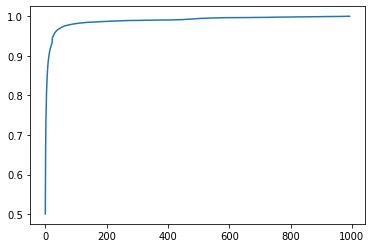

In [44]:
fig, ax = plt.subplots()
ax.plot([tactic_metrics_results[f'tactic_logits_top_{k}'] for k in range(1, tactic_num)])

In [48]:
for k in range(1,21):
    acc = tactic_metrics_results[f'tactic_logits_top_{k}']
    print(f'{k}: {100*acc:.2f}%')

1: 50.07%
2: 64.94%
3: 73.36%
4: 77.52%
5: 80.56%
6: 83.07%
7: 84.71%
8: 86.02%
9: 87.24%
10: 88.14%
11: 88.91%
12: 89.53%
13: 90.10%
14: 90.60%
15: 91.05%
16: 91.41%
17: 91.71%
18: 91.97%
19: 92.32%
20: 92.55%


In [173]:
def benchmark(dataset,
              tactic_expand_bound,
              total_expand_bound,
              batch_size=256
             ):
    valid_proofstates = dataset.valid_proofstates()

    start = time.time()
    result = global_argument_predict._evaluate(valid_proofstates,
                                               batch_size=batch_size,
                                               tactic_expand_bound=tactic_expand_bound,
                                               total_expand_bound=total_expand_bound
                                              )
    end = time.time()
    total = end-start
    average = (end-start)/dataset.stats()['valid_proofstates']['num_graphs']
    print(f'{result:.4f} in {total:.2f}s ({average:.6f}s per proofstate)')

In [201]:
print(1)

1


In [176]:
benchmark(dataset_large, tactic_expand_bound=1, total_expand_bound=1)

computing dataset statistics (this may take a while)...
0.3599 in 260.54s (0.011588s per proofstate)


In [177]:
benchmark(dataset_large, tactic_expand_bound=2, total_expand_bound=1)

0.4553 in 369.70s (0.016443s per proofstate)


In [178]:
benchmark(dataset_large, tactic_expand_bound=3, total_expand_bound=1)

0.4985 in 503.34s (0.022387s per proofstate)


In [179]:
benchmark(dataset_large, tactic_expand_bound=4, total_expand_bound=1)

0.5201 in 636.40s (0.028305s per proofstate)


In [180]:
benchmark(dataset_large, tactic_expand_bound=5, total_expand_bound=1)

0.5350 in 774.97s (0.034468s per proofstate)


In [181]:
benchmark(dataset_large, tactic_expand_bound=6, total_expand_bound=1)

0.5459 in 913.36s (0.040623s per proofstate)


In [182]:
benchmark(dataset_large, tactic_expand_bound=7, total_expand_bound=1)

0.5539 in 1040.23s (0.046265s per proofstate)


In [183]:
benchmark(dataset_large, tactic_expand_bound=8, total_expand_bound=1)

0.5600 in 1188.82s (0.052874s per proofstate)


In [184]:
benchmark(dataset_large, tactic_expand_bound=9, total_expand_bound=1)

0.5651 in 1325.08s (0.058934s per proofstate)


In [12]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=1)

0.5698 in 1471.84s (0.065462s per proofstate)


In [185]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=2)

0.5698 in 1464.62s (0.065141s per proofstate)


In [186]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=3)

0.5698 in 1465.42s (0.065176s per proofstate)


In [187]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=4)

0.5958 in 1604.33s (0.071354s per proofstate)


In [188]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=5)

0.5958 in 1603.04s (0.071297s per proofstate)


In [189]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=6)

0.5958 in 1609.86s (0.071600s per proofstate)


In [190]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=7)

0.5958 in 1618.47s (0.071983s per proofstate)


In [191]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=8)

0.5976 in 1691.79s (0.075244s per proofstate)


In [192]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=9)

0.6118 in 1829.00s (0.081347s per proofstate)


In [13]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=10)

0.6118 in 1789.64s (0.079596s per proofstate)


In [193]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=20)

0.6212 in 1986.44s (0.088349s per proofstate)


In [194]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=30)

0.6281 in 2270.19s (0.100969s per proofstate)


In [195]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=40)

0.6330 in 2421.57s (0.107702s per proofstate)


In [196]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=50)

0.6368 in 2575.14s (0.114532s per proofstate)


In [197]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=60)

0.6368 in 2539.07s (0.112928s per proofstate)


In [198]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=70)

0.6410 in 2931.82s (0.130396s per proofstate)


In [199]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=80)

0.6410 in 2945.76s (0.131016s per proofstate)


In [200]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=90)

0.6438 in 3097.01s (0.137743s per proofstate)


In [14]:
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=100)

0.6460 in 3138.13s (0.139571s per proofstate)


In [ ]:
benchmark_data = {
    (1,1): (0.3599, 260.54),
    (2,1): (0.4553, 369.70),
}

In [207]:
tmp = """1
benchmark(dataset_large, tactic_expand_bound=1, total_expand_bound=1)
0.3599 in 260.54s (0.011588s per proofstate)
2
benchmark(dataset_large, tactic_expand_bound=2, total_expand_bound=1)
0.4553 in 369.70s (0.016443s per proofstate)
3
benchmark(dataset_large, tactic_expand_bound=3, total_expand_bound=1)
0.4985 in 503.34s (0.022387s per proofstate)
4
benchmark(dataset_large, tactic_expand_bound=4, total_expand_bound=1)
0.5201 in 636.40s (0.028305s per proofstate)
5
benchmark(dataset_large, tactic_expand_bound=5, total_expand_bound=1)
0.5350 in 774.97s (0.034468s per proofstate)
6
benchmark(dataset_large, tactic_expand_bound=6, total_expand_bound=1)
0.5459 in 913.36s (0.040623s per proofstate)
7
benchmark(dataset_large, tactic_expand_bound=7, total_expand_bound=1)
0.5539 in 1040.23s (0.046265s per proofstate)
8
benchmark(dataset_large, tactic_expand_bound=8, total_expand_bound=1)
0.5600 in 1188.82s (0.052874s per proofstate)
9
benchmark(dataset_large, tactic_expand_bound=9, total_expand_bound=1)
0.5651 in 1325.08s (0.058934s per proofstate)
1
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=1)
0.5698 in 1471.84s (0.065462s per proofstate)
2
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=2)
0.5698 in 1464.62s (0.065141s per proofstate)
3
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=3)
0.5698 in 1465.42s (0.065176s per proofstate)
4
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=4)
0.5958 in 1604.33s (0.071354s per proofstate)
5
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=5)
0.5958 in 1603.04s (0.071297s per proofstate)
6
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=6)
0.5958 in 1609.86s (0.071600s per proofstate)
7
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=7)
0.5958 in 1618.47s (0.071983s per proofstate)
8
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=8)
0.5976 in 1691.79s (0.075244s per proofstate)
9
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=9)
0.6118 in 1829.00s (0.081347s per proofstate)
1
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=10)
0.6118 in 1789.64s (0.079596s per proofstate)
2
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=20)
0.6212 in 1986.44s (0.088349s per proofstate)
3
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=30)
0.6281 in 2270.19s (0.100969s per proofstate)
4
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=40)
0.6330 in 2421.57s (0.107702s per proofstate)
5
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=50)
0.6368 in 2575.14s (0.114532s per proofstate)
6
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=60)
0.6368 in 2539.07s (0.112928s per proofstate)
7
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=70)
0.6410 in 2931.82s (0.130396s per proofstate)
8
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=80)
0.6410 in 2945.76s (0.131016s per proofstate)
9
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=90)
0.6438 in 3097.01s (0.137743s per proofstate)
1
benchmark(dataset_large, tactic_expand_bound=10, total_expand_bound=100)
0.6460 in 3138.13s (0.139571s per proofstate)"""
tmp = tmp.split('\n')

In [224]:
benchmark_data = {}
for i in range(0, len(tmp), 3):
    a = tmp[i+1].replace('benchmark(dataset_large, tactic_expand_bound=', '(').replace('total_expand_bound=', '')
    b = '('+tmp[i+2].replace(' in ', ', ').replace('s ', ')#')
    benchmark_data[eval(a)] = eval(b)
benchmark_data

{(1, 1): (0.3599, 260.54),
 (2, 1): (0.4553, 369.7),
 (3, 1): (0.4985, 503.34),
 (4, 1): (0.5201, 636.4),
 (5, 1): (0.535, 774.97),
 (6, 1): (0.5459, 913.36),
 (7, 1): (0.5539, 1040.23),
 (8, 1): (0.56, 1188.82),
 (9, 1): (0.5651, 1325.08),
 (10, 1): (0.5698, 1471.84),
 (10, 2): (0.5698, 1464.62),
 (10, 3): (0.5698, 1465.42),
 (10, 4): (0.5958, 1604.33),
 (10, 5): (0.5958, 1603.04),
 (10, 6): (0.5958, 1609.86),
 (10, 7): (0.5958, 1618.47),
 (10, 8): (0.5976, 1691.79),
 (10, 9): (0.6118, 1829.0),
 (10, 10): (0.6118, 1789.64),
 (10, 20): (0.6212, 1986.44),
 (10, 30): (0.6281, 2270.19),
 (10, 40): (0.633, 2421.57),
 (10, 50): (0.6368, 2575.14),
 (10, 60): (0.6368, 2539.07),
 (10, 70): (0.641, 2931.82),
 (10, 80): (0.641, 2945.76),
 (10, 90): (0.6438, 3097.01),
 (10, 100): (0.646, 3138.13)}

In [1]:
benchmark_data = {(1, 1): (0.3599, 260.54),
 (2, 1): (0.4553, 369.7),
 (3, 1): (0.4985, 503.34),
 (4, 1): (0.5201, 636.4),
 (5, 1): (0.535, 774.97),
 (6, 1): (0.5459, 913.36),
 (7, 1): (0.5539, 1040.23),
 (8, 1): (0.56, 1188.82),
 (9, 1): (0.5651, 1325.08),
 (10, 1): (0.5698, 1471.84),
 (10, 2): (0.5698, 1464.62),
 (10, 3): (0.5698, 1465.42),
 (10, 4): (0.5958, 1604.33),
 (10, 5): (0.5958, 1603.04),
 (10, 6): (0.5958, 1609.86),
 (10, 7): (0.5958, 1618.47),
 (10, 8): (0.5976, 1691.79),
 (10, 9): (0.6118, 1829.0),
 (10, 10): (0.6118, 1789.64),
 (10, 20): (0.6212, 1986.44),
 (10, 30): (0.6281, 2270.19),
 (10, 40): (0.633, 2421.57),
 (10, 50): (0.6368, 2575.14),
 (10, 60): (0.6368, 2539.07),
 (10, 70): (0.641, 2931.82),
 (10, 80): (0.641, 2945.76),
 (10, 90): (0.6438, 3097.01),
 (10, 100): (0.646, 3138.13)}

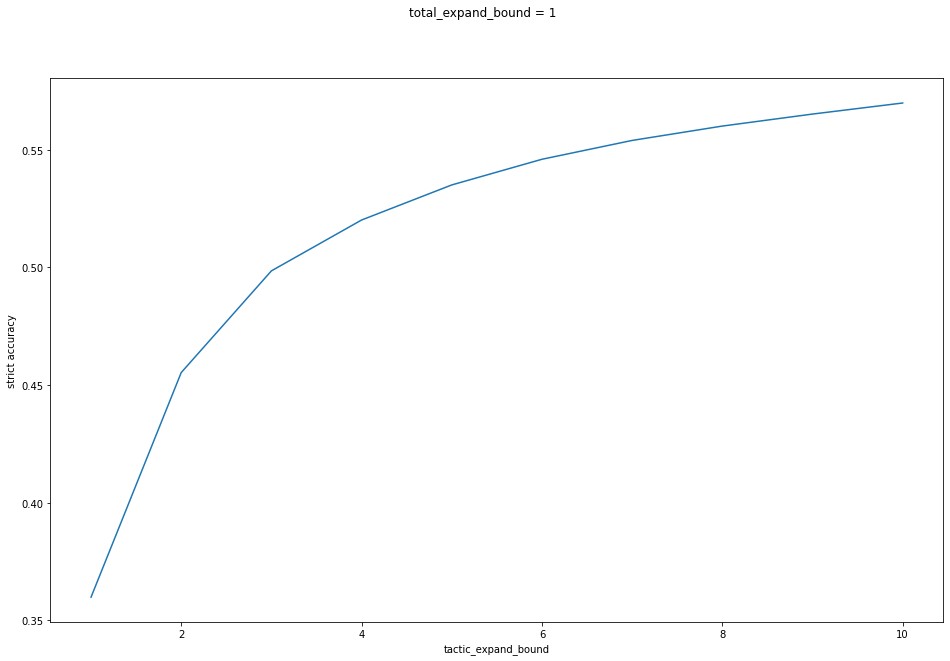

In [28]:
fig, ax = plt.subplots(figsize=(16, 10))
plt.suptitle('total_expand_bound = 1')
plt.ylabel('strict accuracy')
plt.xlabel('tactic_expand_bound')
tactic_expand_bounds = [1,2,3,4,5,6,7,8,9,10]
ax.plot(tactic_expand_bounds, [benchmark_data[(tactic_expand_bound, 1)][0] for tactic_expand_bound in tactic_expand_bounds])
plt.show()

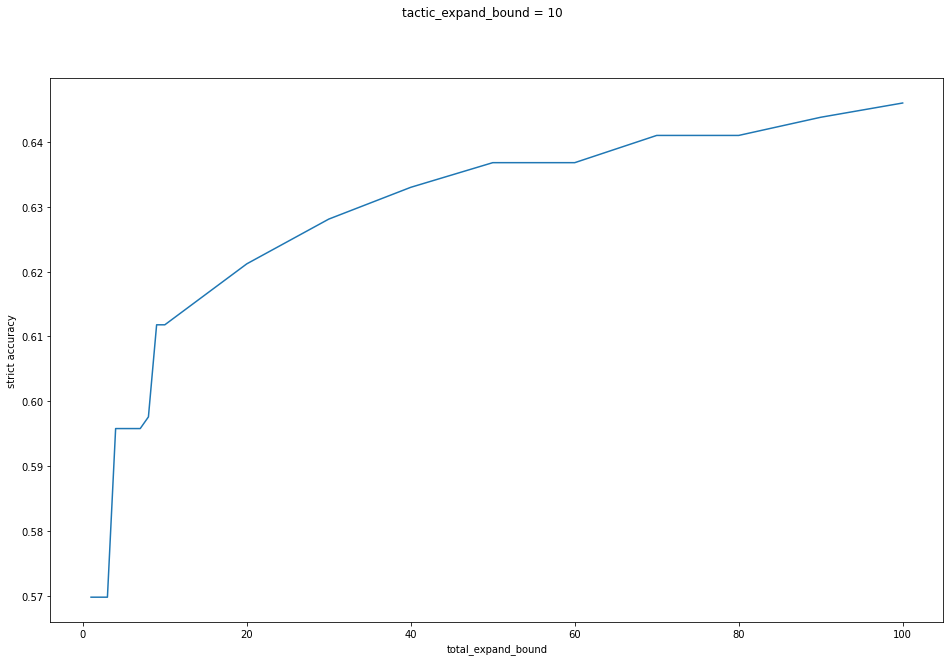

In [27]:
fig, ax = plt.subplots(figsize=(16,10))
plt.suptitle('tactic_expand_bound = 10')
plt.ylabel('strict accuracy')
plt.xlabel('total_expand_bound')
total_expand_bounds = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
ax.plot(total_expand_bounds, [benchmark_data[(10, total_expand_bound)][0] for total_expand_bound in total_expand_bounds])
plt.show()